# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.7.3" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key)."
fi

# Install Julia packages

In [ ]:
] add CSV@v0.10.4 CategoricalArrays@v0.10.6 DataFrames@v1.3.5 Distributions@v0.25.70

In [ ]:
] add ForwardDiff@v0.10.32 GLM@v1.8.0 HTTP@v1.3.3 NLSolversBase@v7.8.2

In [ ]:
] add Optim@v1.7.3 Pipe@v1.3.0 Plots@v1.32.1 RollingFunctions@v0.6.2

In [ ]:
] add StatsBase@v0.33.21 StatsPlots@v0.15.3 Underscores@v3.0.0

In [ ]:
] add NLopt@v0.6.5 Printf SpecialFunctions@v1.8.7 TimeSeries@v0.23.1

In [ ]:
] add Dates LinearAlgebra Statistics

In [ ]:
] add HypothesisTests@v0.10.11

In [ ]:
] add CovarianceMatrices@v0.10.3

In [4]:
using CSV, CategoricalArrays, DataFrames, Distributions, ForwardDiff, GLM, HTTP,
NLSolversBase, Optim, Pipe, Plots, RollingFunctions, StatsBase, StatsPlots,
Underscores, Dates, LinearAlgebra, Statistics, Plots.PlotMeasures, HypothesisTests, CovarianceMatrices
 #, TimeSeries, NLopt, Printf, SpecialFunctions

In [ ]:
# The package Forecast.jl and GARCH.jl are "holding me back" on updating CSV.jl and Distributions.jl
# Have to steal functions from their GitHub page to get around it
# Also write the GARCH part in my own score functions, so no need to use GARCH.jl anymore

# Part 1: National Data

Observed COVID-19 cases can be subject to bias due to several factors, such as:

Testing bias: The number of reported cases depends on the number of tests being conducted, and the availability of testing can vary by region and demographic. This can result in underreporting of cases in areas with limited access to testing.

Reporting bias: The number of reported cases may also be affected by the accuracy and completeness of reporting. Some countries have more robust reporting systems, while others may have difficulties with data collection and reporting.

Health seeking behavior: Some people may be more likely to seek testing and treatment than others, based on their health-seeking behavior, socioeconomic status, and access to healthcare.

It's important to keep in mind that biases in COVID-19 case reporting can impact our understanding of the true spread of the virus and the effectiveness of mitigation measures. This highlights the need for robust, transparent, and consistent reporting and data collection efforts, to ensure accurate tracking of the pandemic.

In [82]:
# set global values
### notes: groupby, combine, unstack, xticks labels
### runmean doesn't change length, rollmean reduces length by windowsize - 1
date_of_first_obs = Date("2020-04-06"); # cut-off date, a Monday
earliest_effective_Mon = Date("2020-04-13")
vaccination_initiated_date = Date("2020-12-27")
#date_of_first_obs = Date("2020-05-04");
windowsize = 7; # window size for aggregating data into windowsize-ly data
sub_sample_size = 90;  # sub-sample study size 
Nstar = 5800000; # N*, to get adjusted cases numbers
nstar = log(Nstar);
# important dates
Holidays2020 = [Date(2020,04,09); Date(2020,04,10); Date(2020,04,12); Date(2020,04,13); 
                Date(2020,05,08); Date(2020,05,21); Date(2020,05,31); 
                Date(2020,06,01); Date(2020,06,05);
                Date(2020,12,24); Date(2020,12,25); Date(2020,12,26)]
Holidays2021 = [Date(2021,01,01); 
            Date(2021,04,01); Date(2021,04,02); Date(2021,04,03);
            Date(2021,04,04);Date(2021,04,05); Date(2021,04,30); 
            Date(2021,05,13); Date(2021,05,23); Date(2021,05,24);
            Date(2021,06,05);
            Date(2021,12,24); Date(2021,12,25); Date(2021,12,26)]
Holidays2022 = [Date(2022,01,01); 
            Date(2022,04,14); Date(2022,04,15); Date(2022,04,17); Date(2022,04,18);
            Date(2022,05,13); Date(2022,05,26); Date(2022,06,05); Date(2022,06,06);
            Date(2022,12,24); Date(2022,12,25); Date(2022,12,26)]

Holidays = [Holidays2020; Holidays2021; Holidays2022]

AlphaVariant = Date(2020,11,09);
DeltaVariant = Date(2021,05,17);
OmicronVariant = Date(2021,11,24);
BA2 = Date(2021,12,05);
BA5 = Date(2022, 04, 10);
Variants = [AlphaVariant, DeltaVariant, OmicronVariant]
rename_dict = Dict("1" => :Mon, "2" => :Tue, "3" => :Wed, "4" => :Thu, "5" => :Fri, "6" => :Sat, "7" => :Sun);

In [258]:
# Import data
national = @pipe CSV.File(HTTP.get("https://raw.githubusercontent.com/shuofanzhang/covid/main/Test_pos_over_time.csv").body, 
                        footerskip=2, 
                        select = [1, 2, 6], 
                        typemap = Dict(Float64 => String),
                        dateformat= "yyyy-mm-dd") |> 
        DataFrame |> 
        DataFrames.transform(_, :Date, 
                 :Tested => ByRow(x -> parse(Int, replace(x, "." => ""))) => :Nt, 
                 :NewPositive =>ByRow(x -> parse(Int, replace(x, "." => ""))) => :Ct) |>                 
        DataFrames.transform(_, :Date => (x -> Dates.month.(x)) => :Month,
                     :Date => (x -> Dates.year.(x)) => :Year,
                     :Date => (x -> Dates.dayofweek.(x)) => :Day,
                     :Date => (x -> Dates.firstdayofweek.(x)) => :firstD,
                     :Date => (x -> ifelse.(in(Holidays).(x), 1, 0)) => :Holiday) |>
        DataFrames.transform(_, :Day => (x -> ifelse.(x .== 1, 1, 0)) => :Mon,
                     :Day => (x -> ifelse.(x .== 2, 1, 0)) => :Tue,
                     :Day => (x -> ifelse.(x .== 3, 1, 0)) => :Wed,
                     :Day => (x -> ifelse.(x .== 4, 1, 0)) => :Thu,
                     :Day => (x -> ifelse.(x .== 5, 1, 0)) => :Fri,
                     :Day => (x -> ifelse.(x .== 6, 1, 0)) => :Sat,
                     :Day => (x -> ifelse.(x .== 7, 1, 0)) => :Sun,
                     :Year => (x -> ifelse.(x .== 2020, 1, 0)) => :Y20,
                     :Year => (x -> ifelse.(x .== 2021, 1, 0)) => :Y21,
                     :Year => (x -> ifelse.(x .== 2022, 1, 0)) => :Y22,
                     :Nt => (x -> log.(max.(x, 1))) => :nt,
                     :Ct => (x -> log.(max.(x, 1))) => :ct,
                     [:Nt, :Ct] => ((x, y) -> y ./ x) => :PosRate) |>
        DataFrames.transform(_, :nt => (x -> replace!(x, -Inf => 0)) => :nt,
                :ct => (x -> replace!(x, -Inf => 0)) => :ct,
                :PosRate => (x -> replace!(x, NaN => 0)) => :PosRate) |>
        DataFrames.transform(_,  
                  :nt => (x -> x - GLM.lag(x)) => :Dnt,
                  :ct => (x -> x - GLM.lag(x)) => :Dct,
                  :nt => (x -> GLM.lag(x)) => :nt_lag,
                  :nt => (x -> GLM.lag(x, 2)) => :nt_lag2,
                  :nt => (x -> x .- collect([[missing, missing, missing] ; rollmean(x, 7); [missing, missing, missing]])) => :Dmnt,
                  :ct => (x -> x .- collect([[missing, missing, missing] ; rollmean(x, 7); [missing, missing, missing]])) => :Dmct) |>
        DataFrames.transform(_, :Dnt => (x -> x - GLM.lag(x)) => :D2nt,
                                :Dct => (x -> x - GLM.lag(x)) => :D2ct,) |>
        dropmissing(_)

last_Sunday_date = filter(:Sun => x -> x == 1, national).Date[end]
HolidayWeekFristDay = unique(filter(:Holiday => x -> x == 1, national).firstD)
national.HoliWeek = in.(national.firstD, [HolidayWeekFristDay])
# Select holidays that needs to be imputed, manual for now
i = [7,8,9,12,16,17,18,21,24]
Holi_needs_care = HolidayWeekFristDay[i];

In [259]:
case_vaccine_data = @pipe CSV.File(HTTP.get("https://raw.githubusercontent.com/shuofanzhang/covid/main/04_confirmed_cases_by_vaccination_status_by_age_group_by_week.csv").body,
    skipto = 2, 
    header = ["Week", "Age", "Vac", "Ct", "sort", "population", "Ct100k"], 
    delim = ";") |>
    DataFrame |>
    transform(_, :Ct100k => ByRow(x -> parse(Float64, replace(x, "," => "."))) => :Ct100k,
                :Ct => (x -> log.(x)) => :ct) |>
    transform(_, :ct => (x -> replace!(x, -Inf => 0)) => :ct,
                :Ct100k => (x -> log.(x)) => :ct100k) |>
    transform(_, :ct100k => (x -> replace!(x, -Inf => 0)) => :ct100k);

In [272]:
# This chunk is to the case vaccine data with the national case data
# they match
df = @pipe select(case_vaccine_data, :Week, :Age, :Vac, :Ct) |>
    unstack(_, [:Week, :Vac], :Age, :Ct) |>
    transform(_, Not([:Week, :Vac]) => ByRow(+) => :all_age) |>
    select(_, :Week, :Vac, :all_age) |>
    unstack(_, :Week, :Vac, :all_age) |>
    transform(_, Not(:Week) => ByRow(+) => :all_case,
                :Week => ByRow(x -> parse.(Int, first.(x, 4))) => :year,
                :Week => ByRow(x -> parse.(Int, last.(x, 2))) => :week)

@pipe unstack(national, :firstD, :Day, :Ct) |>
        DataFrames.transform(_,  Not(:firstD) => ByRow(+) => :WeekSum,
        :firstD => ByRow(Dates.week) => :Week,
        :firstD => ByRow(Dates.year) => :Year) |>
        select(_, :Year, :Week, :WeekSum) |>
@df leftjoin(df, _, on = [:year => :Year, :week => :Week]) plot([:all_case, :WeekSum], yaxis = :log);

In [261]:
tests_vaccine_2021 = 
@pipe CSV.File(HTTP.get("https://raw.githubusercontent.com/shuofanzhang/covid/main/2021_tests_vaccine_weekly.csv").body) |>
    DataFrame |>
    insertcols!(_, 1, :Week => parse.(Int, SubString.(_.Ugenummer, 5, 6))) |>
    insertcols!(_, 1, :Year => parse.(Int, last.(_.Ugenummer, 4))) |>
    sort!(_, :Week)

tests_vaccine_2022 = 
@pipe CSV.File(HTTP.get("https://raw.githubusercontent.com/shuofanzhang/covid/main/2022_tests_vaccine_weekly.csv").body) |>
    DataFrame |>
    insertcols!(_, 1, :Week => parse.(Int, SubString.(_.Ugenummer, 5, 6))) |>
    insertcols!(_, 1, :Year => parse.(Int, last.(_.Ugenummer, 4))) |>
    sort!(_, :Week)

df = @pipe vcat(tests_vaccine_2021, tests_vaccine_2022) |>
    select(_, :Year, :Week, findall(col -> occursin("tests", string(col)), names(_)))
# combine this data with national tests
test_vaccine_data = @pipe unstack(national, :firstD, :Day, :Nt) |>
        DataFrames.transform(_,  Not(:firstD) => ByRow(+) => :WeekSum,
        :firstD => ByRow(Dates.week) => :Week,
        :firstD => ByRow(Dates.year) => :Year) |>
        select(_, :Year, :Week, :WeekSum) |>
leftjoin(df, _, on = [:Year => :Year, :Week => :Week]); 
# @df test_vaccine_data plot(:WeekSum)
# plot!(sum(Matrix(df[: , [end-4, end-3, end-2]]), dims = 2 ))
# this plot is to check the test vaccine data with the national test data, they match

In [326]:
df1 = @pipe test_vaccine_data |>
    filter(:Year => (x -> x == 2021), _) |>
    select(_,:Week, findall(col -> occursin("Anden", string(col)), names(_))) 
plot(df1.Week, Matrix(df1)[:, 4])
plot!(df2.Week, df2.N)
names(df1)[4]

"antal_tests_total_Anden vaccination"

In [322]:
df = @pipe CSV.File(HTTP.get("https://raw.githubusercontent.com/shuofanzhang/covid/main/2021_tests_vaccine_age_weekly.csv").body, delim = ";") |>
    DataFrame |>
    select(_,1, findall(col -> occursin("Anden", string(col)), names(_))) 
#names(df) 

df2 = DataFrame(Week = collect(51:-1:36), N= Int.(Matrix(df)[14, 2:end]))

,Week,N
,Int64,Int64
1,51,1032038
2,50,1166813
3,49,1051893
4,48,949270
5,47,916530
6,46,853513
7,45,797241
8,44,629890
9,43,495004


In [ ]:
# form the case and test vaccine data together
@pipe case_vaccine_data |>
    select(_, :Year, :Week, findall(col -> occursin("total", string(col)), names(_))) |>
    _[:, 1:5] |>
    rename(_, ["Year", "Week", "N0", "N1", "N2"])
    

In [269]:
# form the case and test vaccine data together
@pipe test_vaccine_data |>
    select(_, :Year, :Week, findall(col -> occursin("total", string(col)), names(_))) |>
    _[:, 1:5] |>
    rename(_, ["Year", "Week", "N0", "N1", "N2"])
    

,Year,Week,N0,N1,N2
,Int64,Int64,Int64,Int64,Int64
1,2021,36,87003,11741,225141
2,2021,37,67589,7453,186798
3,2021,38,63871,5400,171172
4,2021,39,63790,4302,175232
5,2021,40,73044,4443,189776
6,2021,41,104332,6160,259412
7,2021,42,98521,5644,362820
8,2021,43,127285,6822,495004
9,2021,44,193530,8560,629890


In [ ]:
Rdata = @pipe CSV.File("/Users/shuofanzhang/Rdata.csv", 
                        dateformat= "yyyy-mm-dd") |> 
        DataFrame |>
        filter(:date => x -> x >= Date(2020,03,01), _)
plot(log.(Rdata.confirmed))

In [ ]:
cumulateive_Ct = zeros(nrow(national_truncated))
for i in 1:nrow(national_truncated)
    cumulateive_Ct[i] = sum(national_truncated.Ct[1:i])
end
plot(national_truncated.Date, log.(cumulateive_Ct) )

In [ ]:
national_death = @pipe CSV.File(
    HTTP.get("https://raw.githubusercontent.com/shuofanzhang/covid/main/Deaths_over_time.csv").body,
        footerskip = 2, 
        select = [1, 2], 
        typemap = Dict(Float64 => String),
        dateformat = "yyyy-mm-dd") |> 
        DataFrame |>
        select(_, :Dato => :Date, :Antal_døde => :Death);

In [ ]:
Their_Rt = @pipe CSV.File(
    HTTP.get("https://raw.githubusercontent.com/shuofanzhang/covid/main/Rt_cases_2023_01_17.csv").body) |> 
    DataFrame |>
    transform(_, :estimate => ByRow(x -> parse(Float64, replace(x, "," => "."))) => :Rt,
                :uncertainty_lower => ByRow(x -> parse(Float64, replace(x, "," => "."))) => :lower,
                :uncertainty_upper => ByRow(x -> parse(Float64, replace(x, "," => "."))) => :upper)
@df Their_Rt plot(:SampleDate, :Rt, ribbon = (:Rt .- :lower, :upper .- :Rt), label = :none)             

In [ ]:
# this is vaccine data only, no interaction with cases or tests
vaccine = @pipe CSV.File(
    HTTP.get("https://raw.githubusercontent.com/shuofanzhang/covid/main/Vaccine_dato.csv").body, 
    dateformat= "mm/dd/yy",
    select = [1, 11, 12, 13, 14]) |> 
    DataFrame |>
    rename(_, ["Date", "first", "second", "third", "forth"]) |>
    transform(_, :Date => (x -> x .+ Dates.Year(2000)) => :Date);


## Clean data: impute outliers and deperiodicity

# The periodicity works with Dnt and Dct directly now
# To get around negative values, shift them up by a constant c
c = 1.8
which_Dnt = :Dmnt
which_Dct = :Dmct
# De-periodicity functions
function data_wider(data, which_series) # data should have wholes weeks, starts from Mon, have Date and Nt or Ct
wider = @pipe unstack(data, :firstD, :Day, :($which_series)) |>
  DataFrames.transform(_,  Not(:firstD) => ByRow(+) => :weekSum)
DataFrames.rename!(wider, rename_dict)
return(wider)
end
function DePe_theta(α, data) # data should be a matrix that contains only Mon-Sun and weekSum
W = size(data)[1]
θ = zeros(W, 6)
initial_average = mean.(eachcol(data[1:4, :]))
θ[1, :] = log.(initial_average[1:6]  ./ initial_average[7] )
for i in 2:W
N_vector = data[i - 1, 1:6]
Nw = data[i - 1, 8]
exp_θ_vector = exp.(θ[i - 1, :])
sum_exp_w = sum(exp_θ_vector)
score_vector = N_vector .- Nw .* exp_θ_vector ./ (1 + sum_exp_w)
hessian_vector = Nw .* exp_θ_vector .* (1 .+ sum_exp_w .- exp_θ_vector) ./ (1 + sum_exp_w)^2
Sw_vector = score_vector ./ hessian_vector  ##### use hessian as scaling instead of sqrt(hessian)
θw1_vector = θ[i - 1, :] .+ α .* Sw_vector
θ[i, :] = θw1_vector
end
return(θ)
end

function DePe_logL(α, data)   # data should be a matrix that contains only Mon-Sun and weekSum
θ = DePe_theta(α, data)
W = size(data)[1]
logLw_vector = []
for i in 1:W
N_vector = data[i, 1:6]
θw_vector = θ[i, 1:6]
Nw = data[i, 8]
logLw = sum(N_vector .* θw_vector) - Nw * log(1 + sum(exp.(θw_vector)))
push!(logLw_vector, logLw)
end
logL = sum(logLw_vector)
return(logL)
end

function DePe_theta2p(θw)
p7 = (sum(exp.(θw)) + 1) .^ (-1)
p16 = exp.(θw) .* p7
p = [p16; p7]
return(p)
end

function DePe_Pdf(data) # input data should be dataframe contains data from Mon to Sun and weekSum
dMat = Matrix(select(data, :Mon, :Tue, :Wed, :Thu, :Fri, :Sat, :Sun, :weekSum))
res = Optim.optimize(x -> - DePe_logL(first(x), dMat), [0.0001, 0], LBFGS()) 
Otheta = DePe_theta(Optim.minimizer(res)[1], dMat)
Pmat = DataFrame(Mon = Float64[], Tue = Float64[], Wed = Float64[], Thu = Float64[], Fri = Float64[], Sat = Float64[], Sun = Float64[])
for eachrow in eachrow(Otheta)
push!(Pmat, DePe_theta2p(eachrow))
end
Pmat.firstD = data.firstD
return(Pmat)
end

function DePe_data_cleaner(wider, Pdf)
result_data = DataFrame(Date = wider.firstD)
wider_mat = Matrix(select(wider, :Mon, :Tue, :Wed, :Thu, :Fri, :Sat, :Sun))
Pdf_mat = Matrix(select(Pdf, :Mon, :Tue, :Wed, :Thu, :Fri, :Sat, :Sun)) 

depe_ed = DataFrame(Mon = Float64[], Tue = Float64[], Wed = Float64[], 
                    Thu = Float64[], Fri = Float64[], Sat = Float64[], Sun = Float64[])

for i in 1:size(Pdf_mat)[1]
v = wider_mat[i, :] .- Pdf_mat[i, :] .* wider.weekSum[i] .+ wider.weekSum[i]/7 
push!(depe_ed, v)
end

data = @pipe hcat(select(wider,  :firstD), depe_ed) |>
  DataFrames.stack(_, Not(:firstD)) |>
  sort!(_, :firstD) 
return(data.value)
end

function DePe_data2data_cleaner(data)  # a dataframe contains Nt and Ct
new_data = select(data, [:Date, :Month, :Year, :Day])
new_data.Nt = DePe_data_cleaner(data_wider(data, string(which_Dnt)), DePe_Pdf(data_wider(data, string(which_Dnt))))
new_data.Ct = DePe_data_cleaner(data_wider(data, string(which_Dct)), DePe_Pdf(data_wider(data, string(which_Dct))))
return(new_data)
end

national_NoHoliday_truncated_positive_series =
  @pipe filter(:firstD => x -> x ∉ Holi_needs_care, national) |>
  filter(:Date => x -> x <= last_Sunday_date &&
           x >= date_of_first_obs, _) |>
  transform(_, :($which_Dnt) => (x -> x .+ c) => :Dnt,
            :($which_Dct) => (x -> x .+ c) => :Dct)

wider_Nt_NoHoliday = data_wider(national_NoHoliday_truncated_positive_series, string(which_Dnt))
wider_Ct_NoHoliday = data_wider(national_NoHoliday_truncated_positive_series, string(which_Dct))
Nt_Pdf_NoHoliday = DePe_Pdf(wider_Nt_NoHoliday)
Ct_Pdf_NoHoliday = DePe_Pdf(wider_Ct_NoHoliday)

Dates4impute = []

for d in Holi_needs_care
v = ifelse( d - Dates.Day(7) in Holi_needs_care, 
            ifelse( d + Dates.Day(7) in Holi_needs_care, missing, d + Dates.Day(7)), 
            d - Dates.Day(7))
push!(Dates4impute, v)
end

ffill(v) = v[accumulate(max, [i*!ismissing(v[i]) for i in 1:length(v)], init=1)]
Dates4impute = ffill(Dates4impute)

data_around_Holiday = @pipe filter(:firstD => x -> x in Holi_needs_care, national) |>
  select(_, :Date, 
         :($which_Dnt) => (x -> repeat(rollmean(x, 7)[1:7:end] * 7, inner = 7)) => :SumNt, 
         :($which_Dct)  => (x -> repeat(rollmean(x, 7)[1:7:end] * 7, inner = 7)) => :SumCt) 

# Use probabilities before or after the holiday period for that period
data_around_Holiday.NtProbs =    
  @pipe leftjoin(DataFrame(firstD = Dates4impute), 
                 filter(:firstD => x -> x in Dates4impute, Nt_Pdf_NoHoliday), 
                 on = :firstD) |>
  stack(_, Not(:firstD)) |>
  DataFrames.transform(_, :variable => (x -> levels!(categorical(x), 
                                                     ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])) => :Day) |>
  sort(_, [:firstD, :Day]).value  

data_around_Holiday.CtProbs =    
  @pipe leftjoin(DataFrame(firstD = Dates4impute), 
                 filter(:firstD => x -> x in Dates4impute, Ct_Pdf_NoHoliday), 
                 on = :firstD) |>
  stack(_, Not(:firstD)) |>
  DataFrames.transform(_, :variable => (x -> levels!(categorical(x), 
                                                     ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])) => :Day) |>
  sort(_, [:firstD, :Day]).value     

data_around_Holiday = @pipe copy(data_around_Holiday) |>
  DataFrames.transform!(_, [:SumNt, :NtProbs] => ((x, y) -> (x .+ 7*c) .* y .- c ) => :imputeDnt,
                        [:SumCt, :CtProbs] => ((x, y) -> (x .+ 7*c) .* y .- c) => :imputeDct)

# replace the original data with imputed data
national.:($which_Dnt)[in.(national.firstD, [Holi_needs_care])] = 
  data_around_Holiday.imputeDnt
national.:($which_Dct)[in.(national.firstD, [Holi_needs_care])] = 
  data_around_Holiday.imputeDct

national_truncated = subset(copy(national), 
                            :Date => ByRow(d -> d >= date_of_first_obs && d <= last_Sunday_date))

national_death_truncated = subset(national_death, 
                                  :Date => ByRow(d -> d >= date_of_first_obs && d <= last_Sunday_date));

In [ ]:
# works with Nt and Ct directly now

# De-periodicity functions
function data_wider(data, which_series) # data should have wholes weeks, starts from Mon, have Date and Nt or Ct
wider = @pipe unstack(data, :firstD, :Day, :($which_series)) |>
  DataFrames.transform(_,  Not(:firstD) => ByRow(+) => :weekSum)
DataFrames.rename!(wider, rename_dict)
return(wider)
end
function DePe_theta(α, data) # data should be a matrix that contains only Mon-Sun and weekSum
W = size(data)[1]
θ = zeros(W, 6)
initial_average = mean.(eachcol(data[1:4, :]))
θ[1, :] = log.(initial_average[1:6]  ./ initial_average[7] )
for i in 2:W
N_vector = data[i - 1, 1:6]
Nw = data[i - 1, 8]
exp_θ_vector = exp.(θ[i - 1, :])
sum_exp_w = sum(exp_θ_vector)
score_vector = N_vector .- Nw .* exp_θ_vector ./ (1 + sum_exp_w)
hessian_vector = Nw .* exp_θ_vector .* (1 .+ sum_exp_w .- exp_θ_vector) ./ (1 + sum_exp_w)^2
Sw_vector = score_vector ./ hessian_vector  ##### use hessian as scaling instead of sqrt(hessian)
θw1_vector = θ[i - 1, :] .+ α .* Sw_vector
θ[i, :] = θw1_vector
end
return(θ)
end

function DePe_logL(α, data)   # data should be a matrix that contains only Mon-Sun and weekSum
θ = DePe_theta(α, data)
W = size(data)[1]
logLw_vector = []
for i in 1:W
N_vector = data[i, 1:6]
θw_vector = θ[i, 1:6]
Nw = data[i, 8]
logLw = sum(N_vector .* θw_vector) - Nw * log(1 + sum(exp.(θw_vector)))
push!(logLw_vector, logLw)
end
logL = sum(logLw_vector)
return(logL)
end

function DePe_theta2p(θw)
p7 = (sum(exp.(θw)) + 1) .^ (-1)
p16 = exp.(θw) .* p7
p = [p16; p7]
return(p)
end

function DePe_Pdf(data) # input data should be dataframe contains data from Mon to Sun and weekSum
dMat = Matrix(select(data, :Mon, :Tue, :Wed, :Thu, :Fri, :Sat, :Sun, :weekSum))
res = Optim.optimize(x -> - DePe_logL(first(x), dMat), [0.0001, 0], LBFGS()) 
Otheta = DePe_theta(Optim.minimizer(res)[1], dMat)
Pmat = DataFrame(Mon = Float64[], Tue = Float64[], Wed = Float64[], Thu = Float64[], Fri = Float64[], Sat = Float64[], Sun = Float64[])
for eachrow in eachrow(Otheta)
push!(Pmat, DePe_theta2p(eachrow))
end
Pmat.firstD = data.firstD
return(Pmat)
end

function DePe_data_cleaner(wider, Pdf)
result_data = DataFrame(Date = wider.firstD)
wider_mat = Matrix(select(wider, :Mon, :Tue, :Wed, :Thu, :Fri, :Sat, :Sun))
Pdf_mat = Matrix(select(Pdf, :Mon, :Tue, :Wed, :Thu, :Fri, :Sat, :Sun)) 

depe_ed = DataFrame(Mon = Float64[], Tue = Float64[], Wed = Float64[], 
                    Thu = Float64[], Fri = Float64[], Sat = Float64[], Sun = Float64[])

for i in 1:size(Pdf_mat)[1]
v = wider_mat[i, :] .- Pdf_mat[i, :] .* wider.weekSum[i] .+ wider.weekSum[i]/7 
push!(depe_ed, v)
end

data = @pipe hcat(select(wider,  :firstD), depe_ed) |>
  DataFrames.stack(_, Not(:firstD)) |>
  sort!(_, :firstD) 
return(data.value)
end

function DePe_data2data_cleaner(data)  # a dataframe contains Nt and Ct
new_data = select(data, [:Date, :Month, :Year, :Day])
new_data.Nt = DePe_data_cleaner(data_wider(data, "Nt"), DePe_Pdf(data_wider(data, "Nt")))
new_data.Ct = DePe_data_cleaner(data_wider(data, "Ct"), DePe_Pdf(data_wider(data, "Ct")))
return(new_data)
end

national_NoHoliday_truncated_positive_series =
  @pipe filter(:firstD => x -> x ∉ Holi_needs_care, national) |>
  filter(:Date => x -> x <= last_Sunday_date &&
           x >= date_of_first_obs, _)

wider_Nt_NoHoliday = data_wider(national_NoHoliday_truncated_positive_series, "Nt")
wider_Ct_NoHoliday = data_wider(national_NoHoliday_truncated_positive_series, "Ct")
Nt_Pdf_NoHoliday = DePe_Pdf(wider_Nt_NoHoliday)
Ct_Pdf_NoHoliday = DePe_Pdf(wider_Ct_NoHoliday)

Dates4impute = []

for d in Holi_needs_care
v = ifelse( d - Dates.Day(7) in Holi_needs_care, 
            ifelse( d + Dates.Day(7) in Holi_needs_care, missing, d + Dates.Day(7)), 
            d - Dates.Day(7))
push!(Dates4impute, v)
end

ffill(v) = v[accumulate(max, [i*!ismissing(v[i]) for i in 1:length(v)], init=1)]
Dates4impute = ffill(Dates4impute)

data_around_Holiday = @pipe filter(:firstD => x -> x in Holi_needs_care, national) |>
select(_, :Date, :Nt, :Ct) |>
DataFrames.transform(_, :Nt => (x -> repeat(rollmean(x, 7)[1:7:end] * 7, inner = 7)) => :SumNt,
                     :Ct => (x -> repeat(rollmean(x, 7)[1:7:end] * 7, inner = 7)) => :SumCt) 

# Use probabilities before or after the holiday period for that period
data_around_Holiday.NtProbs =    
@pipe leftjoin(DataFrame(firstD = Dates4impute), 
               filter(:firstD => x -> x in Dates4impute, Nt_Pdf_NoHoliday), 
               on = :firstD) |>
stack(_, Not(:firstD)) |>
DataFrames.transform(_, :variable => (x -> levels!(categorical(x), 
                                                   ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])) => :Day) |>
sort(_, [:firstD, :Day]).value  

data_around_Holiday.CtProbs =    
@pipe leftjoin(DataFrame(firstD = Dates4impute), 
               filter(:firstD => x -> x in Dates4impute, Ct_Pdf_NoHoliday), 
               on = :firstD) |>
stack(_, Not(:firstD)) |>
DataFrames.transform(_, :variable => (x -> levels!(categorical(x), 
                                                   ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])) => :Day) |>
sort(_, [:firstD, :Day]).value 

data_around_Holiday = @pipe copy(data_around_Holiday) |>
DataFrames.transform!(_, [:SumNt, :NtProbs] => ((x, y) -> x .* y ) => :imputeNt,
                      [:SumCt, :CtProbs] => ((x, y) -> x .* y ) => :imputeCt)
                      
# replace the original data with imputed data
national.Nt[in.(national.firstD, [Holi_needs_care])] = 
ceil.(data_around_Holiday.imputeNt)
national.Ct[in.(national.firstD, [Holi_needs_care])] = 
ceil.(data_around_Holiday.imputeCt)


national2 = @pipe select(national, :Year, :Month, :Date, :Day, :Nt, :Ct) |>
DataFrames.transform(_, :Nt => (x -> log.(max.(x, 1))) => :nt,
                        :Ct => (x -> log.(max.(x, 1))) => :ct,
                      [:Nt, :Ct] => ((x, y) -> y ./ x) => :PosRate) |>
DataFrames.transform(_, :nt => (x -> replace!(x, -Inf => 0)) => :nt,
:ct => (x -> replace!(x, -Inf => 0)) => :ct,
:PosRate => (x -> replace!(x, NaN => 0)) => :PosRate) |>
DataFrames.transform(_,  
:nt => (x -> x - GLM.lag(x)) => :Dnt,
:ct => (x -> x - GLM.lag(x)) => :Dct,
:nt => (x -> GLM.lag(x)) => :nt_lag,
:nt => (x -> x .- collect([[missing, missing, missing] ; rollmean(x, 7); [missing, missing, missing]])) => :Dmnt,
:ct => (x -> x .- collect([[missing, missing, missing] ; rollmean(x, 7); [missing, missing, missing]])) => :Dmct) |>
DataFrames.transform(_, :Dnt => (x -> x - GLM.lag(x)) => :D2nt,
                        :Dct => (x -> x - GLM.lag(x)) => :D2ct,) |>
dropmissing(_)

national_truncated = subset(copy(national2), 
                            :Date => ByRow(d -> d >= date_of_first_obs && d <= last_Sunday_date));

In [ ]:
national_weekly = @pipe national |>
        select(_, :Date, :Month, :Year, :Day,
                  :Nt => (x -> collect([[missing, missing, missing] ; rollmean(x, 7); [missing, missing, missing]]))  => :Nt, 
                  :Ct => (x -> collect([[missing, missing, missing] ; rollmean(x, 7); [missing, missing, missing]])) => :Ct) |>
        dropmissing(_) |>
        DataFrames.transform(_, :Nt => (x -> log.(max.(x, 1))) => :nt,
                     :Ct => (x -> log.(max.(x, 1))) => :ct,
                     [:Nt, :Ct] =>  ((x, y) -> y ./ x) => :PosRate) |>
        DataFrames.transform(_, :nt => (x -> replace!(x, -Inf => 0)) => :nt,
                     :ct => (x -> replace!(x, -Inf => 0)) => :ct,
                     :PosRate => (x -> replace!(x, NaN => 0)) => :PosRate) |>
        DataFrames.transform(_, :nt => (x -> x - lag(x)) => :Dnt,
                     :ct => (x -> x - lag(x)) => :Dct,
                     :nt => (x -> lag(x)) => :nt_lag, 
                     :nt => (x -> GLM.lag(x, 2)) => :nt_lag2)  |>
        DataFrames.transform(_, :Dnt => (x -> x - GLM.lag(x)) => :D2nt,
                                :Dct => (x -> x - GLM.lag(x)) => :D2ct) |>
        DataFrames.transform(_, :D2nt => (x -> x - GLM.lag(x)) => :D3nt,
                                :D2ct => (x -> x - GLM.lag(x)) => :D3ct) |>
    subset(_, :Date => ByRow(d -> d >= date_of_first_obs && d <= last_Sunday_date));

In [ ]:
# This chunk calculates percentiles for each Dnt by weekdays
# Seems not informative
# Need better ways to determine holidays as outliers
wider_national_Dnt = @pipe unstack(national, :firstD, :Day, :Dnt) |>
        DataFrames.transform(_,  Not(:firstD) => ByRow(+) => :weekSum) |>
        DataFrames.rename!(_, rename_dict)
percentile_national_Dnt = @pipe hcat(select(wider_national_Dnt, Not([:firstD,:weekSum])) ./ wider_national_Dnt.weekSum, 
        select(wider_national_Dnt, :firstD)) |>
        filter(row -> all(x -> !(x isa Number && isnan(x)), row), _) |>
        dropmissing(_) |>
        transform(_, :Mon => ByRow(x -> findall(y -> y == x, sort(_.Mon))[1] / nrow(_)) => :MonP,
                    :Tue => ByRow(x -> findall(y -> y == x, sort(_.Tue))[1] / nrow(_)) => :TueP,
                    :Wed => ByRow(x -> findall(y -> y == x, sort(_.Wed))[1] / nrow(_)) => :WedP,
                    :Thu => ByRow(x -> findall(y -> y == x, sort(_.Thu))[1] / nrow(_)) => :ThuP,
                    :Fri => ByRow(x -> findall(y -> y == x, sort(_.Fri))[1] / nrow(_)) => :FriP,
                    :Sat => ByRow(x -> findall(y -> y == x, sort(_.Sat))[1] / nrow(_)) => :SatP,
                    :Sun => ByRow(x -> findall(y -> y == x, sort(_.Sun))[1] / nrow(_)) => :SunP) |>
        select(_,:firstD, r"P")
filter(:firstD => (x -> x in(HolidayWeekFristDay)), percentile_national_Dnt);

In [ ]:
# This is an attempt to determine which holidays to treat by graph
# The constant c which is used to shift Dnt or Dct up (o/w there are - values)
# seems has an effect on results (bad)
c = 1.5
data = subset(copy(national), 
    :Date => ByRow(d -> d >= Date(2020,12,01) && d <= Date(2021, 06, 30)))
tt = transform(data, :Dnt => (x -> x .+ c) => :Dnt,
            :Dct => (x -> x .+ c) => :Dct)
wider = @pipe unstack(tt, :firstD, :Day, :Dnt) |>
        DataFrames.transform(_,  Not(:firstD) => ByRow(+) => :weekSum) |>
        DataFrames.rename!(_, rename_dict)
     
PDF = @pipe hcat(select(wider, Not([:firstD,:weekSum])) ./ wider.weekSum, 
        select(wider, :firstD)) |>
        DataFrames.transform(_, :firstD => (x -> in.(x, [HolidayWeekFristDay])) => :HoliWeek)

scatter(PDF.firstD, Matrix(select(PDF, Not([:firstD, :HoliWeek]) ) ) , label = :none, ylim = (0.05, 0.25))
vline!(filter(:HoliWeek => (x -> x == 1), PDF).firstD, label = :none)

### clean data with rolling windows and weekly data

In [ ]:
# this is estimating prob matrix using rolling window data
function roll_wider_generator(data) # the input data must have only three columns Date, Day and Nt or Ct
    DataFrames.rename!(data, ["Date", "Day", "Nt"])
    wider_roll = DataFrame(firstD = [], secondD = [], thirdD = [], fourthD = [], fifthD = [], sixthD = [], sevenD = [],
            Mon = Float64[], Tue = Float64[], Wed = Float64[], 
           Thu = Float64[], Fri = Float64[], Sat = Float64[], Sun = Float64[])
    for i in 1 : (nrow(data) - 7 + 1)
        each_week_data = data[i : (i + 6), :]
        dddd = copy(each_week_data.Date)
       v = [dddd; sort!(each_week_data, :Day).Nt]
       push!(wider_roll, v)
    end
    @pipe wider_roll |> transform!(_,  [:Mon, :Tue, :Wed, :Thu, :Fri, :Sat, :Sun] => ByRow(+) => :weekSum)
    return(wider_roll)
end
Ntdata = select(national_NoXmas_truncated_positive_series, :Date, :Day, :Dnt)
Ctdata = select(national_NoXmas_truncated_positive_series, :Date, :Day, :Dct)
Nt_Pdf_NoXmas = DePe_Pdf(roll_wider_generator(Ntdata))
Ct_Pdf_NoXmas = DePe_Pdf(roll_wider_generator(Ctdata))

data_around_Xmas = @pipe filter(:Date => x -> x in [Christmas2020; Christmas2021; 
                                Outlier20220414; Outlier20220526], national) |>
    select(_, :Date, :Dnt, :Dct) |>
    DataFrames.transform(_, :Dnt => (x -> repeat(rollmean(x, 7)[1:7:end] * 7, inner = 7)) => :SumNt,
                :Dct => (x -> repeat(rollmean(x, 7)[1:7:end] * 7, inner = 7)) => :SumCt) 
# Use probabilities before or after the holiday period for that period
data_around_Xmas.NtProbs =    
@pipe filter(:firstD => x -> x in [Christmas2020[1] - Dates.Day(7), Christmas2020[end] + Dates.Day(1),
                             Christmas2021[1] - Dates.Day(7), Christmas2021[end] + Dates.Day(1),
                             Outlier20220414[1] - Dates.Day(7), Outlier20220526[1] - Dates.Day(7)], Nt_Pdf_NoXmas) |>
    stack(_, Not(:firstD)) |>
    DataFrames.transform(_, :variable => (x -> levels!(categorical(x), 
    ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])) => :Day) |>
    sort(_, [:firstD, :Day]).value  

data_around_Xmas.CtProbs =    
@pipe filter(:firstD => x -> x in [Christmas2020[1] - Dates.Day(7), Christmas2020[end] + Dates.Day(1),
                             Christmas2021[1] - Dates.Day(7), Christmas2021[end] + Dates.Day(1),
                             Outlier20220414[1] - Dates.Day(7), Outlier20220526[1] - Dates.Day(7)], Ct_Pdf_NoXmas) |>
    stack(_, Not(:firstD)) |>
    DataFrames.transform(_, :variable => (x -> levels!(categorical(x), 
    ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])) => :Day) |>
    sort(_, [:firstD, :Day]).value     


data_around_Xmas = @pipe copy(data_around_Xmas) |>
    DataFrames.transform!(_, [:SumNt, :NtProbs] => ((x, y) -> (x .+ 14) .* y .- 2 ) => :imputeDnt,
                 [:SumCt, :CtProbs] => ((x, y) -> (x .+ 14) .* y .- 2) => :imputeDct)

# replace the original data with imputed data
national.Dnt[in.(national.Date, [[Christmas2020; Christmas2021; Outlier20220414; Outlier20220526]])] = 
data_around_Xmas.imputeDnt
national.Dct[in.(national.Date, [[Christmas2020; Christmas2021; Outlier20220414; Outlier20220526]])] = 
data_around_Xmas.imputeDct

national_truncated = subset(copy(national), 
    :Date => ByRow(d -> d >= date_of_first_obs && d <= last_Sunday_date))


In [ ]:
national_clean = @pipe DePe_data2data_cleaner(national_truncated) |>
    DataFrames.transform(_, :Nt => (x -> log.(max.(x, 1))) => :nt,
                :Ct => (x -> log.(max.(x, 1))) => :ct,
                [:Nt, :Ct] => ((x, y) -> y ./ x) => :PosRate) |>
    DataFrames.transform(_, :nt => (x -> replace!(x, -Inf => 0)) => :nt,
                :ct => (x -> replace!(x, -Inf => 0)) => :ct,
                :PosRate => (x -> replace!(x, NaN => 0)) => :PosRate) |>
    DataFrames.transform(_,  :nt => (x -> x - lag(x)) => :Dnt,
                  :ct => (x -> x - lag(x)) => :Dct,
                  :nt => (x -> lag(x)) => :nt_lag) |>
    dropmissing(_)
national_weekly_clean = @pipe national_clean |>
        select(_, :Date, :Month, :Year, :Day,
                  :Nt => (v -> runmean(v, windowsize) * windowsize) => :Nt, 
                  :Ct => (v -> runmean(v, windowsize) * windowsize) => :Ct)  |>
        delete!(_, 1: (windowsize - 1)) |>
        DataFrames.transform(_, :Nt => (x -> log.(x)) => :nt,
                     :Ct => (x -> log.(x)) => :ct,
                     [:Nt, :Ct] =>  ((x, y) -> y ./ x) => :PosRate) |>
        DataFrames.transform(_, :nt => (x -> replace!(x, -Inf => 0)) => :nt,
                     :ct => (x -> replace!(x, -Inf => 0)) => :ct,
                     :PosRate => (x -> replace!(x, NaN => 0)) => :PosRate) |>
        DataFrames.transform(_, :nt => (x -> x - lag(x)) => :Dnt,
                     :ct => (x -> x - lag(x)) => :Dct,
                     :nt => (x -> lag(x)) => :nt_lag) |>
        dropmissing(_)

national_7dd = @pipe national_truncated |>
        select(_, :Date, :Month, :Year, :Day, :Nt, :Ct, :nt, :ct,
                  :nt => (x -> x - lag(x, 7)) => :Dnt,
                  :ct => (x -> x - lag(x, 7)) => :Dct,
                  :nt => (x -> lag(x, 7)) => :nt_lag) |>
        dropmissing(_);

## A new de-periodicity method

Fix a week $w$,

$(N_1, N_2, N_3, N_4, N_5, N_6, N_7) 
\sim 
\text{Multinomial} 
\left( (p_1, p_2, p_3, p_4, p_5, p_6, p_7),\ N \right)$
where  $N = ∑_{d=1}^7 N_d$ 
and   $p_1 + p_2 + p_3 + p_4 + p_5 + p_6 + p_7 = 1$.

Define 
$$\theta_j = \log {\frac{p_j}{p_7}}$$ 
for $j = 1, 2 ... 7$. Then, $\theta_7 = 0$, i.e. $\exp \theta_7 = 1$ and

$$
\exp{\theta_j} = \frac{p_j}{p_7}    \implies    \sum_{i=1}^7    \exp{\theta_i} = \frac{1}{p_7}    \implies    p_7 = \frac{1}{1 + \sum_{i=1}^6 \exp{\theta_i}}
$$ 

For a specific week,

$$
\begin{aligned}
\log L_w 
&= 
N_{1,w} \log p_{1,w} + N_{2,w} \log p_{2,w} + \dots + 
N_{7,w} \log p_{7,w}
\\
&=
N_{1,w} \theta_{1,w} + N_{2,w} \theta_{2,w} + \dots +
N_{6,w} \theta_{6,w} 
+
N_{1,w} \log p_{7,w} + N_{2,w} \log p_{7,w} + \dots +
N_{7,w} \log p_{7,w} 
\\
&=
N_{1,w} \theta_{1,w} + N_{2,w} \theta_{2,w} + \dots +
N_{6,w} \theta_{6,w} +
N_w \log p_{7,w}
\\
&=
N_{1,w} \theta_{1,w} + N_{2,w} \theta_{2,w} + \dots +
N_{6,w} \theta_{6,w} -
N_w \log \left(1 + \sum_{i=1}^6 \exp{\theta_{i,w}} \right)
\end{aligned}
$$

For the whole observed period,

$$
\begin{aligned}
\log L
&= 
\sum_{w=1}^W \log L_w
\end{aligned}
$$
where W is number of weeks in the sample.

Take first derivative,
$$
\frac{\partial \log L}{\partial \theta_{j,w}}
=
N_{j,w}
-
N_w
\frac{\exp \theta_{j, w}}{1 + \sum_{i=1}^6 \exp \theta_{i,w}}
$$
which is equivalent to $N_{j,w} - N_w p_{j,w}$.

Take second derivative,
$$
\frac{\partial^2 \log L}{\partial \theta_{j,w}^2}
=
- N_w  \exp \theta_{j, w}
\frac{1 + \sum_{i=1}^6 \exp \theta_{i,w} - \exp \theta_{j, w}}{(1 + \sum_{i=1}^6 \exp \theta_{i,w})^2}
$$
which is equivalent to $- N_w \ p_{j,w} (1 - p_{j,w})$.

Define 
$$
S_{j, w} = \frac{\frac{\partial \log L}{\partial \theta_{j,w}}}{\sqrt{-\frac{\partial^2 \log L}{\partial \theta_{j,w}^2}}} 
\ \ \text{ and } \ \ 
\tilde{S}_w =
\begin{pmatrix} 
S_{1, w} \\ S_{2, w} \\ S_{3, w} \\ S_{4, w} \\ S_{5, w} \\ S_{6, w}
\end{pmatrix}
\ \ \text{ and } \ \ 
\tilde{\theta}_w =
\begin{pmatrix} 
\theta_{1, w} \\ \theta_{2, w} \\ \theta_{3, w} \\ \theta_{4, w} \\ \theta_{5, w} \\ \theta_{6, w}
\end{pmatrix}
$$
The score model is given by,
$$
\tilde{\theta}_w = \tilde{\theta}_{w-1} 
+ \alpha \tilde{S}_{w-1}
$$

Notes: 

1. With this data set, the above form of $\tilde{S}_w$ requires very small $\alpha$ and the resulting data set still has periodicity issues. Therefore, changed the form of $S_{j, w}$ to 

$$
S_{j, w} = \frac{\frac{\partial \log L}{\partial \theta_{j,w}}}{-\frac{\partial^2 \log L}{\partial \theta_{j,w}^2}}. 
$$

After this adjustment, periodicity seems to be fully removed, and the optimal $\alpha$ is a number between 0 to 1.

2. The weekly data is generated by rolling-window, so for each day, there are up to 7 different proportions. Each proportion provides one potential cleaned value, I used their average as the final cleaned values. (The code for rolling window data is stored in de_periodicity.ipynb)

3. However, the resulting cleaned daily data looks very similar to the rolling window weekly data.

*Simple analysis*

This section shows some results for the whole sample period. From the graph, we can see:

1, data at beginning is very different than the rest;  

*(Solution: Set a cutoff date, and only use data after)*

2, obvious weekly pattern; 

*(Solution: Score model as described above to remove periodicity)*

3, holiday effects near Christmas and New Year.

*(Solution: impute data around Christmas and New Year.)*

In [ ]:
# seasonal plot functions
function season_plot(data, which_year, which_series)
    @pipe data |> filter(:Year => x -> x == which_year, _) |>
    groupby(_, [:Month, :Day]) |>
    combine(_, :($which_series) => mean => :bar) |>
    sort!(_, [:Day, :Month]) |>
    @df _ plot(:Day, :bar, 
    group = :Month,
    xticks = (1:7, Dates.dayname.(1:7)),
    label = :none,
    #ylabel = which_series,
    xrotation = 45,
    title = which_year);
end
 function important_dates_plot(data, variable, data_type)
    x = data.Date
    if variable == "Dnt"
        y = data.Dnt
        cc = "blue"
    elseif variable == "Dct"
        cc = "red"
        y = data.Dct
    end   
    p = plot(x, y, ylabel = variable,
    label = :none, color = cc, leg = :bottomleft, size = (1100, 300),
    xticks = collect(data.Date[1]:Month(3):data.Date[nrow(data)]),
    left_margin = 50px,
    title = data_type);
    vline!(Holidays2020, color = :green, label = "Holidays", alpha = 0.5);
    vline!(Holidays2021, color = :green, label = :none, alpha = 0.5);
    vline!(Holidays2022, color = :green, label = :none, alpha = 0.5);
    vspan!([AlphaVariant, DeltaVariant], label = :none, color = :red, alpha = 0.1);
    vspan!([DeltaVariant, OmicronVariant], label = :none, color = :yellow, alpha = 0.1);
    vspan!([OmicronVariant, data.Date[nrow(data)]], label = :none, color = :green, alpha = 0.1);
    return(p)
end

In [ ]:
data_for_this_chunk = national_truncated
l = @layout [a; b; grid(2,3){0.5h}];
#SA_ImpDate_Daily1 = important_dates_plot(data_for_this_chunk, "Dmnt", "De-periodicity Daily");
#SA_ImpDate_Daily2 = important_dates_plot(data_for_this_chunk, "Dmct", "De-periodicity Daily");
SA_n2020 = season_plot(data_for_this_chunk, 2020, "Dmnt")
SA_c2020 = season_plot(data_for_this_chunk, 2020, "Dmct")
SA_n2021 = season_plot(data_for_this_chunk, 2021, "Dmnt")
SA_c2021 = season_plot(data_for_this_chunk, 2021, "Dmct")
SA_n2022 = season_plot(data_for_this_chunk, 2022, "Dmnt")
SA_c2022 = season_plot(data_for_this_chunk, 2022, "Dmct")
plot(#SA_ImpDate_Daily1, 
    #SA_ImpDate_Daily2,   
    SA_n2020, SA_n2021, SA_n2022,
    SA_c2020, SA_c2021, SA_c2022, #size = (1200,900),
    #layout = l,
    layout = (2,3)) 

In [ ]:
data_for_this_chunk = @pipe national_truncated |> 
  DataFrames.transform(_, :Month => (x -> monthname.(x)) => :MonthNames) |>
  DataFrames.transform(_, :MonthNames => (x -> levels!(categorical(x), 
                                                       ["January", "February", "March", "April", "May", "June", "July", "August", "September", 
                                                        "October", "November", "December"])) => :MonthInOrder)
p11 = @pipe data_for_this_chunk |>
  filter(:Year => x -> x == 2020, _) |>
  groupby(_, [:Month, :MonthInOrder, :Day,]) |>
  combine(_, :Nt => mean => :bar) |>
  sort!(_, [:Day, :MonthInOrder]) |>
  @df _ plot(:Day, :bar, #ylim = (-0.6, 0.8), #yaxis = :log,
             group = :MonthInOrder,
             color = :Month,
             label = :none,
             xaxis = nothing,
             ylabel = "Weekly De-mean log(Tests)",
             title = "2020")
p12 = @pipe data_for_this_chunk |>
  filter(:Year => x -> x == 2021, _) |>
  #filter(:Month => x -> x < 12, _) |>
  groupby(_, [:Month, :MonthInOrder, :Day,]) |>
  combine(_, :Nt => mean => :bar) |>
  sort!(_, [:Day, :MonthInOrder]) |>
  @df _ plot(:Day, :bar, #ylim = (-0.6, 0.8), #yaxis = :log,
             group = :MonthInOrder,
             color = :Month,
             label = :none,
             xaxis = nothing,
             title = "2021")
p13 = @pipe data_for_this_chunk |>
  filter(:Year => x -> x == 2022, _) |>
  groupby(_, [:Month, :MonthInOrder, :Day,]) |>
  combine(_, :Nt => mean => :bar) |>
  sort!(_, [:Day, :MonthInOrder]) |>
  @df _ plot(:Day, :bar, #ylim = (-0.6, 0.8), #yaxis = :log,
             group = :MonthInOrder,
             color = :Month,
             label = :none,
             xaxis = nothing,
             title = "2022")
p21 = @pipe data_for_this_chunk |>
  filter(:Year => x -> x == 2020, _) |>
  filter(:Month => x -> x < 12, _) |>
  groupby(_, [:Month, :MonthInOrder, :Day,]) |>
  combine(_, :Ct => mean => :bar) |>
  sort!(_, [:Day, :MonthInOrder]) |>
  @df _ plot(:Day, :bar, #ylim = (-0.6, 0.8), #yaxis = :log,
             group = :MonthInOrder,
             color = :Month,
             label = :none, 
             xaxis = nothing,
             ylabel = "Weekly De-mean log(Cases)")
p22 = @pipe data_for_this_chunk |>
  filter(:Year => x -> x == 2021, _) |>
  #filter(:Month => x -> x >= 9, _) |>
  groupby(_, [:Month, :MonthInOrder, :Day,]) |>
  combine(_, :Ct => mean => :bar) |>
  sort!(_, [:Day, :MonthInOrder]) |>
  @df _ plot(:Day, :bar, #ylim = (-0.6, 0.8), #yaxis = :log,
             group = :MonthInOrder,
             label = :none,
             color = :Month, 
             xaxis = nothing)
p23 = @pipe data_for_this_chunk |>
  filter(:Year => x -> x == 2022, _) |>
  groupby(_, [:Month, :MonthInOrder, :Day,]) |>
  combine(_, :Ct => mean => :bar) |>
  sort!(_, [:Day, :MonthInOrder]) |>
  @df _ plot(:Day, :bar, #ylim = (-0.6, 0.8), #yaxis = :log,
             group = :MonthInOrder,
             color = :Month, 
             label = :none,
             xaxis = nothing)
plot(p11, p12, p13, 
     p21, p22, p23, 
     layout = (2,3), xrotation = 90,
     leg = :outerright, left_margin = 20px,
     size = (1000, 600))
#png("1.png")

# plots

In [ ]:
f1(x) = x^0.3
f2(x) = x^0.6 
f3(x) = x
plot([f1, f2, f3], 
        xlim = (0,1), 
        label = ["β=0.3" "β=0.6" "β=1"], 
        leg = :bottomright,
        title = "E(C/C*)",
        ylabel = "F(x)",
        xlabel = "N/N*",
        size = (400,400))
#png("c_n_function.png")

In [ ]:
function data_wider(data, which_series) # data should have wholes weeks, starts from Mon, have Date and Nt or Ct
    wider = @pipe unstack(data, :firstD, :Day, :($which_series)) |>
    DataFrames.transform(_,  Not(:firstD) => ByRow(+) => :weekSum) |>
    transform(_, :weekSum => (x -> x ./7) => :weekSum)
    DataFrames.rename!(wider, rename_dict)
    return(wider)
    end
dd = data_wider(national, "PosRate")[50:end, :]
plot(dd.firstD, Matrix(dd[:, 2 : end-1] ./ dd[:, end]))
# the order of days are wrong, so y1 is not Mon

In [ ]:
national.Ct_Weeksum = runmean(national.Ct, 7) .* 7
national.Nt_Weeksum = runmean(national.Nt, 7) .* 7
national.Cportion = national.Ct ./ national.Ct_Weeksum
national.Nportion = national.Nt ./ national.Nt_Weeksum

In [ ]:
data_for_this_chunk = @pipe subset(copy(national), 
:Date => ByRow(d -> d >= date_of_first_obs && d <= last_Sunday_date)) |> 
    DataFrames.transform(_, :Month => (x -> monthabbr.(x)) => :MonthNames) |>
    DataFrames.transform(_, :MonthNames => (x -> levels!(categorical(x), 
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", 
    "Oct", "Nov", "Dec"])) => :MonthInOrder);
p11 = @pipe data_for_this_chunk |>
    filter(:Year => x -> x == 2020, _) |>
    groupby(_, [:Month, :MonthInOrder, :Day,]) |>
    combine(_, :Nportion => mean => :bar) |>
    sort!(_, [:Day, :MonthInOrder]) |>
    @df _ plot(:Day, :bar, #ylim = (-0.6, 0.8), #yaxis = :log,
    group = :MonthInOrder,
    color = :Month,
    label = :none,
    xaxis = nothing,
    ylabel = "Tests / Week Sum",
    title = "2020")
    hline!([1/7], label = :none)
p12 = @pipe data_for_this_chunk |>
    filter(:Year => x -> x == 2021, _) |>
    #filter(:Month => x -> x >= 9, _) |>
    groupby(_, [:Month, :MonthInOrder, :Day,]) |>
    combine(_, :Nportion => mean => :bar) |>
    sort!(_, [:Day, :MonthInOrder]) |>
    @df _ plot(:Day, :bar, #ylim = (-0.6, 0.8), #yaxis = :log,
    group = :MonthInOrder,
    color = :Month,
    label = :none,
    xaxis = nothing,
    title = "2021")
    hline!([1/7], label = :none)
p13 = @pipe data_for_this_chunk |>
    filter(:Year => x -> x == 2022, _) |>
    groupby(_, [:Month, :MonthInOrder, :Day,]) |>
    combine(_, :Nportion => mean => :bar) |>
    sort!(_, [:Day, :MonthInOrder]) |>
    @df _ plot(:Day, :bar, #ylim = (-0.6, 0.8), #yaxis = :log,
    group = :MonthInOrder,
    color = :Month,
    label = :none,
    xaxis = nothing,
    title = "2022")
    hline!([1/7], label = :none)
p21 = @pipe data_for_this_chunk |>
    filter(:Year => x -> x == 2020, _) |>
    groupby(_, [:Month, :MonthInOrder, :Day,]) |>
    combine(_, :Cportion => mean => :bar) |>
    sort!(_, [:Day, :MonthInOrder]) |>
    @df _ plot(:Day, :bar, #ylim = (-0.6, 0.8), #yaxis = :log,
    group = :MonthInOrder,
    color = :Month,
    label = :none, 
    xaxis = nothing,
    ylabel = "Cases / Week Sum")
    hline!([1/7], label = :none)
p22 = @pipe data_for_this_chunk |>
    filter(:Year => x -> x == 2021, _) |>
    #filter(:Month => x -> x >= 9, _) |>
    groupby(_, [:Month, :MonthInOrder, :Day,]) |>
    combine(_, :Cportion => mean => :bar) |>
    sort!(_, [:Day, :MonthInOrder]) |>
    @df _ plot(:Day, :bar, #ylim = (-0.6, 0.8), #yaxis = :log,
    group = :MonthInOrder,
    label = :none,
    color = :Month, 
    xaxis = nothing)
    hline!([1/7], label = :none)
p23 = @pipe data_for_this_chunk |>
    filter(:Year => x -> x == 2022, _) |>
    groupby(_, [:Month, :MonthInOrder, :Day,]) |>
    combine(_, :Cportion => mean => :bar) |>
    sort!(_, [:Day, :MonthInOrder]) |>
    @df _ plot(:Day, :bar, #ylim = (-0.6, 0.8), #yaxis = :log,
    group = :MonthInOrder,
    color = :Month, 
    label = :none,
    xaxis = nothing)
    hline!([1/7], label = :none)
p31 = @pipe data_for_this_chunk |>
    filter(:Year => x -> x == 2020, _) |>
    groupby(_, [:Month, :MonthInOrder, :Day,]) |>
    combine(_, :PosRate => mean => :bar) |>
    sort!(_, [:Day, :MonthInOrder]) |>
    @df _ plot(:Day, :bar, 
    group = :MonthInOrder,
    color = :Month, ylim = (0, 0.35),
    xticks = (1:7, ["Mon" "Tue" "Wed" "Thu" "Fri" "Sat" "Sun"] ),
    label = :none, 
    ylabel = "Cases / Tests")
p32 = @pipe data_for_this_chunk |>
    filter(:Year => x -> x == 2021, _) |>
    groupby(_, [:Month, :MonthInOrder, :Day,]) |>
    combine(_, :PosRate => mean => :bar) |>
    sort!(_, [:Day, :MonthInOrder]) |>
    @df _ plot(:Day, :bar, 
    group = :MonthInOrder,
    color = :Month, ylim = (0, 0.35),
    label = :none,
    xticks = (1:7, ["Mon" "Tue" "Wed" "Thu" "Fri" "Sat" "Sun"] ))
p33 = @pipe data_for_this_chunk |>
    filter(:Year => x -> x == 2022, _) |>
    groupby(_, [:Month, :MonthInOrder, :Day,]) |>
    combine(_, :PosRate => mean => :bar) |>
    sort!(_, [:Day, :MonthInOrder]) |>
    @df _ plot(:Day, :bar, 
    group = :MonthInOrder,
    color = :Month, ylim = (0, 0.35),
    label = :none,
    xticks = (1:7, ["Mon" "Tue" "Wed" "Thu" "Fri" "Sat" "Sun"] ))
plot(p11, p12, p13, 
     p21, p22, p23, 
     p31, p32, p33,
     layout = (3,3),
     xtickfont = font(10),
     xrotation = 30,
     leg = :outerright, left_margin = 20px,
     size = (1000, 900),
     )
#png("weekly_frequency.png")

In [ ]:
p31 = @pipe data_for_this_chunk |>
    filter(:Year => x -> x == 2020, _) |>
    groupby(_, [:Month, :MonthInOrder, :Day,]) |>
    combine(_, :PosRate => mean => :bar) |>
    sort!(_, [:Day, :MonthInOrder]) |>
    @df _ plot(:Day, :bar, 
    group = :MonthInOrder,
    color = :Month, 
    xtickfont = font(12),
    ytickfont = font(12),
    title = "2020",
    xticks = (1:7, ["Mon" "Tue" "Wed" "Thu" "Fri" "Sat" "Sun"] ),
    yaxis = :log,
    yticks = (collect(0.01:0.01:0.04), ["0.01", "0.02", "0.03", "0.04"]),
    label = :none, 
    ylabel = "Positive Ratio (Case/Test)")
p32 = @pipe data_for_this_chunk |>
    filter(:Year => x -> x == 2021, _) |>
    groupby(_, [:Month, :MonthInOrder, :Day,]) |>
    combine(_, :PosRate => mean => :bar) |>
    sort!(_, [:Day, :MonthInOrder]) |>
    @df _ plot(:Day, :bar, 
    group = :MonthInOrder,
    color = :Month, 
    xtickfont = font(12),
    yticks = (collect(0.01:0.01:0.04), ["0.01", "0.02", "0.03", "0.04"]),
    ytickfont = font(12),
    title = "2021",
    xticks = (1:7, ["Mon" "Tue" "Wed" "Thu" "Fri" "Sat" "Sun"] ),
    yaxis = :log,
    label = :none)
p33 = @pipe data_for_this_chunk |>
    filter(:Year => x -> x == 2022, _) |>
    groupby(_, [:Month, :MonthInOrder, :Day,]) |>
    combine(_, :PosRate => mean => :bar) |>
    sort!(_, [:Day, :MonthInOrder]) |>
    @df _ plot(:Day, :bar, 
    group = :MonthInOrder,
    xtickfont = font(12),
    ytickfont = font(12),
    yticks = (collect(0.1:0.1:0.4), ["0.1", "0.2", "0.3", "0.4"]),
    title = "2022",
    xticks = (1:7, ["Mon" "Tue" "Wed" "Thu" "Fri" "Sat" "Sun"] ),
    yaxis = :log,
    color = :Month, 
    label = :none)
plot(p31, p32, p33, layout = (1, 3), size = (1200, 400))
#png("three_pos_rates.png")

In [ ]:
@pipe national_weekly |>
    filter(:Year => x -> x == 2022, _) |>
    filter(:Month => x -> x >= 2, _) |>
    filter(:Month => x -> x <= 8, _) |>
@df _ plot(:Date, :Nt, 
        title = "Averaged Daily Number of tests", 
        label = :none,
        xrotation = 15,
        xtickfont = font(12),
    ytickfont = font(12))
#png("p5.png")

In [ ]:
@pipe adjusted_data |>
    filter(:Date => x -> x >= Date("2022-02-01"), _) |>
    filter(:Date => x -> x <= Date("2022-09-01"), _) |>
@df _ plot(:Date, :β, title = "β", label = :none, 
xrotation = 15,
xticks = (range(:Date[1], :Date[end], step = Month(2)), 
                Dates.format.(range(:Date[1], :Date[end], step = Month(2)), "yyyy-mm-dd")),
xtickfont = font(12),
left_margin = 40px,
ytickfont = font(12))
#png("p6.png")

In [ ]:
data = @pipe national_truncated |>
filter(:Date => x -> x >= Date("2021-10-01"), _) |>
    filter(:Date => x -> x <= Date("2021-12-01"), _)  
p1 = @df data  plot(:Date, :Nt, seriescolor = 1,
    label = "Tests", 
    ytick = ([50000, 100000, 150000, 200000], ["50,000", "100,000", "150,000", "200,000"]))
p2 = @df data  plot(:Date, :Ct, seriescolor = 2, 
                label = "Cases")
            
plot(p2, p1, layout = (1, 2), xtickfont = font(12),
    leg = :topleft,  size = (1000, 600), right_margin = 40px,
    ytickfont = font(12))
#png("shorter.png")

In [ ]:
data4chunk = @pipe filter(:Year => (x -> x == 2021), national_truncated) |>
    filter(:Day => (x -> x == 4 || x==5), _)
ols4chunk = lm(@formula(D2ct ~ D2nt), data4chunk)
@df data4chunk plot(:D2nt, :D2ct, group = :Day, seriestype = :scatter,
                title = "2021", leg = :bottomright)
hline!([0], label = :none, color = :black)
vline!([0], label = :none, color = :black)

# Scatter Plots

In [ ]:
ols1st = lm(@formula(Dct ~ Dnt), national_truncated)
d1 = @df national_truncated scatter(:Dnt, :Dct, label = :none, size = (600, 600), leg = :bottomright)
@df national_truncated plot!(:Dnt, coef(ols1st)[1] .+ :Dnt * coef(ols1st)[2], 
                   label = string("slope = ",round(coef(ols1st)[2], digits=3), ")"),
                   xlabel = "Δ nt", ylabel = "Δ ct",
                   legendfontsize=12, xtickfontsize=12, ytickfontsize=12,
                   xguidefontsize=12, yguidefontsize=12)

In [ ]:
ols2nd = lm(@formula(D2ct ~ D2nt), national_truncated)
d2 = @df national_truncated scatter(:D2nt, :D2ct, label = :none, size = (600, 600), leg = :bottomright)
@df national_truncated plot!(:D2nt, coef(ols2nd)[1] .+ :D2nt * coef(ols2nd)[2], 
                   label = string("slope = ",round(coef(ols2nd)[2], digits=3), ")"),
                   xlabel = "Δ2 nt", ylabel = "Δ2 ct",
                   legendfontsize=12, xtickfontsize=12, ytickfontsize=12,
                   xguidefontsize=12, yguidefontsize=12)

In [ ]:
plot(d1, d2, layout = (1, 2), size = (1000, 500), 
    bottom_margin = 20px,
    left_margin = 20px)
#png("daily_scatter_whole.png")

In [ ]:
subsample = filter(:Date => (x -> x >= Date("2020-07-01") && x <= Date("2022-12-30")), national_truncated)
subols = lm(@formula(Dct ~ Dnt), subsample)
@df subsample scatter(:Dnt, :Dct,
                        #ylim = (-0.8, 0.8), xlim = (-0.9, 0.9),
                        label = :none)
@df subsample plot!(:Dnt, coef(subols)[1] .+ :Dnt * coef(subols)[2], 
                   label = string("a = ", round(coef(subols)[1], digits=3), 
                   "(", 
                   "\nβ = ", round(coef(subols)[2], digits=3)),
                   xlabel = "Δ nt", ylabel = "Δ ct",
                   leg = :topleft,
                   size = (500, 500),
                   legendfontsize=12, xtickfontsize=12, ytickfontsize=12,
                   xguidefontsize=12, yguidefontsize=12)

In [ ]:
subsample = filter(:Date => (x -> x >= Date("2020-05-01") && x <= Date("2020-05-30")), national_truncated)
subols = lm(@formula(Dct ~ 0 + Dnt + Mon + Tue + Wed + Thu + Fri + Sat + Sun), subsample)
#coeftable(subols).cols[4][1]

In [ ]:
sqrt(CovarianceMatrices.vcov(subols, ParzenKernel(1.34))[1,1])

In [ ]:
subols

In [ ]:
function moving_ols(data, start_date)

    subsample = filter(:Date => (x -> x >= start_date && x <= start_date + Dates.Day(7*12)), data)

    subols = lm(@formula(Dct ~ 0 + Dnt + Mon + Tue + Wed + Thu + Fri + Sat + Sun), subsample)

    at = [coef(subols)[1] - stderror(subols)[1] * 1.96, 
    coef(subols)[1],
    coef(subols)[1] + stderror(subols)[1] * 1.96]

    bt = [coef(subols)[2] - stderror(subols)[2] * 1.96, 
    coef(subols)[2],
    coef(subols)[2] + stderror(subols)[2] * 1.96]

    a_pvalue = coeftable(subols).cols[4][1]
    return(at)

end
#intercept_week = @pipe map(x -> moving_ols(national_weekly, x), 
#    collect(Date("2020-04-01"):Dates.Day(1):Date("2022-12-01"))) |>
#    hcat(_...)' |>
#    DataFrame(_, :auto)

intercept_day = @pipe map(x -> moving_ols(national_truncated, x), 
    collect(Date("2020-04-01"):Dates.Day(1):Date("2022-12-01"))) |>
    hcat(_...)' |>
    DataFrame(_, :auto);

In [ ]:
sum(intercept_week[:,1] .<= 0.05) / size(intercept_week)[1]

In [ ]:
plot(collect(Date("2020-04-01"):Dates.Day(1):Date("2022-12-01")), 
        intercept_day.x2, 
        label = :none,
        #title = "Rolling OLS intercept with 95% CI",
        xticks = (range(Date("2020-04-01"), Date("2022-12-01"), step = Month(6)),
                Dates.format.(range(Date("2020-04-01"), Date("2022-12-01"), step = Month(6)), "yyyy-mm-dd")),
        ribbon = (intercept_day.x2 .- intercept_day.x1, intercept_day.x3 .- intercept_day.x2),
        )
hline!([0], label = :none)
#png("rolling_ols_a.png")

In [ ]:
ut = rand(Normal(0,0.01), 1000)
rt = rand(Normal(0,0.01) , 1)
for i in 1:1000
    push!(rt, rt[end] + ut[i])
end
plot(rt)
plot!(rollmean(rt, 7))

In [ ]:
# Daily, Δ
daily2020 = filter(:Year => (x -> x == 2020), national_truncated)
daily2021 = filter(:Year => (x -> x == 2021), national_truncated)
daily2022 = filter(:Year => (x -> x == 2022), national_truncated)
ols2020 = lm(@formula(Dct ~ Dnt), daily2020)
ols2021 = lm(@formula(Dct ~ Dnt), daily2021)
ols2022 = lm(@formula(Dct ~ Dnt), daily2022)
daily_2020_fd = @df daily2020 scatter(:Dnt, :Dct, label = :none, title = "2020 Daily", ylim = (-0.8, 0.8), xlim = (-0.9, 0.9))
@df daily2020 plot!(:Dnt, coef(ols2020)[1] .+ :Dnt * coef(ols2020)[2], 
                   label = string("slope = ",round(coef(ols2020)[2], digits=3), ")"),
                   xlabel = "Δ nt", ylabel = "Δ ct",
                   legendfontsize=12, xtickfontsize=12, ytickfontsize=12,
                   xguidefontsize=12, yguidefontsize=12)
daily_2021_fd = @df daily2021 scatter(:Dnt, :Dct, label = :none, title = "2021 Daily", ylim = (-0.9, 0.9), xlim = (-0.9, 0.9))
@df daily2021 plot!(:Dnt, coef(ols2021)[1] .+ :Dnt * coef(ols2021)[2], 
                   label = string("slope = ",round(coef(ols2021)[2], digits=3), ")"),
                   xlabel = "Δ nt", ylabel = "Δ ct",
                   legendfontsize=12, xtickfontsize=12, ytickfontsize=12,
                   xguidefontsize=12, yguidefontsize=12)
daily_2022_fd = @df daily2022 scatter(:Dnt, :Dct, label = :none, title = "2022 Daily", ylim = (-0.8, 0.8), xlim = (-0.9, 0.9))
@df daily2022 plot!(:Dnt, coef(ols2022)[1] .+ :Dnt * coef(ols2022)[2], 
                   label = string("slope = ",round(coef(ols2022)[2], digits=3), ")"),
                   xlabel = "Δ nt", ylabel = "Δ ct",
                   legendfontsize=12, xtickfontsize=12, ytickfontsize=12,
                   xguidefontsize=12, yguidefontsize=12)
plot(daily_2020_fd, daily_2021_fd, daily_2022_fd,
     layout = (1,3), size = (1200, 400), leg = :bottomright, 
     left_margin = 20px, right_margin = 20px, bottom_margin = 40px)
#png("daily_scatter.png")

In [ ]:
# Weekly, Δ
weekly2020 = filter(:Year => (x -> x == 2020), national_weekly)
weekly2021 = filter(:Year => (x -> x == 2021), national_weekly)
weekly2022 = filter(:Year => (x -> x == 2022), national_weekly)
ols2020 = lm(@formula(Dct ~ Dnt), weekly2020)
ols2021 = lm(@formula(Dct ~ Dnt), weekly2021)
ols2022 = lm(@formula(Dct ~ Dnt), weekly2022)
weekly_2020_fd = @df weekly2020 scatter(:Dnt, :Dct, label = :none, title = "2020 weekly", ylim = (-0.3, 0.3), xlim = (-0.3, 0.3))
@df weekly2020 plot!(:Dnt, coef(ols2020)[1] .+ :Dnt * coef(ols2020)[2], 
                    label = string("slope = ",round(coef(ols2020)[2], digits=3), ")"),
                    xlabel = "Δ nt", ylabel = "Δ ct",
                    legendfontsize=12, xtickfontsize=12, ytickfontsize=12,
                    xguidefontsize=12, yguidefontsize=12)
weekly_2021_fd = @df weekly2021 scatter(:Dnt, :Dct, label = :none, title = "2021 weekly", ylim = (-0.3, 0.3), xlim = (-0.3, 0.3))
@df weekly2021 plot!(:Dnt, coef(ols2021)[1] .+ :Dnt * coef(ols2021)[2], 
                    label = string("slope = ",round(coef(ols2021)[2], digits=3), ")"),
                    xlabel = "Δ nt", ylabel = "Δ ct",
                    legendfontsize=12, xtickfontsize=12, ytickfontsize=12,
                    xguidefontsize=12, yguidefontsize=12)
weekly_2022_fd = @df weekly2022 scatter(:Dnt, :Dct, label = :none, title = "2022 weekly", ylim = (-0.3, 0.3), xlim = (-0.3, 0.3))
@df weekly2022 plot!(:Dnt, coef(ols2022)[1] .+ :Dnt * coef(ols2022)[2], 
                    label = string("slope = ",round(coef(ols2022)[2], digits=3), ")"),
                    xlabel = "Δ nt", ylabel = "Δ ct",
                    legendfontsize=12, xtickfontsize=12, ytickfontsize=12,
                    xguidefontsize=12, yguidefontsize=12)
plot(weekly_2020_fd, weekly_2021_fd, weekly_2022_fd,
     layout = (1,3), size = (1200, 400), leg = :bottomright, 
     left_margin = 20px, right_margin = 20px, bottom_margin = 40px)
#png("weekly_scatter.png")

In [ ]:
# Daily, Δ2
daily2020 = filter(:Year => (x -> x == 2020), national_truncated)
daily2021 = filter(:Year => (x -> x == 2021), national_truncated)
daily2022 = filter(:Year => (x -> x == 2022), national_truncated)
ols2020 = lm(@formula(D2ct ~ D2nt), daily2020)
ols2021 = lm(@formula(D2ct ~ D2nt), daily2021)
ols2022 = lm(@formula(D2ct ~ D2nt), daily2022)
daily_2020_sd = @df daily2020 scatter(:D2nt, :D2ct, label = :none, title = "2020 Daily", ylim = (-0.8, 0.8), xlim = (-0.9, 0.9))
@df daily2020 plot!(:D2nt, coef(ols2020)[1] .+ :D2nt * coef(ols2020)[2], 
                    label = string("slope = ",round(coef(ols2020)[2], digits=3), ")"),
                    xlabel = "Δ2 nt", ylabel = "Δ2 ct",
                    legendfontsize=12, xtickfontsize=12, ytickfontsize=12,
                    xguidefontsize=12, yguidefontsize=12)
daily_2021_sd = @df daily2021 scatter(:D2nt, :D2ct, label = :none, title = "2021 Daily", ylim = (-0.9, 0.9), xlim = (-0.9, 0.9))
@df daily2021 plot!(:D2nt, coef(ols2021)[1] .+ :D2nt * coef(ols2021)[2], 
                    label = string("slope = ",round(coef(ols2021)[2], digits=3), ")"),
                    xlabel = "Δ2 nt", ylabel = "Δ2 ct",
                    legendfontsize=12, xtickfontsize=12, ytickfontsize=12,
                    xguidefontsize=12, yguidefontsize=12)
daily_2022_sd = @df daily2022 scatter(:D2nt, :D2ct, label = :none, title = "2022 Daily", ylim = (-0.8, 0.8), xlim = (-0.9, 0.9))
@df daily2022 plot!(:D2nt, coef(ols2022)[1] .+ :D2nt * coef(ols2022)[2], 
                    label = string("slope = ",round(coef(ols2022)[2], digits=3), ")"),
                    xlabel = "Δ2 nt", ylabel = "Δ2 ct",
                    legendfontsize=12, xtickfontsize=12, ytickfontsize=12,
                    xguidefontsize=12, yguidefontsize=12)
plot(daily_2020_sd, daily_2021_sd, daily_2022_sd,
     layout = (1,3), size = (1200, 400), leg = :bottomright, 
     left_margin = 20px, right_margin = 20px, bottom_margin = 40px)
#png("daily_scatter.png")

In [ ]:
# weekly, Δ2
weekly2020 = filter(:Year => (x -> x == 2020), national_weekly)
weekly2021 = filter(:Year => (x -> x == 2021), national_weekly)
weekly2022 = filter(:Year => (x -> x == 2022), national_weekly)
ols2020 = lm(@formula(D2ct ~ D2nt), weekly2020)
ols2021 = lm(@formula(D2ct ~ D2nt), weekly2021)
ols2022 = lm(@formula(D2ct ~ D2nt), weekly2022)
weekly_2020_sd = @df weekly2020 scatter(:D2nt, :D2ct, label = :none, title = "2020 weekly", ylim = (-0.3, 0.3), xlim = (-0.3, 0.3))
@df weekly2020 plot!(:D2nt, coef(ols2020)[1] .+ :D2nt * coef(ols2020)[2], 
                    label = string("slope = ",round(coef(ols2020)[2], digits=3), ")"),
                    xlabel = "Δ2 nt", ylabel = "Δ2 ct",
                    legendfontsize=12, xtickfontsize=12, ytickfontsize=12,
                    xguidefontsize=12, yguidefontsize=12)
weekly_2021_sd = @df weekly2021 scatter(:D2nt, :D2ct, label = :none, title = "2021 weekly", ylim = (-0.3, 0.3), xlim = (-0.3, 0.3))
@df weekly2021 plot!(:D2nt, coef(ols2021)[1] .+ :D2nt * coef(ols2021)[2], 
                    label = string("slope = ",round(coef(ols2021)[2], digits=3), ")"),
                    xlabel = "Δ2 nt", ylabel = "Δ2 ct",
                    legendfontsize=12, xtickfontsize=12, ytickfontsize=12,
                    xguidefontsize=12, yguidefontsize=12)
weekly_2022_sd = @df weekly2022 scatter(:D2nt, :D2ct, label = :none, title = "2022 weekly", ylim = (-0.3, 0.3), xlim = (-0.3, 0.3))
@df weekly2022 plot!(:D2nt, coef(ols2022)[1] .+ :D2nt * coef(ols2022)[2], 
                    label = string("slope = ",round(coef(ols2022)[2], digits=3), ")"),
                    xlabel = "Δ2 nt", ylabel = "Δ2 ct",
                    legendfontsize=12, xtickfontsize=12, ytickfontsize=12,
                    xguidefontsize=12, yguidefontsize=12)
plot(weekly_2020_sd, weekly_2021_sd, weekly_2022_sd,
     layout = (1,3), size = (1200, 400), leg = :bottomright, 
     left_margin = 20px, right_margin = 20px, bottom_margin = 40px)
#png("weekly_scatter.png")

In [ ]:
plot(daily_2020_fd, daily_2021_fd, daily_2022_fd,
    weekly_2020_fd, weekly_2021_fd, weekly_2022_fd, 
    daily_2020_sd, daily_2021_sd, daily_2022_sd,
    weekly_2020_sd, weekly_2021_sd, weekly_2022_sd,
    layout = (4, 3), 
    size = (1200, 1600))
#png("all_scatter.png")

In [ ]:
plot(weekly_2020_sd, weekly_2021_sd, weekly_2022_sd,
layout = (1, 3), 
leg = :bottomright,
size = (1200, 400),
bottom_margin = 30px,
left_margin = 20px)
#png("weekly_2nd_scatter.png")

In [ ]:
Nstar = 5800000
Cstar = 0.01 * Nstar
beta = 0.4
log(Cstar / (Nstar ^ beta))

In [ ]:
ols2020 = lm(@formula(Dmct ~ Dmnt), filter(:Day => (x -> x==1), data2021))

In [ ]:
ols2020 = lm(@formula(Dmct ~ Dmnt), filter(:Day => (x -> x==2), data2021))

In [ ]:
ols2020 = lm(@formula(Dmct ~ Dmnt), filter(:Day => (x -> x==3), data2021))

In [ ]:
ols2020 = lm(@formula(Dmct ~ Dmnt), filter(:Day => (x -> x==4), data2021))

In [ ]:
ols2020 = lm(@formula(Dmct ~ Dmnt), filter(:Day => (x -> x==5), data2021))

In [ ]:
ols2020 = lm(@formula(Dmct ~ Dmnt), filter(:Day => (x -> x==6), data2021))

In [ ]:
ols2020 = lm(@formula(Dmct ~ Dmnt), filter(:Day => (x -> x==7), data2021))

In [ ]:
# This section is to show the periodicity issue in the original data
# Since national data was modified, so this chunk needs to be modified, not done yet
first_Mon_index = findfirst(x -> x .== 1, national.Mon)
last_Sun_index = findlast(x -> x .== 1, national.Sun)
seasonal_national_data = @pipe national[first_Mon_index : last_Sun_index, :] |>
    select(_, Not([:Dnt, :Dct])) |>
    DataFrames.transform(_, :nt => (x -> x .- repeat(rollmean(x, 7)[1:7:end], inner = 7)) => :Dnt,
                 :ct => (x -> x .- repeat(rollmean(x, 7)[1:7:end], inner = 7)) => :Dct);
l = @layout [a; b; grid(2,3){0.5h}];
ImpDate_Daily1 = important_dates_plot(national, "Dnt", "Daily");
ImpDate_Daily2 = important_dates_plot(national, "Dct", "Daily");
n2020 = season_Dnt(seasonal_national_data, 2020)
        plot!(ylabel = "nt - its weekly mean");
c2020 = season_Dct(seasonal_national_data, 2020)
        plot!(ylabel = "ct - its weekly mean");
n2021 = season_Dnt(seasonal_national_data, 2021)
        #plot!(ylabel = "nt - its weekly mean");
c2021 = season_Dct(seasonal_national_data, 2021)
        #plot!(ylabel = "ct - its weekly mean");
n2022 = season_Dnt(seasonal_national_data, 2022)
        #plot!(ylabel = "nt - its weekly mean");
c2022 = season_Dct(seasonal_national_data, 2022)
        #plot!(ylabel = "ct - its weekly mean");
plot(ImpDate_Daily1, 
    ImpDate_Daily2,   
    n2020, n2021, n2022,
    c2020, c2021, c2022,
    layout = l,
    size = (800,900));
#png("1-1-daily")

In [ ]:
#season_ols_nt = lm(@formula(nt ~ 0 + Mon + Tue + Wed + Thu + Fri + Sat + Sun ), national);

In [ ]:
# this graph shows that daily Dnt is steeper than Dct (beta < 1),
# but weekly Dnt is flatter (beta > 1)
# real data illustration 
p1 = @pipe filter(:Date => x -> x >= Date("2021-05-01") && x <= Date("2021-07-31"), 
    national_truncated) |>
    @df _ plot(:Date, :Nt, yaxis = :log,  ylabel = "Nt", leg = :bottomleft,
    label = "log(Nt)", color = "blue",  xticks = :none, title = "Daily")
    @pipe filter(:Date => x -> x >= Date("2021-05-01") && x <= Date("2021-07-31"), 
    national_truncated) |>
    @df _ plot!(twinx(), :Date, :Ct, yaxis = :log,  ylabel = "Ct",
    label = "log(Ct)", color = "red", leg = :bottom)

p3 = @pipe filter(:Date => x -> x >= Date("2021-05-01") && x <= Date("2021-07-31"), 
    national_weekly) |>
    @df _ plot(:Date, :Nt, yaxis = :log, bottom_margin = 60px, leg = :bottomleft, #ylim = (1, :auto),
    label = "log(Nt)", color = "blue", xticks = :none, title = "Rolling Weekly")
    @pipe filter(:Date => x -> x >= Date("2021-05-01") && x <= Date("2021-07-31"), 
    national_weekly) |>
    @df _ plot!(twinx(), :Date, :Ct, yaxis = :log, #ylim = (1, :auto),
    label = "log(Ct)", color = "red", leg = :bottom)

plot(p1, p3, layout = (2, 1), size = (700, 800), 
    right_margin = 70px, bottom_margin = 80px, left_margin = 50px)
#png("1.png")

In [ ]:
function scatter_with_line(data, title)
    ols = lm(@formula(Dct ~ Dnt + 0), data)
    pp = @df data scatter(:Dnt, :Dct, label = :none, title = title) 
         @df filter(:Date => x -> x in [Christmas2020; Christmas2021], data) scatter!(:Dnt, :Dct, label = :none, color = :tomato)
         @df data plot!(:Dnt, :Dnt * coef(ols)[1], 
                      label = string("(slope = ",round(coef(ols)[1], digits=3), ")"),
                       xlabel = "Δ nt",
                      ylabel = "Δ ct")
    return(pp)
end
p0 = scatter_with_line(filter(:Year => x -> x == 2020, national_truncated), "Original daily 2020")
p1 = scatter_with_line(filter(:Year => x -> x == 2021, national_truncated), "Original daily 2021")
p2 = scatter_with_line(filter(:Year => x -> x == 2022, national_truncated), "Original daily 2022")
p0SA = scatter_with_line(filter(:Year => x -> x == 2020, national_clean), "Cleaned daily 2020")
p1SA = scatter_with_line(filter(:Year => x -> x == 2021, national_clean), "Cleaned daily 2021")
p2SA = scatter_with_line(filter(:Year => x -> x == 2022, national_clean), "Cleaned daily 2022")
p0WK = scatter_with_line(filter(:Year => x -> x == 2020, national_weekly), "Roll weekly 2020")
p1WK = scatter_with_line(filter(:Year => x -> x == 2021, national_weekly), "Roll weekly 2021")
p2WK = scatter_with_line(filter(:Year => x -> x == 2022, national_weekly), "Roll weekly 2022")
plot(p0, p1, p2,
     p0SA, p1SA, p2SA, 
     p0WK, p1WK, p2WK,
     layout = (3, 3), size = (1200, 1000), xlim = (-0.75, 0.75), ylim = (-0.75, 1),
     bottom_margin = 20px, left_margin = 20px, leg = :topleft)
#png("2.png")

In [ ]:
# simulation 
T = 10000
t = 1:T
a = 0.5
data = @pipe DataFrame(t = t,
    a = a,
    x = sin.(t ./ (2*pi) * 7) + randn(T)) |>
    DataFrames.transform(_, :x => (x -> a .* x + randn(T)) => :y) 
lm(@formula(y ~ x), data)

Zoom in Christmas and New Year periods.

Scatter plot of Dnt against Dct, over a two months periods around Christmas and New Year.

In [ ]:
zoom_in_2020 = filter(:Date => x -> x in collect(Date(2020,12,01) : Day(1) : Date(2021,01,31)), national_clean)
zoom_in_2020_noX = filter(:Date => x -> x ∉ Christmas2020, zoom_in_2020)
zoom_in_2021 = filter(:Date => x -> x in collect(Date(2021,12,01) : Day(1) : Date(2022,01,31)), national_clean)
zoom_in_2021_noX = filter(:Date => x -> x ∉ Christmas2021, zoom_in_2021)
zoom_in_ols_2020 =  lm(@formula(Dct ~ Dnt), zoom_in_2020)
zoom_in_ols_2020_noX =  lm(@formula(Dct ~ Dnt), zoom_in_2020_noX)
zoom_in_ols_2021 =  lm(@formula(Dct ~ Dnt), zoom_in_2021)
zoom_in_ols_2021_noX =  lm(@formula(Dct ~ Dnt), zoom_in_2021_noX)

p1 = @df zoom_in_2020 scatter(:Dnt, :Dct,  title = "Dec 2020 to Jan 2021", label = :none, color = :dodgerblue)
@df filter(:Date => x -> x in Christmas2020, national_clean) scatter!(:Dnt, :Dct, label = :none, color = :tomato)
@df zoom_in_2020 plot!(:Dnt, :Dnt * coef(zoom_in_ols_2020)[2], color = :tomato, label = :none)
@df zoom_in_2020 plot!(:Dnt, :Dnt * coef(zoom_in_ols_2020_noX)[2], color = :dodgerblue, label = "Remove Xmas")

p2 = @df zoom_in_2021 scatter(:Dnt, :Dct,  title = "Dec 2021 to Jan 2022", label = :none, color = :dodgerblue)
@df filter(:Date => x -> x in Christmas2021, national_clean) scatter!(:Dnt, :Dct, label = :none, color = :tomato)
@df zoom_in_2021 plot!(:Dnt, :Dnt * coef(zoom_in_ols_2021)[2], color = :tomato, label = :none)
@df zoom_in_2021 plot!(:Dnt, :Dnt * coef(zoom_in_ols_2021_noX)[2], color = :dodgerblue, label = "Remove Xmas")

plot(p1, p2, layout = (1, 2), ylim = (-1, 1), xlim = (-1, 1), 
    size = (900, 400), xlabel = "Dnt", ylabel = "Dct", 
    left_margin = 20px, bottom_margin = 20px)

## GARCH functions from GARCH.jl

In [ ]:
# Julia GARCH package
# Copyright 2013 Andrey Kolev
# Distributed under MIT license (see LICENSE.md)

#"Generalized Autoregressive Conditional Heteroskedastic (GARCH) models for Julia."
module GARCH

using NLopt, Distributions, Printf, LinearAlgebra, SpecialFunctions, TimeSeries

export garchFit, predict

#"Test the null of normality using the Jarque-Bera test statistic."
function jbtest(x::Vector)
  n = length(x)
  m1 = sum(x)/n
  m2 = sum((x .- m1).^2)/n
  m3 = sum((x .- m1).^3)/n
  m4 = sum((x .- m1).^4)/n
  b1 = (m3/m2^(3/2))^2
  b2 = (m4/m2^2)
  statistic = n * b1/6 + n*(b2 - 3)^2/24
  d = Chisq(2.)
  pvalue = 1. - cdf(d, statistic)
  statistic, pvalue
end


#"Fitted GARCH model object."
struct GarchFit
    data::Vector
    params::Vector
    llh::Float64
    status::Symbol
    converged::Bool
    sigma::Vector
    hessian::Array{Float64,2}
    cvar::Array{Float64,2}
    secoef::Vector
    tval::Vector
end


function Base.show(io::IO ,fit::GarchFit)
    pnorm(x) = 0.5 * (1 + erf(x / sqrt(2)))
    prt(x) = 2 * (1 - pnorm(abs(x)))
    jbstat, jbp = jbtest(fit.data./fit.sigma)

    @printf io "Fitted garch model \n"
    @printf io " * Coefficient(s):    %-15s%-15s%-15s\n" "ω" "α" "β"
    @printf io "%-22s%-15.5g%-15.5g%-15.5g\n" "" fit.params[1] fit.params[2] fit.params[3]
    @printf io " * Log Likelihood: %.5g\n" fit.llh
    @printf io " * Converged: %s\n" fit.converged
    @printf io " * Solver status: %s\n\n" fit.status
    @printf io " * Standardised Residuals Tests:\n"
    @printf io "   %-26s%-15s%-15s\n" "" "Statistic" "p-Value"
    @printf io "   %-21s%-5s%-15.5g%-15.5g\n\n" "Jarque-Bera Test" "χ²" jbstat jbp
    @printf io " * Error Analysis:\n"
    @printf io "   %-7s%-15s%-15s%-15s%-15s\n" "" "Estimate" "Std.Error" "t value" "Pr(>|t|)"
    @printf io "   %-7s%-15.5g%-15.5g%-15.5g%-15.5g\n" "ω" fit.params[1] fit.secoef[1] fit.tval[1] prt(fit.tval[1])
    @printf io "   %-7s%-15.5g%-15.5g%-15.5g%-15.5g\n" "α" fit.params[2] fit.secoef[2] fit.tval[2] prt(fit.tval[2])
    @printf io "   %-7s%-15.5g%-15.5g%-15.5g%-15.5g\n" "β" fit.params[3] fit.secoef[3] fit.tval[3] prt(fit.tval[3])
end


#"Estimate Hessian using central difference approximation."
function cdHessian(params, f)
    eps = 1e-4 * params
    n = length(params)
    H = zeros(n, n)
    function step(x, i1, i2, d1, d2)
        xc = copy(x)
        xc[i1] += d1
        xc[i2] += d2
        f(xc)
    end
    for i in 1:n
        for j in 1:n
            H[i,j] = (step(params, i, j, eps[i], eps[j]) -
                      step(params, i, j, eps[i], -eps[j]) -
                      step(params, i, j, -eps[i], eps[j]) +
                      step(params, i, j, -eps[i], -eps[j])) / (4.0*eps[i]*eps[j])
        end
    end
    H
end

#"Simulate GARCH process."
function garchSim(ɛ²::Vector, ω, α, β)
    h = similar(ɛ²)
    h[1] = mean(ɛ²)
    for i = 2:length(ɛ²)
        h[i] = ω + α*ɛ²[i-1] + β*h[i-1]
    end
    h
end

#"Normal GARCH log likelihood function."
function garchLLH(y::Vector, params::Vector)
    ɛ² = y.^2
    T = length(y)
    h = garchSim(ɛ², params...)
    -0.5*(T-1)*log(2π) - 0.5*sum(log.(h) + (y./sqrt.(h)).^2)
end

function predict(fit::GarchFit, n::Integer=1)
    if n < 1
        throw(ArgumentError("n shoud be >= 1 !"))
    end
    ω, α, β = fit.params
    y = fit.data
    ɛ² = y.^2
    h = garchSim(ɛ², ω, α, β)
    pred = ω + α*ɛ²[end] + β*h[end]
    if n == 1
        return sqrt(pred)
    end
    pred = [pred]
    for i in 2:n
        push!(pred, ω + (α + β)*pred[end])
    end
    sqrt.(pred)
end

function garchFit(y::Vector)
    ɛ² = y.^2
    T = length(y)
    h = zeros(T)
    
    #opt = Opt(Sys.isapple() ? (:LN_PRAXIS) : (:LN_SBPLX), 3)  # LN_SBPLX has a problem on mac currently
    opt = Opt(:LN_SBPLX, 3)
    lower_bounds!(opt, [1e-10, 0.0, 0.0])
    upper_bounds!(opt, [1, 0.3, 0.99])
    min_objective!(opt, (params, grad) -> -garchLLH(y, params))
    (minf, minx, ret) = optimize(opt, [1e-5, 0.09, 0.89])
    h = garchSim(ɛ², minx...)
    
    converged = minx[1] > 0 && all(minx[2:3] .>= 0) && sum(minx[2:3]) < 1.0
    H = cdHessian(minx, x -> garchLLH(y, x))
    cvar = -inv(H)
    secoef = sqrt.(diag(cvar))
    tval = minx ./ secoef
    GarchFit(y, minx, -minf, ret, converged, sqrt.(h), H, cvar, secoef, tval)
end

garchFit(y::TimeArray) = garchFit(values(y))

end  #module

## ACF functions from Forecast.jl

In [ ]:
mutable struct CCF
    ccf::AbstractArray{<:Real}
    N::Integer
    type::String
    lag::Integer
    alpha::Tuple{Real,Real}
    ci::Tuple{Real,Real}
    auto::Bool
    call::String
end
function ccf(df1::DataFrame,
             df2::DataFrame;
             type::String = "cor",
             lag::Integer = Integer(ceil(10*log10(length(x1)))),
             alpha::Tuple{Real,Real} = (0.95,0.99))

    x1 = Array(df1[:,eltype.(eachcol(df1)) .<: Real])
    x2 = Array(df1[:,eltype.(eachcol(df1)) .<: Real])

    ccf(x1, x2; type = type, lag = lag, alpha = alpha)

end
function ccf(x1::AbstractVector{<:Real},
             x2::AbstractVector{<:Real};
             type::String = "cor",
             lag::Integer = Integer(ceil(10*log10(length(x1)))),
             alpha::Tuple{Real,Real} = (0.95,0.99))

    N = length(x1)
    @assert N == length(x2) "Vectors should be of equal size"
    @assert N >= 4 "Vectors should have at least four values"
    @assert isnothing(findfirst(isnan,x1)) "No missing values allowed"
    @assert isnothing(findfirst(isnan,x2)) "No missing values allowed"
    @assert isnothing(findfirst(ismissing,x1)) "No missing values allowed"
    @assert isnothing(findfirst(ismissing,x2)) "No missing values allowed"
    @assert type in  ["cor","cov"] "The options for `type` are `cor` and `cov`"
    @assert 1 <= lag <= N-4
    @assert length(alpha) == 2
    @assert 0.0 < alpha[1] < alpha[2] < 1.0

    # auto-ccf
    auto = x1 == x2
    
    ft = (type == "cor" ? Statistics.cor : Statistics.cov)
    
    x = []

    for i in 1:lag
        push!(x,ft(x1[i+1:N],x2[1:(N-i)]))
    end

    if auto
        kx = collect(N-1:-1:N-lag)
    else 
        x = vcat(ft(x1,x2),x) # adding central value (lag=0)
        x = reverse(x)
        for i in 1:lag
            push!(x,ft(x2[i+1:N],x1[1:(N-i)]))
        end
        kx = vcat(collect(N-lag:N-1), N, collect(N-1:-1:N-lag))
    end

    # ccf normalized with the standard error for the
    # Normal distsribution of an approximation for
    # the Fisher transformation
    function fse(v::Real)::AbstractFloat
        1/sqrt(v-3)
    end
    k = fse.(kx)/fse(N)
    ccf_res = x ./ k

    call = "ccf("* (auto ? "x" : "x1, x2") *
        "; type=\""*type*
        "\", lag="*string(lag)*
        ", alpha="*string(alpha)*")"

    # Confidence Intervals
    a1 = alpha[1]
    a2 = alpha[2]
    z1 = Distributions.quantile(Normal(), a1 + (1-a1)/2)
    ci1 = z1*fse(N)
    z2 = Distributions.quantile(Normal(), a2 + (1-a2)/2)
    ci2 = z2*fse(N)
    ci = (ci1,ci2)

    CCF(ccf_res, N, type, lag, alpha, ci, auto, call)

end

function acf(df::DataFrame;
             type::String = "cor",
             lag::Integer = Integer(ceil(10*log10(length(x)))),
             alpha::Tuple{Real,Real} = (0.95,0.99))

    x = Array(df[:,eltype.(eachcol(df)) .<: Real])
    ccf(x, x; type, lag, alpha)
end
function acf(x::AbstractVector{<:Real};
             type::String = "cor",
             lag::Integer = Integer(ceil(10*log10(length(x)))),
             alpha::Tuple{Real,Real} = (0.95,0.99))

    ccf(x,x; type, lag, alpha)
end

@recipe function f(fCCF::CCF)

    # plot configuration
    legend:= false

    titlefont:= font(8, "Courier")
    xtickfont:= font(3, "Courier")
    ytickfont:= font(3, "Courier")
    yguidefont:= font(5, "Courier")
    xguidefont:= font(5, "Courier")

    N = fCCF.N
    if split(fCCF.type,'_')[1] == "pacf"
        type = (fCCF.type) == "pacf_step" ? "Stepwise PACF" : "Real PACF"
        type = (fCCF.type) == "pacf_stepwise-real" ? "Stepwise and Real PACF   |s|r|" : type
        auto_prefix = ""
    else
        type = (fCCF.type == "cor") ? "Correlation" : "Covariance"
        auto_prefix = fCCF.auto ? "Auto-" : "Cross-"
    end

    yguide := auto_prefix*type
    xguide := "Lag"
    
    # Center ticks
    lr = length(fCCF.ccf)
    gap = div(lr,11)
    mp = div(lr+1,2)
    rs = mp:gap:lr
    ls = mp-gap:-gap:1

    if fCCF.auto
        xticks := 1:gap:lr
    else
        xt = vcat(reverse(collect(ls)),collect(rs))
        xticks := (xt, xt .- xt[div(end+1,2)])
    end
    
    @series begin
        seriestype := :sticks
        ymirror := false
        guide_position := :left
        linewidth := 100/(fCCF.lag+1)
        
        collect(1:size(fCCF.ccf)[1]+1) .- ((ndims(fCCF.ccf) == 2) ? .1 : 0),
        ndims(fCCF.ccf) == 2 ? fCCF.ccf[:,1] : fCCF.ccf
    end

    if ndims(fCCF.ccf) == 2
        @series begin
            seriestype := :sticks
            ymirror := false
            guide_position := :left
            linewidth := 100/(fCCF.lag+1)

            collect(1:size(fCCF.ccf)[1]+1) .+ .1,
            fCCF.ccf[:,2]
        end
    end
    
    if (fCCF.type == "cor") | (split(fCCF.type,'_')[1] == "pacf")
        lg = fCCF.lag
        a1 = fCCF.alpha[1]; c1 = fCCF.ci[1]
        a2 = fCCF.alpha[2]; c2 = fCCF.ci[2]
        dc = c2-c1

        @series begin
            seriestype := :hline
            seriescolor := :black
            linealpha := 0.5
            linestyle := :dash
            [-c1,c1]
        end

        @series begin
            seriestype := :hline
            seriescolor := :black
            linealpha := 0.5
            linestyle := :dot
            ax = fCCF.auto ? lg : 2*lg + 1
            annotations := 
                [(ax,c1+dc/8,string("CI %",a1*100),font(3, "Courier")),
                 (ax,c2+dc/8,string("CI %",a2*100),font(3, "Courier"))]
            [-c2,c2]
        end
    end
end 

#Part 1.1 Classic Score model

In [ ]:
### need to write code for GARCH
### the GARCH package does not work well

In [ ]:
OLS = lm(@formula(Dct ~ Dnt), national_truncated)
GARCHσ = GARCH.garchFit(residuals(OLS)).sigma

In [ ]:
βasθ(θ) = 1 / (1 + exp(-θ))
θasβ(β) = log(β / (1 - β))

# the input data should be a matrix containing two colunms, first column is y, second column is x
function recoverTheta(par, data) 
    y = data[:, 1]
    x = data[:, 2]
    T = size(data)[1]
    
    θ = zeros(eltype(par[1]), T)
    σ = zeros(eltype(par[1]), T)
    αt = zeros(eltype(par[1]), T)
    ft = zeros(eltype(par[1]), T)
    Ut = zeros(eltype(par[1]), T)

    θ[1:7] .= -0.535015810019884  #par[1]
    
    σ[1] = 0.25336117323116747  #par[1]
    ω = -0.003597134583629  #par[1]
    ϕ = 0.9841010263789678  #par[1]
    
    ft[2] = par[1]
    ωf = 0  #βasθ(par[2])
    ϕf = 1  #βasθ(par[3])
    αf = βasθ(par[2])

    ω4σ = 0.0005162504150034437  #βasθ(par[1])
    ϕ4σ = 0.8959560647985527  #βasθ(par[2])
    α4σ = 0.05127201237925731  #βasθ(par[3])

    Ut[1:7] = y[1:7] .- x[1:7] .* βasθ.(θ[1:7])
    σ[2] = sqrt(ω4σ + ϕ4σ * σ[1]^2 + α4σ * ( Ut[1] )^2)
    σ[3] = sqrt(ω4σ + ϕ4σ * σ[2]^2 + α4σ * ( Ut[2] )^2)
    σ[4] = sqrt(ω4σ + ϕ4σ * σ[3]^2 + α4σ * ( Ut[3] )^2)
    σ[5] = sqrt(ω4σ + ϕ4σ * σ[4]^2 + α4σ * ( Ut[4] )^2)
    σ[6] = sqrt(ω4σ + ϕ4σ * σ[5]^2 + α4σ * ( Ut[5] )^2)
    σ[7] = sqrt(ω4σ + ϕ4σ * σ[6]^2 + α4σ * ( Ut[6] )^2)
    σ[8] = sqrt(ω4σ + ϕ4σ * σ[7]^2 + α4σ * ( Ut[7] )^2)

    for i in 2:(T-1)
        ft[i + 1] = ωf + ϕf*ft[i] + αf*(1/σ[i])*Ut[i] * (1/σ[i-1])*Ut[i-1] *sign(x[i])*sign(x[i-1])
        αt[i] = ϕ * βasθ(ft[i + 1]) 
         
        theta_v = ω + ϕ * θ[i] + αt[i] * (1 / σ[i]) * sign(x[i]) * Ut[i]
        θ[i + 1] = theta_v
        σ[i + 1] = sqrt(ω4σ + ϕ4σ * σ[i]^2 + α4σ * ( y[i] - x[i] * βasθ(θ[i]) )^2)
        Ut[i + 1] = y[i + 1] - x[i + 1] * βasθ(θ[i + 1]) 
    end
    return (θ, σ, αt)
end

function logL(par, data)
    y = data[:, 1]
    x = data[:, 2]
    T = size(data)[1]
    θ, σ, αt = recoverTheta(par, data)
    Ut = y .- βasθ.(θ) .* x
    ll = - sum(log.(σ.^2)) / 2 - sum( (Ut./σ).^2)/2  
    return(ll)
end

## Results and diagnosis

In [ ]:
data = national_truncated
dMat = Matrix(select(data, :Dct, :Dnt))
res = optimize(x -> - logL(x, dMat), [0.0, -7.0]) 
θ, σ, αt = recoverTheta(Optim.minimizer(res), dMat)
daily_results = @pipe DataFrame(Date = data.Date,
                    beta = βasθ.(θ),
                    nt = data.nt,
                    Dnt = data.Dnt, 
                    αt = αt,
                    σ = σ) |>
            insertcols!(_, 1, :ut => data.Dct .- _.beta .* data.Dnt)
x_ticks = range(daily_results.Date[1], daily_results.Date[end], step = Month(3))
ticks_format = Dates.format.(x_ticks,"yyyy-mm-dd")
@df daily_results plot(:Date, :beta, label = :none, 
    #title = string("Unrestricted α = "), #round(Optim.minimizer(res)[4], digits = 3)
    ylabel = "Accelerate β hat", bottom_margin = 20px,
    xticks = (x_ticks, ticks_format),
    xrotation = 45)

In [ ]:
@df daily_results plot(:Date, :αt, label = :none, 
    #title = string("Unrestricted α = "), #round(Optim.minimizer(res)[4], digits = 3)
    ylabel = "Accelerate β hat", bottom_margin = 20px,
    xticks = (x_ticks, ticks_format),
    xrotation = 45)

In [ ]:
par = Optim.minimizer(res)

In [ ]:
Optim.minimum(res)

In [ ]:
ForwardDiff.hessian(x -> -logL(x, dMat), par)

In [ ]:
par_var_cov = inv(ForwardDiff.hessian(x -> -logL(x, dMat), par))

In [ ]:
isposdef(par_var_cov)

In [ ]:
@df daily_results plot(:Date, :σ, label = :none,  
    ylabel = "σ", bottom_margin = 20px,
    xticks = (x_ticks, ticks_format),
    xrotation = 45)

In [ ]:
# residuals diagnosis
p1 = @df daily_results plot(:Date, :ut, label = :none,
    ylabel = "ut hat")
p2 = @df daily_results scatter(:Dnt, :ut, 
            xlabel = "Dnt", ylabel = "ut hat", label = :none)
p3 = plot(acf(daily_results.ut; type="cor"))
plot(p1, p2, p3, layout = (1, 3), size = (900, 300),
    left_margin = 20px, bottom_margin = 20px)
# check ut's weekly frequency

In [ ]:
p2 = @df daily_results scatter(:nt, :ut, 
            xlabel = "nt", ylabel = "ut hat", label = :none)
p3 = @df daily_results scatter(:nt, :ut.^2, 
            xlabel = "nt", ylabel = "ut square", 
            label = :none, title = "heteroskedasticity?")
plot(p2, p3, layout = (1,2), size = (800, 350), 
    bottom_margin = 20px, left_margin = 20px)

In [ ]:
residual_plot_data = @pipe DataFrames.transform(daily_results, :Date => (x -> Dates.year.(x)) => :Year,
    :Date => (x -> Dates.month.(x)) => :Month,
    :Date => (x -> Dates.dayofweek.(x)) => :Day)
p0 = season_plot(residual_plot_data, 2020, "ut")
p1 = season_plot(residual_plot_data, 2021, "ut")
p2 = season_plot(residual_plot_data, 2022, "ut")
plot(p0, p1, p2, layout = (1, 3), size = (1000, 300), 
    bottom_margin = 30px, left_margin = 20px)

### Extended results

In [ ]:
function PiStarHat(windowsize, DailyBeta, nstar)
    national_windowly = @pipe national |>
        select(_, :Date, :Month, :Year, :Day,
                  :Nt => (v -> runmean(v, windowsize) * windowsize) => :Nt, 
                  :Ct => (v -> runmean(v, windowsize) * windowsize) => :Ct)  |>
        delete!(_, 1: (windowsize - 1)) |>
        DataFrames.transform(_, :Nt => (x -> log.(x)) => :nt,
                     :Ct => (x -> log.(x)) => :ct,
                     [:Nt, :Ct] =>  ((x, y) -> y ./ x) => :PosRate) |>
        DataFrames.transform(_, :nt => (x -> replace!(x, -Inf => 0)) => :nt,
                     :ct => (x -> replace!(x, -Inf => 0)) => :ct,
                     :PosRate => (x -> replace!(x, NaN => 0)) => :PosRate) |>
    subset(_, :Date => ByRow(d -> d >= date_of_first_obs && d <= last_Sunday_date))

    ct = national_windowly.ct
    nt = national_windowly.nt
    rollbt = runmean(DailyBeta, windowsize)

    data = DataFrame(Date = national_windowly.Date,
                    PiStar = exp.( ct .- rollbt .* nt .- (1 .- rollbt) .* nstar ))
    return(data)
end

In [ ]:
# this plot shows effect of n* is minimal in terms of estimating pi*
# blue curve is the observed daily postive rate
# windowsize = 7
DailyBeta = βasθ.(recoverTheta(Optim.minimizer(res), Matrix(OLS_data), sigma))
d0 = select(national_truncated, :Date, :PosRate)
d1 = PiStarHat(1, DailyBeta, log(4000000))
d2 = PiStarHat(1, DailyBeta, log(5000000))
d3 = PiStarHat(1, DailyBeta, log(5800000)) 
d4 = PiStarHat(1, DailyBeta, log(7000000))
dddd = @pipe leftjoin(d0, d1, on = :Date, makeunique = true) |>
            leftjoin(_, d2, on = :Date, makeunique = true) |>
            leftjoin(_, d3, on = :Date, makeunique = true) |>
            leftjoin(_, d4, on = :Date, makeunique = true) |>
            dropmissing(_)
p1 = plot(dddd.Date, Matrix(select(dddd, Not(:Date))),
    label = :none, ylabel = "Infection Rates",
    xticks = (range(dddd.Date[1], dddd.Date[end], step = Month(4)),
                Dates.format.(range(dddd.Date[1], dddd.Date[end], step = Month(4)),"yyyy-mm-dd")))
vspan!([AlphaVariant, DeltaVariant], label = :none, color = :red, alpha = 0.1)
vspan!([DeltaVariant, OmicronVariant], label = :none, color = :yellow, alpha = 0.1)
vspan!([OmicronVariant, dddd.Date[end]], label = :none, color = :green, alpha = 0.1)

In [ ]:
dd4chunk = copy(national_truncated)
insertcols!(dd4chunk, 1, 
                :CstarHat => d3.PiStar .* Nstar) 
insertcols!(dd4chunk, 2, 
                :DeathRateHat => national_death_truncated.Death ./ dd4chunk.CstarHat) 
p2 = @df dd4chunk plot(:Date, :CstarHat, yaxis = :log,
                label = "c* hat", leg = :top,
                xticks = (range(dd4chunk.Date[1], dd4chunk.Date[end], step = Month(4)),
                Dates.format.(range(dd4chunk.Date[1], dd4chunk.Date[end], step = Month(4)),"yyyy-mm-dd")));
@df dd4chunk plot!(:Date, :Ct, yaxis = :log, label = "ct observed")

In [ ]:
@pipe dd4chunk |> 
    DataFrames.transform(_, :DeathRateHat => (v -> runmean(v, 7)) => :DeathRateHat) |>
@df _ plot(:Date, :DeathRateHat, size = (800, 350), 
                label = "Death Rate Hat (weekly moving average)", leg = :topright, alpha = 0.7,
                xticks = (range(:Date[1], :Date[end], step = Month(4)),
                Dates.format.(range(:Date[1], :Date[end], step = Month(4)),"yyyy-mm-dd")))
vspan!([AlphaVariant, DeltaVariant], label = :none, color = :red, alpha = 0.1)
vspan!([DeltaVariant, OmicronVariant], label = :none, color = :yellow, alpha = 0.1)
vspan!([OmicronVariant, dddd.Date[end]], label = :none, color = :green, alpha = 0.1)

In [ ]:
@df national_truncated plot(:Date, :Ct, yaxis = :log,  ylabel = "Ct",
    label = "ct observed", color = "pink", leg = :topleft,  xticks = :none,
    bottom_margin = 20px, right_margin = 50px,
    size = (700, 350))
    @df national_truncated plot!(twinx(), :Date, :Nt, yaxis = :log,  ylabel = "Nt",
    label = "nt", color = "lightblue", leg = :bottom,
    xticks = (range(national_truncated.Date[1], national_truncated.Date[end], step = Month(4)),
                Dates.format.(range(national_truncated.Date[1], national_truncated.Date[end], 
                step = Month(4)),"yyyy-mm-dd")))
@df dd4chunk plot!(:Date, :CstarHat, yaxis = :log, color = "red",
                label = "c* hat")

In [ ]:
p1 = @pipe d3 |>
    DataFrames.transform(_, :PiStar => (x -> log.(x) .- lag(log.(x))) => :DlogPi) |>
    dropmissing(_) |>
@df _ plot(:Date, :DlogPi,
            label = "Δlog pi hat Daily", leg = :bottom,
            xticks = (range(d3.Date[1], d3.Date[end], step = Month(4)),
                Dates.format.(range(d3.Date[1], d3.Date[end], 
                step = Month(4)),"yyyy-mm-dd")),
            xrotation = 15, bottom_margin = 20px)
p2 = @pipe d3 |>
    DataFrames.transform(_, :PiStar => (x -> log.(x) - lag(log.(x))) => :DlogPi) |>
    dropmissing(_) |>
@df _ histogram(:DlogPi, label = "Δlog pi hat Daily", xlim = (-0.9, 0.9))
pp1 = plot(p1, p2, layout = (1, 2), size = (1000, 300))

In [ ]:
p1 = @pipe d3 |>
    DataFrames.transform(_, :PiStar => (v -> runmean(v, 7) * 7) => :PiWeekStar) |>
    delete!(_, 1:6) |>
    DataFrames.transform(_, :PiWeekStar => (x -> log.(x) .- lag(log.(x))) => :DlogPi) |>
    dropmissing(_) |>
@df _ plot(:Date, :DlogPi,
            label = "Δlog pi Weekly", leg = :bottomright,
            xticks = (range(d3.Date[1], d3.Date[end], step = Month(4)),
                Dates.format.(range(d3.Date[1], d3.Date[end], 
                step = Month(4)),"yyyy-mm-dd")),
            bottom_margin = 20px,
            xrotation = 15)
p2 = @pipe d3 |>
    DataFrames.transform(_, :PiStar => (v -> runmean(v, 7) * 7) => :PiWeekStar) |>
    delete!(_, 1:6) |>
    DataFrames.transform(_, :PiWeekStar => (x -> log.(x) .- lag(log.(x))) => :DlogPi) |>
    dropmissing(_) |>
@df _ histogram(:DlogPi, label = "Δlog pi Weekly", xlim = (-0.3, 0.3))
pp2 = plot(p1, p2, layout = (1, 2), size = (1000, 300))

In [ ]:
# try to use pi hat from daily data to estimate beta for weekly data, not work well
dd4chunk2 = copy(national_weekly)
insertcols!(dd4chunk2, 1, 
                :logPiHat => log.(runmean(dd4chunk.CstarHat, 7) .* 7 ./ Nstar)) 
dMM2 = @pipe dd4chunk2 |>                
    DataFrames.transform(_, [:ct, :logPiHat] => ((x, y) -> x .- y .+ nstar) => :yt,
                :nt => (x -> x .- nstar) => :xt) |>
    select(_, :yt, :xt) |> 
    dropmissing(_) |>
    Matrix(_)
OLS_data = DataFrame(y = dMM2[:, 1],
                    x = dMM2[:, 2])
OLS = lm(@formula(y ~ 0 + x), OLS_data)
fit = garchFit(residuals(OLS))
sigma = fit.sigma
f(x) = logL([0.75, 0, 1, x], dMM2, sigma)
logL_alpha = @pipe DataFrame(α = collect(0 : 0.1 : 1)) |>
    DataFrames.transform(_, :α => (x -> f.(x)) => :logL)
@df logL_alpha plot(:α, :logL,  ylabel = "logL", xlabel = "α", label = :none)
scatter!([logL_alpha.α[findmax(logL_alpha.logL)[2]]], [max(logL_alpha.logL...)], 
    color = :tomato, leg = :bottom,
    label = string(logL_alpha.α[findmax(logL_alpha.logL)[2]]))

# Part 1.2 Score model with dummies

In [ ]:
# the input data should be a matrix containing 8 colunms, first column is y, second column is x
βasθ(θ) = 1 / (1 + exp(-θ))
θasβ(β) = log(β / (1 - β))
#βasθ(θ) = θ
#θasβ(β) = β
function recoverTheta2(par, data) 
    y = data[:, 1]
    x = data[:, 2]
    Mon = data[:, 3]
    Tue = data[:, 4]
    Wed = data[:, 5]
    Thu = data[:, 6]
    Fri = data[:, 7]
    Sat = data[:, 8]
    Sun = data[:, 9]
    Y21 = data[:, 10]
    T = size(data)[1]
    OLS_data = DataFrame(y = data[:, 1],
                    x = data[:, 2])
    OLS = lm(@formula(y ~ 0 + x), OLS_data)
    θstar = zeros(eltype(par[1]), T)
    θ = zeros(eltype(par[1]), T)
    σ = zeros(eltype(par[1]), T)
    σ[1] = std(residuals(OLS))
    θstar[1] = par[1]
    ω = par[2]
    ϕ = par[3]
    α = par[4]
    𝜆1 = par[5]
    𝜆2 = par[6]
    𝜆3 = par[7]
    𝜆4 = par[8]
    𝜆5 = par[9]
    𝜆6 = par[10]
    𝜆7 = -sum([𝜆1, 𝜆2, 𝜆3, 𝜆4, 𝜆5, 𝜆6])
    𝜆3_21 = par[11]
    𝜆4_21 = par[12]
    ω4σ = βasθ(par[13])
    ϕ4σ = βasθ(par[14])
    α4σ = βasθ(par[15])
    for i in 1:(T-1)
        θ[i] = θstar[i] + 
       𝜆1*Mon[i+1] + 𝜆2*Tue[i+1] + 𝜆3*Wed[i+1] + 𝜆4*Thu[i+1] + 
       𝜆5*Fri[i+1] + 𝜆6*Sat[i+1] + 𝜆7*Sun[i+1] +
        𝜆3_21*Wed[i+1]*Y21[i+1] + 𝜆4_21*Thu[i+1]*Y21[i+1]
        θstar[i + 1] = ω + ϕ * θstar[i] + α * (1 / σ[i]) * sign(x[i]) * (y[i] - x[i] * βasθ(θ[i])) 
        σ[i + 1] = sqrt(ω4σ + ϕ4σ * σ[i]^2 + α4σ * ( y[i] - x[i] * βasθ(θ[i]) )^2)
    end
    return (θ, θstar, σ)
end
function logL2(par, data)
    y = data[:, 1]
    x = data[:, 2]
    T = size(data)[1]
    θ, θstar, σ = recoverTheta2(par, data) 
    Ut = y .- βasθ.(θ) .* x  
    ll = - sum(log.(σ.^2)) / 2 - sum( (Ut./σ).^2)/2  
    return(ll)
end
data = @pipe copy(national_truncated) |>
        DataFrames.transform(_, :Date => (x -> Dates.month.(x)) => :Month,
                     :Date => (x -> Dates.year.(x)) => :Year,
                     :Date => (x -> Dates.dayofweek.(x)) => :Day) |>
        DataFrames.transform(_, :Day => (x -> ifelse.(x .== 1, 1, 0)) => :Mon,
                     :Day => (x -> ifelse.(x .== 2, 1, 0)) => :Tue,
                     :Day => (x -> ifelse.(x .== 3, 1, 0)) => :Wed,
                     :Day => (x -> ifelse.(x .== 4, 1, 0)) => :Thu,
                     :Day => (x -> ifelse.(x .== 5, 1, 0)) => :Fri,
                     :Day => (x -> ifelse.(x .== 6, 1, 0)) => :Sat,
                     :Day => (x -> ifelse.(x .== 7, 1, 0)) => :Sun) 


dMat = Matrix(select(data, :Dct, :Dnt, :Mon, :Tue, :Wed, :Thu, :Fri, :Sat, :Sun, :Y21))
res2 = optimize(x -> - logL2(x, dMat), [0,0,1,0.1, 0,0,0,0,0,0, 0,0,  -4,0,-2]) 
par = Optim.minimizer(res2)
θ, θstar, σ = recoverTheta2(par, dMat) 
daily_results9 = @pipe DataFrame(Date = data.Date,
                    θstar = θstar,
                    θ = θ,
                    σ = σ,
                    nt = data.nt,
                    Dnt = data.Dnt) |>
            DataFrames.transform(_, :θ => (x -> βasθ.(x)) => :β,
                                    :θstar => (x -> βasθ.(x)) => :βstar) |>
            insertcols!(_, 1, :ut => data.Dct .- _.β .* data.Dnt) |>
            insertcols!(_, 1, :score_term => _.ut .* sign.(data.Dnt) ./ σ);

In [ ]:
x_ticks = range(daily_results9.Date[1], daily_results9.Date[end], step = Month(3))
    ticks_format = Dates.format.(x_ticks, "yyyy-mm-dd")
@df daily_results9 plot(:Date, :βstar, label = :none, 
        ylabel = "β star", bottom_margin = 20px,
        xticks = (x_ticks, ticks_format),
        xrotation = 45)

In [ ]:
residual_plot_data2 = @pipe DataFrames.transform(daily_results9, :Date => (x -> Dates.year.(x)) => :Year,
    :Date => (x -> Dates.month.(x)) => :Month,
    :Date => (x -> Dates.dayofweek.(x)) => :Day)
p0 = season_plot(residual_plot_data2, 2020, "β")
p1 = season_plot(residual_plot_data2, 2021, "β")
p2 = season_plot(residual_plot_data2, 2022, "β")
plot(p0, p1, p2, layout = (1, 3), size = (1000, 300), 
    bottom_margin = 30px, left_margin = 20px, ylim = (-0.1, 1.6))

In [ ]:
p0 = season_plot(residual_plot_data2, 2020, "ut")
p1 = season_plot(residual_plot_data2, 2021, "ut")
p2 = season_plot(residual_plot_data2, 2022, "ut")
plot(p0, p1, p2, layout = (1, 3), size = (1000, 300), 
    bottom_margin = 30px, left_margin = 20px)

In [ ]:
p1 = @df residual_plot_data2 boxplot(:Day, :ut,
     label = :none, title = "Weekly frequency adjusted ut",
    ylim = (-0.75, 0.75)) 
    hline!([0], label = :none)
p2 = @pipe DataFrames.transform(daily_results, :Date => (x -> Dates.year.(x)) => :Year,
    :Date => (x -> Dates.month.(x)) => :Month,
    :Date => (x -> Dates.dayofweek.(x)) => :Day) |>
@df _ boxplot(:Day, :ut,
    label = :none, title = "ut",
    ylim = (-0.75, 0.75))
    hline!([0], label = :none)
plot(p1, p2, layout = (1,2), size = (800, 350))


In [ ]:
# residuals diagnosis
p1 = @df daily_results9 plot(:Date, :ut, label = :none,
    ylabel = "ut hat")
p2 = @df daily_results9 scatter(:Dnt, :ut, 
            xlabel = "Dnt", ylabel = "ut hat", label = :none)
# p3 = plot(Forecast.acf(daily_results9.ut; type="cor"))
plot(p1, p2, layout = (1, 2), size = (900, 300),
    left_margin = 20px, bottom_margin = 20px)
# check ut's weekly frequency

In [ ]:
@df daily_results9 plot(:Date, :score_term, label = :none)

In [ ]:
@df daily_results9 density(:score_term)
plot!(Normal(0,1), label = "N(0,1)", color = :black) 

# Part 1.3 New Score Model (weekly frequency)

In [ ]:
θstar_ini = -0.48834608659064094
α4θ_ini = 0.027743241494297344

α4𝜆4β_ini = 0.0013691050816834732 


astar_ini = 0
α4a_ini = 0.0021647564084603397

α4𝜆4a_ini =  0.002187437139378123


σ_ini = -0.793619185697416
ω4σ_ini = -8.007451577770844
ϕ4σ_ini = 1.6689471542572922
α4σ_ini = -1.9791690324186773


-1.9791690324186773

Could try to model for each day separately
compare with the model below
need to make the holidays treatment consistent

In [ ]:
# intercept added 
data = copy(national_truncated)
#dMat = Matrix(select(data, :D2ct, :D2nt, :Day))
dMat = Matrix(select(data, :Dct, :Dnt, :Day))
βasθ(θ) = 1 / (1 + exp(-θ))
θasβ(β) = log(β / (1 - β))
iota = [1; 1; 1; 1; 1; 1; 1]
Pi⊥ = I - iota * inv(iota' * iota) * iota'
function recoverTheta2(par, data) 
    y = data[:, 1]
    x = data[:, 2]
    day = Int64.(data[:, 3]) # a number from 1 to 7 represents Mon to Sun
    T = size(data)[1]

    𝜆4a = Matrix(zeros(eltype(par[1]), T, 7)) # 7 columns are Mon to Sun
    ∇4θ = Matrix(zeros(eltype(par[1]), T, 7))  # the types here are very important in order to do forward.diff
    ∇4a = Matrix(zeros(eltype(par[1]), T, 7))
    θstar = zeros(eltype(par[1]), T)
    astar = zeros(eltype(par[1]), T)
    β = zeros(eltype(par[1]), T)
    a = zeros(eltype(par[1]), T)
    Ut = zeros(eltype(par[1]), T)
    σ = zeros(eltype(par[1]), T)

# static parameters in θ* equation
    θstar[7] = θstar_ini
    ω4θ = 0 # by intuition
    ϕ4θ = 1  # by intuition
    α4θ = par[1]   
# static parameters in a* equation
    astar[7] = 0
    ω4a = 0 
    ϕ4a = par[7] 
    α4a = par[8]
# intercept weekly frequency
    ϕ4𝜆4a = par[2]  
    α4𝜆4a = par[3]
# static parameters in σ equation 
    σ[1] = βasθ(σ_ini)   
    ω4σ = βasθ(par[4])
    ϕ4σ = βasθ(par[5])
    α4σ = βasθ(par[6])

# start from the 7th observation    
    β[7] = βasθ(θstar[7])
    a[7] = astar[7]
    Ut[1:7] = y[1:7] .- x[1:7] .* β[7] .-  a[1:7]
 
    σ[2] = sqrt(ω4σ + ϕ4σ * σ[1]^2 + α4σ * ( Ut[1] )^2)
    σ[3] = sqrt(ω4σ + ϕ4σ * σ[2]^2 + α4σ * ( Ut[2] )^2)
    σ[4] = sqrt(ω4σ + ϕ4σ * σ[3]^2 + α4σ * ( Ut[3] )^2)
    σ[5] = sqrt(ω4σ + ϕ4σ * σ[4]^2 + α4σ * ( Ut[4] )^2)
    σ[6] = sqrt(ω4σ + ϕ4σ * σ[5]^2 + α4σ * ( Ut[5] )^2)
    σ[7] = sqrt(ω4σ + ϕ4σ * σ[6]^2 + α4σ * ( Ut[6] )^2)

    ∇4a[7, day[(1:7)]] = (1 ./ σ[1:7]) .* Ut[1:7]
    ∇4θ[7, day[(1:7)]] = (1 ./ σ[1:7]) .* sign.(x[1:7]) .* Ut[1:7]
    
    
    for i in 8:T

         θstar[i] = ω4θ + ϕ4θ * θstar[i-1] + 
                α4θ / sqrt(7) * sum(∇4θ[i-1, day[(i-7):i-1] ])

        astar[i] = ω4a + ϕ4a * astar[i-1] + 
                α4a * ∇4a[i-1, day[i-1]]
              #  α4a * sum(∇4a[i-1, :])   
               
        𝜆4a[i, :] = ϕ4𝜆4a * 𝜆4a[i-1, :] + α4𝜆4a * Pi⊥ * ∇4a[i-1, :] 
        β[i] = βasθ(θstar[i]) 
        a[i] = astar[i] + 𝜆4a[i, day[i]]

        #𝜆4a[i, :] = ϕ4𝜆4a * 𝜆4a[i-1, :] + α4𝜆4a * Pi⊥ * ∇4θ[i-1, :]
        #β[i] = βasθ(θstar[i]) + 𝜆4a[i, day[i]]
        #a[i] = astar[i] 

        σ[i] = sqrt(ω4σ + ϕ4σ * σ[i-1]^2 + α4σ * ( Ut[i-1] )^2)

        Ut[i] = y[i] - x[i] * β[i] - a[i] # locally constant beta

        ∇4a[i, day[(i-6):i]] =
        (1 ./ σ[(i-6):i]) .* 
        (y[(i-6):i] .- x[(i-6):i] .* β[i] .- a[(i-6):i])
    

        ∇4θ[i, day[(i-6):i]] = ∇4a[i, day[(i-6):i]] .* sign.(x[(i-6):i])   
            
    end
    return (θstar, astar, Ut, 𝜆4a, ∇4θ, σ, β, a)
end

function logL2(par, data)
    θstar, astar, Ut, 𝜆4a, ∇4θ, σ, β, a = recoverTheta2(par, data) 
    ll = - sum(log.(σ.^2)) / 2 - sum( (Ut./σ).^2)/2  
    return(ll)
end 
initials = [0.010,  #α4θ
    1.0, # ϕ4𝜆4a
    0.010,   # α4𝜆4a
    -8, 2, -3,
    1.0, #ϕ4a
    0.01 #α4a
    ]  
res = optimize(x -> - logL2(x, dMat), initials,  
    LBFGS(); autodiff = :forward) 

 * Status: success

 * Candidate solution
    Final objective value:     -1.740552e+03

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 2.35e-12 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.83e-13 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.09e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.23e-16 ≰ 0.0e+00
    |g(x)|                 = 5.72e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    51
    f(x) calls:    173
    ∇f(x) calls:   173


In [ ]:
par = Optim.minimizer(res)
par_var_cov = inv(-ForwardDiff.hessian(x -> logL2(x, dMat), par));
result_table = @pipe DataFrame(parameter = ["α4θ", "ϕ4𝜆4a", "α4𝜆4a",  "ω4σ (GARCH)", "ϕ4σ (GARCH)", "α4σ (GARCH)", "ϕ4a", "α4a"],
        estimate = par,
        sd = sqrt.(diag(par_var_cov))) |>
        transform(_, [:sd, :estimate] => ((sd,es) -> 2 .* (1 .- cdf.(Normal.(0, sd), abs.(es)))) => :pvalue_2sided)

,parameter,estimate,sd,pvalue_2sided
,String,Float64,Float64,Float64
1,α4θ,0.0414139,0.0128995,0.00132498
2,ϕ4𝜆4a,0.99318,0.0025621,0.0
3,α4𝜆4a,0.00263162,0.000432677,1.18563e-9
4,ω4σ (GARCH),-8.30188,0.326,0.0
5,ϕ4σ (GARCH),2.0947,0.226774,0.0
6,α4σ (GARCH),-2.32417,0.245299,0.0
7,ϕ4a,0.970419,0.0160019,0.0
8,α4a,0.00388291,0.001157,0.000790716


In [ ]:
# convert re-parameterized parameter to its original form
#βasθ.(par[4:6])
f(x) = exp(-x) * (1 + exp(-x))^(-2)
f.(par[4:6]) .* result_table.sd[4:6]

3-element Vector{Float64}:
 0.00015343501219641692
 0.02556550378210441
 0.016746960348809452

In [ ]:
pipi = collect(0.0001:0.0001:1) .+ rand(Normal(0, 0.0001), 10000)
nn =  0.7 .* pipi .* 1000 .+ rand(Normal(0, 100), 10000)
cov(log.(pipi), nn) / std(nn)^2

In [ ]:
cov(rollmean(log.(pipi), 7), rollmean(nn, 7)) / std(rollmean(nn, 7))^2

In [ ]:
#par = Optim.minimizer(res)
θstar, astar, Ut, 𝜆4a, ∇4θ, σ, β, a = recoverTheta2(par, dMat);

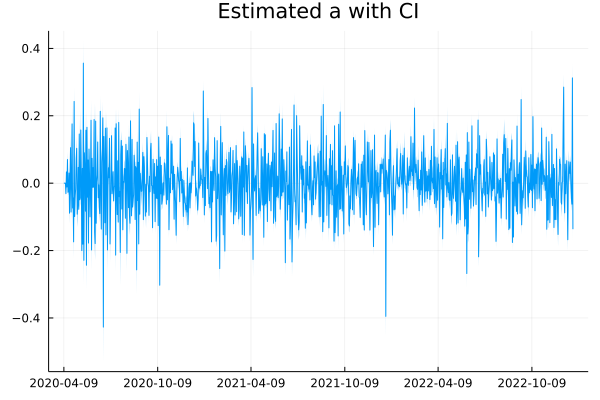

In [ ]:
@df adjusted_data plot(:Date, :astar, title = "Estimated a with CI",
                        ribbon = (:astar .- :lower_astar, :upper_astar .- :astar),
                        label = :none, 
                        xticks = (range(:Date[1], :Date[end], step = Month(6)),
    Dates.format.(range(:Date[1], :Date[end], step = Month(6)), "yyyy-mm-dd")))
#plot!(national_weekly.Date, national_weekly.Dct, alpha = 0.7, label = "Observed growth rate")
#png("astar_v2.png")

In [ ]:
@pipe DataFrame(y = Ut, x = lag(Ut)) |>
lm(@formula(y ~ x), _)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
────────────────────────────────────────────────────────────────────────────────
                    Coef.  Std. Error      t  Pr(>|t|)    Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────
(Intercept)   0.000378254  0.00447842   0.08    0.9327  -0.00840984   0.00916634
x            -0.245184     0.0302814   -8.10    <1e-14  -0.304605    -0.185762
────────────────────────────────────────────────────────────────────────────────

In [ ]:
# use GAS to filter I(1) from I(0)
T = 1000
eps = zeros(T)
pv = []
for j in 1:10000
    for i in 2:T
        eps[i] = eps[i-1] + rand(Normal(0, 0.5^2), 1)[1]
    end
    UUt = eps .+ rand(Normal(0, 1), T)
    push!(pv, pvalue(ADFTest(UUt, :none, 1)))
end
accuracy_adf = sum(pv .>= 0.05)/10000

0.2612

In [ ]:
function GAS01(par)
    beta = par[1]
    alpha = par[2]
    sigma = exp(par[3])
    a = zeros(eltype(par[1]), T)
    signal = zeros(eltype(par[1]), T)
    for i in 2:T
        a[i] = beta * a[i-1] + alpha * signal[i-1] / sigma
        signal[i] = UUt[i] - a[i]
    end
    return(a, signal, sigma)
end

function GASll(par)
    a, signal, sigma = GAS01(par)
    ll = - sum(log.(sigma.^2)) / 2 - sum( (signal./sigma).^2)/2  
end
res = optimize(x -> - GASll(x), [0.0, 0.001, -2.0],  
    LBFGS(); autodiff = :forward) 


 * Status: success

 * Candidate solution
    Final objective value:     4.325072e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 3.25e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.36e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.23e-12 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    41
    f(x) calls:    209
    ∇f(x) calls:   209


In [ ]:
par = Optim.minimizer(res)
par_var_cov = inv(-ForwardDiff.hessian(x -> GASll(x), par));
result_table = @pipe DataFrame(parameter = ["beta", "alpha", "sigma"],
            estimate = par,
            sd = sqrt.(diag(par_var_cov))) |>
            transform(_, [:sd, :estimate] => ((sd,es) -> 2 .* (1 .- cdf.(Normal.(0, sd), abs.(es)))) => :pvalue_2sided)

,parameter,estimate,sd,pvalue_2sided
,String,Float64,Float64,Float64
1,beta,0.991953,0.138606,8.26894e-13
2,alpha,23.873,41.8067,0.567978
3,sigma,3.82507,0.707107,6.32121e-8


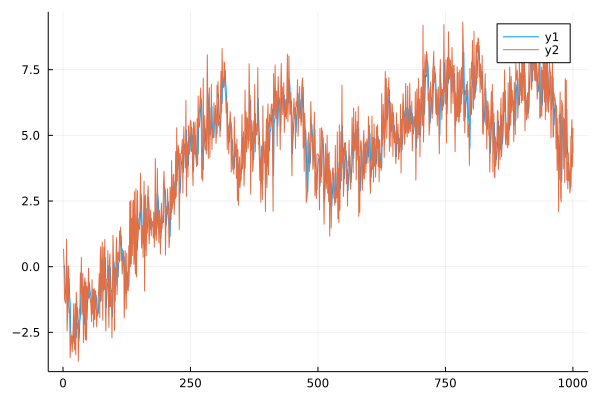

In [ ]:
a, Ut, sigma = GAS01(par)
plot(a)
plot!(UUt)


In [ ]:
ADFTest(a, :none, 1)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.00549047

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.1485

Details:
    sample size in regression:          998
    number of lags:                     1
    ADF statistic:                      -1.40689
    Critical values at 1%, 5%, and 10%: [-2.56798 -1.94127 -1.61656]


In [ ]:
Zt = rand(Normal(0,1), length(σ))
sigma = lead(sqrt(1/(6)) .* σ, 1)
U_tilde = Float64.( (sigma .* Zt .- 2 .* lag(sigma .* Zt, 1) .+ lag(sigma .* Zt, 2))[3:end-1] )
plot(acf(U_tilde))

In [ ]:
M = 2000
nstar = log(5800000)
ct = national_weekly.ct[(1 + nrow(national_weekly) - size(dMat)[1]):end]
nt = national_weekly.nt[(1 + nrow(national_weekly) - size(dMat)[1]):end]
cstar = ct .- β .* (nt .- nstar) 
rt = cstar .- lag(cstar, 5)
Rt = 1 .+ rt
Observed_rt = ct .- lag(ct, 5)
Observed_Rt = 1 .+ Observed_rt 
sim_MvNormal = rand(MvNormal(zeros(length(par)), I), M)
sim_β = Matrix(zeros(eltype(0.1), size(dMat)[1], M))
sim_astar = Matrix(zeros(eltype(0.1), size(dMat)[1], M))
sim_LogL = zeros(eltype(0.1), M)
sim_cstar_lower = Matrix(zeros(eltype([0.1, missing]), size(dMat)[1], M))
sim_cstar_upper = Matrix(zeros(eltype([0.1, missing]), size(dMat)[1], M))

sim_rt_lower = Matrix(zeros(eltype([0.1, missing]), size(dMat)[1], M))
sim_rt_upper = Matrix(zeros(eltype([0.1, missing]), size(dMat)[1], M))

for i in 1 : M
    simulated_para = sqrt(par_var_cov) * sim_MvNormal[:, i] + par
    simθstar_i, simastar_i, simUt_i, sim𝜆4a_i, sim∇4θ_i, simσ_i, simβ_i, sima_i = recoverTheta2(simulated_para, dMat)

    sim_astar[:, i] = simastar_i
    sim_β[:, i] = simβ_i
    sim_LogL[i] = logL2(simulated_para, dMat) 
    cstar_i = ct .- simβ_i .* (nt .- nstar) 
   
    sim_σt_Z_i = lead(sqrt(1/(6)) .* simσ_i, 1)  ## cannot recover σt, approx it by assuming small variation in last three days

    sim_σt_r_i = sqrt.( .+( lag(sim_σt_Z_i .^ 2 , 5), sim_σt_Z_i .^ 2 ) )

    sim_cstar_lower[:, i] = cstar_i .- 1.96 * sim_σt_Z_i 
    sim_cstar_upper[:, i] = cstar_i .+ 1.96 * sim_σt_Z_i

    sim_rt_lower[:, i] = cstar_i .- lag(cstar_i, 5) .- 1.96 .* sim_σt_r_i
    sim_rt_upper[:, i] = cstar_i .- lag(cstar_i, 5) .+ 1.96 .* sim_σt_r_i
end 

LR_col_index = 2 .* (logL2(par, dMat) .- sim_LogL) .< quantile(Chisq(length(par)), 0.95)
#lower_βstar = minimum(sim_β[:, LR_col_index], dims = 2)   
#upper_βstar = maximum(sim_β[:, LR_col_index], dims = 2)
lower_βstar = map(x -> quantile(sim_β[x, :], 0.05), collect(1:1:length(β)))
upper_βstar = map(x -> quantile(sim_β[x, :], 0.95), collect(1:1:length(β)))
lower_astar = minimum(sim_astar[:, LR_col_index], dims = 2)   
upper_astar = maximum(sim_astar[:, LR_col_index], dims = 2)
lower_cstar = minimum(sim_cstar_lower[:, LR_col_index], dims = 2)   
upper_cstar = maximum(sim_cstar_upper[:, LR_col_index], dims = 2)
lower_rt = minimum(sim_rt_lower[:, LR_col_index], dims = 2)   
upper_rt = maximum(sim_rt_upper[:, LR_col_index], dims = 2)
#lower_rt = lower_cstar .- lag(lower_cstar, 1)
#upper_rt = upper_cstar .- lag(upper_cstar, 1)
lower_Rt = 1 .+ lower_rt 
upper_Rt = 1 .+ upper_rt

adjusted_data = @pipe DataFrame(Date = national_truncated.Date,  #[(1 + nrow(national_weekly) - size(dMat)[1]):end],
                        β = β,
                        astar = astar,
                        bigCstar = exp.(cstar),
                        cstar = cstar,                       
                        rt = lead(rt, 12),
                        Rt = lead(Rt, 12),
                        Observed_rt = collect([[missing, missing, missing] ; rollmean(lead(Observed_rt, 12), 7); [missing, missing, missing]]),
                        Observed_Rt = collect([[missing, missing, missing] ; rollmean(lead(Observed_Rt, 12), 7); [missing, missing, missing]]),
                        lower_βstar =lower_βstar, #[:, 1],
                        upper_βstar = upper_βstar, #[:, 1],
                        lower_astar = lower_astar[:, 1],
                        upper_cstar = upper_cstar[:, 1],
                        lower_cstar = lower_cstar[:, 1],
                        upper_astar = upper_astar[:, 1],
                        lower_bigCstar = exp.(lower_cstar[:, 1]),
                        upper_bigCstar = exp.(upper_cstar[:, 1]),
                        lower_rt = lead(lower_rt, 12)[:, 1],
                        upper_rt = lead(upper_rt, 12)[:, 1],
                        lower_Rt = lead(lower_Rt, 12)[:, 1],
                        upper_Rt = lead(upper_Rt, 12)[:, 1]) |>
                        dropmissing(_);

In [ ]:
lower_β = minimum(sim_β, dims = 2)   
upper_β = maximum(sim_β, dims = 2)
plot([lower_β, upper_β], color = :blue, label = :none)
plot!(sim_β[:, LR_col_index .== 1], color = :pink, label = :none)


In [ ]:
lower_β = minimum(sim_β, dims = 2)   
upper_β = maximum(sim_β, dims = 2)
plot([lower_β, upper_β], color = :blue, label = :none)
plot!(sim_β[:, LR_col_index .== 0], color = :pink, label = :none)

In [ ]:
ct = national_weekly.ct[(1 + nrow(national_weekly) - size(dMat)[1]):end]
nt = national_weekly.nt[(1 + nrow(national_weekly) - size(dMat)[1]):end]
cstar1 = ct .- β .* (nt .- log(100000)) 
cstar10 = ct .- β .* (nt .- log(1000000)) 
cstar58 = ct .- β .* (nt .- log(5800000)) 

dd = DataFrame(Date = national_weekly.Date[(1 + nrow(national_weekly) - size(dMat)[1]):end], 
        rt1 = cstar1 .- lag(cstar1, 5),
        rt10 = cstar10 .- lag(cstar10, 5),
        rt58 = cstar58 .- lag(cstar58, 5))

@df dd[200:end,:] plot(:Date, [:rt1 :rt10 :rt58], label = ["10k" "100k" "580k"], title = "Estimated daily growth rate")
hline!([0], color = :red, label = :none)
#png("robust.png")

In [ ]:
nstar = log(100000)
cstar = ct .- β .* (nt .- nstar)
Ind_Week_data = select(national, [:firstD, :Day, :Nt, :Ct])

Ind_Week_σ = @pipe leftjoin(national, DataFrame(Date = national_truncated.Date, σ = sqrt(7/6) .* σ), on = :Date) |>
    select(_, [:firstD, :Day, :σ]) |>
    transform(_, :σ => (x -> x .^ 2) => :σ2) |>
    data_wider(_, "σ2") |>
    select(_, :firstD => :Date , :weekSum => :σ2) |>
    select(_, :Date, :σ2 => (x -> sqrt.(x)) => :σ) 

Ind_Week_β = @pipe leftjoin(national, DataFrame(Date = national_truncated.Date, β = β), on = :Date) |>
    select(_, [:firstD, :Day, :β]) |>
    data_wider(_, "β") |>
    select(_, :firstD => :Date , :weekSum => (x -> x ./7) => :β)

adjusted_data = @pipe leftjoin(select(data_wider(Ind_Week_data, "Nt"), :firstD => :Date , :weekSum => (x -> log.(x)) => :nt),
        select(data_wider(Ind_Week_data, "Ct"), :firstD => :Date, :weekSum => (x -> log.(x)) => :ct),
        on = :Date) |>
        leftjoin(_, Ind_Week_σ, on = :Date) |>
        leftjoin(_, Ind_Week_β, on = :Date) |>
        transform(_, [:ct, :nt, :β] => ((c, n, b) -> c .- b .* (n .- nstar)) => :cstar) |>
        transform(_, :cstar => (x -> (x .- lag(x))/7 ) => :rt,
        :σ => (x -> sqrt.(x .^ 2 .+ lag(x) .^ 2)/7 ) => :rt_σ) |>
        transform(_, :rt => (x -> exp.(4.7 .* x)) => :Rt,
                    [:rt, :rt_σ] => ((x, s) -> exp.(4.7 .* (x .- 1.96 .* s))) => :Rt_lower,
                    [:rt, :rt_σ] => ((x, s) -> exp.(4.7 .* (x .+ 1.96 .* s))) => :Rt_upper) |>
        dropmissing(_)
                    
@df adjusted_data plot(:Date, :rt, ribbon = 1.96 .* :rt_σ )

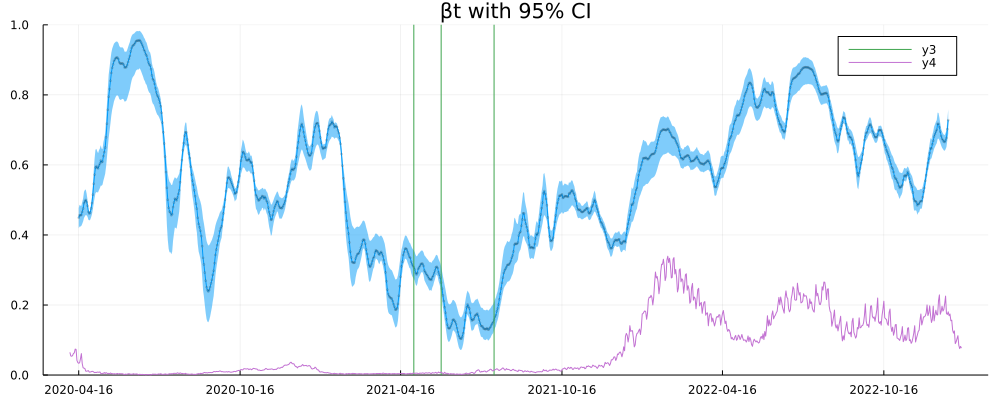

In [ ]:
@df adjusted_data[8:end, :] plot(:Date, :β, title = "βt with 95% CI", size = (1000, 400),
                        ribbon = (:β .- :lower_βstar, :upper_βstar .- :β),
                        label = :none, ylim = (0,1),
                        xticks = (range(:Date[1], :Date[end], step = Month(6)),
    Dates.format.(range(:Date[1], :Date[end], step = Month(6)), "yyyy-mm-dd")))
@df adjusted_data[8:end, :] scatter!(:Date, :β, label = :none,
marker = (:circle, 1, 0.2, :skyblue ))
vline!([Date("2021-05-01"), Date("2021-06-01"), Date("2021-07-31")])
plot!(national_truncated.Date, national_truncated.PosRate)
#png("GAS_beta2.png")  

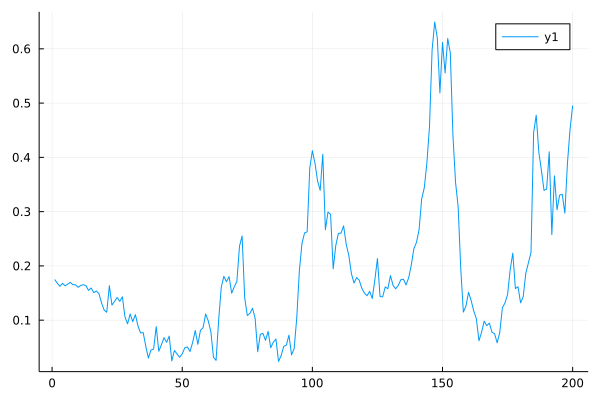

In [ ]:
@pipe map(x -> pvalue(ADFTest(astar[x : x+100], :none, 1)), collect(1:1:200)) |>
plot(_)

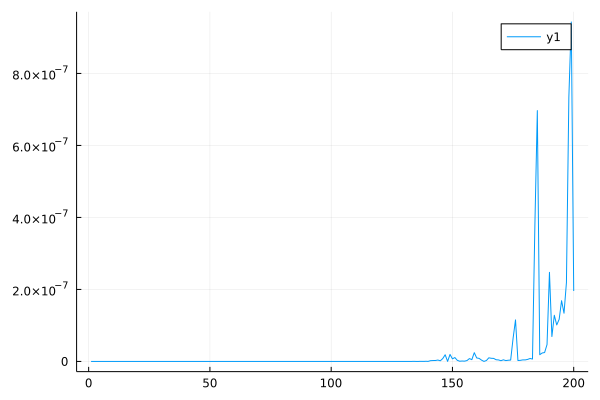

In [ ]:
@pipe map(x -> pvalue(ADFTest(Ut[x : x+100], :none, 1)), collect(1:1:200)) |>
plot(_)

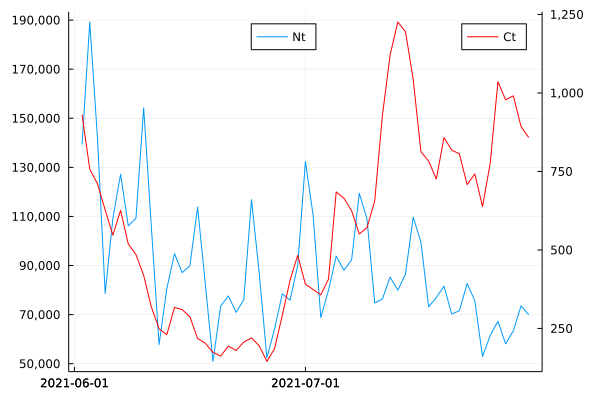

In [ ]:
@pipe filter(:Date => (x -> x > Date("2021-06-01") && x < Date("2021-07-31")), national_truncated) |>
@df _ plot(:Date, :Nt, 
        label = "Nt", leg = :top,right_margin = 50px,
        yticks = (collect(50000:20000:190000), ["50,000", "70,000", "90,000", "110,000", "130,000", "150,000", "170,000", "190,000"]))
@pipe filter(:Date => (x -> x > Date("2021-06-01") && x < Date("2021-07-31")), national_truncated) |>
@df _ plot!(twinx(), :Date, :Ct, yticks = (collect(250:250:1250), ["250", "500", "750", "1,000", "1,250"]),
        label = "Ct", color = :red)

In [ ]:
x = zeros(1000)
y = rand(Normal(0,1), 1000)
for i in 2:1000
    x[i] = x[i-1] + rand(Normal(0,1), 1)[1] * 0.1
end
ADFTest(rollmean(y, 10), :none, 1)

In [ ]:
ws = 11
data_for_this_chunk = DataFrame(Date = adjusted_data.Date[Int((ws-1)/2) : Int(end-(ws+1)/2)],
                                rt = rollmean(adjusted_data.rt, ws),
                                Observed_rt = rollmean(adjusted_data.Observed_rt, ws),
                                lower_rt = rollmean(adjusted_data.lower_rt, ws),
                                upper_rt = rollmean(adjusted_data.upper_rt, ws),
                                Observed_Rt = rollmean(adjusted_data.Observed_Rt, ws),
                                Rt = rollmean(adjusted_data.Rt, ws),
                                lower_Rt = rollmean(adjusted_data.lower_Rt, ws),
                                upper_Rt = rollmean(adjusted_data.upper_Rt, ws))

@df data_for_this_chunk[200:end, :] plot(:Date, :Rt, title = "Estimated Rt with 95% CI", 
                        ribbon = (:Rt .- :lower_Rt, :upper_Rt .- :Rt),
                        leg = :bottomright, label = :none,
                        xticks = (range(:Date[1], :Date[end], step = Month(6)),
    Dates.format.(range(:Date[1], :Date[end], step = Month(6)), "yyyy-mm-dd")))
@df data_for_this_chunk[200:end, :] plot!(:Date, :Observed_Rt, label = "Observed Rt")
hline!([1], color = :red, label = :none)
#png("Rt.png")

In [ ]:
density((national_weekly.nt .- lag(national_weekly.nt, 1))[6:end], 
label = "Daily change in nt", title = "Density plot")
density!((β .- lag(β, 1))[6:end], label = "Daily change in βt")
#png("n_b_density.png")

In [ ]:
@df filter(:Date => (x -> x > Date("2020-10-01")), adjusted_data) plot(:Date, :cstar, title = "Estimated c*",
                        ribbon = (:cstar .- :lower_cstar, :upper_cstar .- :cstar),
                        label = :none, 
                        xticks = (range(:Date[1], :Date[end], step = Month(6)),
    Dates.format.(range(:Date[1], :Date[end], step = Month(6)), "yyyy-mm-dd")))
@df filter(:Date => (x -> x > Date("2020-10-01")), national_weekly) plot!(:Date, :ct, label = "Observed ct")
#png("cstar.png")

In [ ]:
@df adjusted_data plot(:Date, :astar, title = "Estimated a*",
                        ribbon = (:astar .- :lower_astar, :upper_astar .- :astar),
                        label = :none, 
                        xticks = (range(:Date[1], :Date[end], step = Month(6)),
    Dates.format.(range(:Date[1], :Date[end], step = Month(6)), "yyyy-mm-dd")))

#png("astar_v2.png")

In [ ]:
Amat = Matrix([ [-2, 1, 0, 0, 0, 0, 1] [1,-2,1,0,0,0,1] [0, 1, -2, 1, 0, 0, 1] [0,0,1,-2,1,0,1] [0,0,0,1,-2,1,1] [0,0,0,0,1,-2,1] [1,0,0,0,0,1,1] ])
Lambda_Matrix = Matrix(zeros(eltype(0.01), size(𝜆4a)[1], 7))
Lambda_Vector = zeros(eltype(0.01), size(𝜆4a)[1])

    for i in 1:size(𝜆4a)[1]
        # x_vector = inv(Amat) * [𝜆4a[i, 2:7]; 0]

        x_vector = exp.(inv(Amat) * [𝜆4a[i, 2:7]; 0])
        
        Lambda_Matrix[i, :] = x_vector
    
        Lambda_Vector[i] = x_vector[data.Day[i]] 
    end

𝜆DF = @pipe DataFrame(Lambda_Matrix, :auto) |>  
    DataFrames.rename(_, ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]) |>
    insertcols!(_, :Date => national_truncated.Date[(1 + nrow(national_truncated) - size(dMat)[1]):end]) |>
    #insertcols!(_, :Lambda_Vector => Lambda_Vector) |>
    delete!(_, 1:7)

@df 𝜆DF plot(:Date, [:Mon :Tue :Wed :Thu :Fri :Sat :Sun], 
    title = "Estimated lambda",  leg = :outerright,
    xticks = (range(𝜆DF.Date[1], 𝜆DF.Date[end], step = Month(6)),
    Dates.format.(range(𝜆DF.Date[1], 𝜆DF.Date[end], step = Month(6)), "yyyy-mm-dd")))
#png("lambda.png")

In [ ]:
histogram(prod(exp.(Matrix(𝜆DF[:, 1:7])), dims=2))

In [ ]:
function season_plot(data, which_year, which_series)
    @pipe data |> filter(:Year => x -> x == which_year, _) |>
    groupby(_, [:Month, :Day]) |>
    combine(_, :($which_series) => mean => :bar) |>
    sort!(_, [:Day, :Month]) |>
    @df _ plot(:Day, :bar, 
    group = :Month,
    xticks = (1:7, Dates.dayname.(1:7)),
    label = :none,
    #ylabel = which_series,
    xrotation = 45,
    title = which_year);
end
season_plot(national_weekly, 2022, "D2ct")

In [ ]:
function season_plot(data, which_year, which_series)
    @pipe data |> filter(:Year => x -> x == which_year, _) |>
    groupby(_, [:Month, :Day]) |>
    combine(_, :($which_series) => mean => :bar) |>
    sort!(_, [:Day, :Month]) |>
    @df _ plot(:Day, :bar, 
    group = :Month,
    xticks = (1:7, Dates.dayname.(1:7)),
    label = :none,
    #ylabel = which_series,
    xrotation = 45,
    title = which_year);
end
Ori_x = national_truncated.nt
Ori_y = national_truncated.ct
original_Ut = Ori_y .- β .* Ori_x .- Lambda_Vector
new_results = DataFrame(Date = data.Date, β=β, a = astar, Ut = original_Ut, pr = data.PosRate, Year = data.Year, Month = data.Month, Day = data.Day)
p1 = season_plot(new_results, 2020, "β")
p2 = season_plot(new_results, 2021, "β")
p3 = season_plot(new_results, 2022, "β")

plot(p1, p2, p3, 
    layout = (1, 3), size = (900, 300), bottom_margin = 30px)

In [ ]:
density(Ut)
plot!(Normal(mean(Ut), std(Ut)))

In [ ]:
Zt = randn(length(σ)) .* σ
Ut2 = Zt .- runmean(Zt, 7)
density(Ut2)
plot!(Normal(mean(Ut2), std(Ut2)))

In [ ]:
# This function is to test the effect of N* on Rt
ct = national_truncated.ct
nt = national_truncated.nt
function NstarRt(Nstar, ws)
    nstar = log(Nstar)

    a = map(x -> collect(skipmissing( 
        (ct .- lag(ct, ws)) .+ (nstar .- nt) .* x .- (nstar .- lag(nt, ws)) .* lag(x, ws)  )), 
            eachcol(simβ))

    simrt = reduce(hcat,a)
    lowerrt = minimum(simrt[:, LR_col_index], dims = 2)
    upperrt = maximum(simrt[:, LR_col_index], dims = 2)
    lowerRt = exp.(4.7/ws .* lowerrt)
    upperRt = exp.(4.7/ws .* upperrt)
    rt1 = collect(skipmissing(ct .- lag(ct, ws)))
    rt2 = collect(skipmissing((nstar .- nt) .* βasθ.(θstar) .- (nstar .- lag(nt, ws)) .* lag(βasθ.(θstar), ws)))
    rt = rt1 .+ rt2
    Rt = exp.(4.7/ws .* rt)
    return( rt, lowerrt, upperrt, 
            Rt, lowerRt, upperRt, rt1, rt2)
end

In [ ]:
Nstar = 100000
ws =7
rt, lowerrt, upperrt, Rt, lowerRt, upperRt, rt1, rt2 = NstarRt(Nstar, ws)
rt1plus = rt1 .* (rt1 .> 0)
rt1minus = rt1 .* (rt1 .< 0)
rt2plus = rt2 .* (rt2 .> 0)
rt2minus = rt2 .* (rt2 .< 0)
observedRt =collect(skipmissing( exp.(4.7/ws .* (national_truncated.ct - lag(national_truncated.ct, ws))) ))
p1 = plot(zeros(length(rt1)), ribbon = (abs.(rt1minus), rt1plus), 
      ylim = (-1.5, 1.5),
      color = :skyblue, label = "Observed weekly growth rate")
plot!(zeros(length(rt1)), ribbon = (abs.(rt2minus), rt2plus),  
      color = :salmon, label = "Adjustment")
plot!(rt, label = "Observed + Adjustment", color = :grey)
p2 = plot(Rt, ribbon = (Rt .- lowerRt, upperRt .- Rt), label = "Adjusted Rt")
    plot!(observedRt, label = "Observed Rt")
    #plot!(exp.(4.7 .* rollmean(Ut, ws)), color = :green)
plot(p1, p2, layout = (2,1), size = (600, 700) )
# the Rt here is derived from C*(N*)
#png("10w.png")

In [ ]:
Nstar = 5800000
ws = 7
observedRt =collect(skipmissing( exp.(4.7/ws .* (national_truncated.ct - lag(national_truncated.ct, ws))) ))
rt, lowerrt, upperrt, Rt, lowerRt, upperRt, rt1, rt2 = NstarRt(Nstar, ws)
rt1plus = rt1 .* (rt1 .> 0)
rt1minus = rt1 .* (rt1 .< 0)
rt2plus = rt2 .* (rt2 .> 0)
rt2minus = rt2 .* (rt2 .< 0)
p1 = plot(zeros(length(rt1)), ribbon = (abs.(rt1minus), rt1plus), 
      ylim = (-1.5, 1.5),
      color = :skyblue, label = "Observed weekly growth rate")
plot!(zeros(length(rt1)), ribbon = (abs.(rt2minus), rt2plus),  
      color = :salmon, label = "Adjustment")
plot!(rt, label = "Observed + Adjustment", color = :grey)
p2 = plot(Rt, ribbon = (Rt .- lowerRt, upperRt .- Rt), #ylim = (0.5, 3),
     label = "Adjusted Rt")
    plot!(observedRt, label = "Observed Rt")
plot(p1, p2, layout = (2,1), size = (600, 700) )
#png("580w.png")

In [ ]:
# daily Ut is (roughly) equal to estimated daily growth rate
ws = 14
plot(national_truncated.Date[1:(end-6)], exp.(4.7 .* rollmean(Ut, 7)), 
    color = :skyblue, ylim = (0, 2.5), size = (600, 350))
#plot!(national_truncated.Date[1:(end-13)], exp.(4.7 .* rollmean(Ut, 14)), color = :pink)
#plot!(national_truncated.Date[1:(end-27)], exp.(4.7 .* rollmean(Ut, 28)), color = :lightgreen)
hline!([1], label = :none)

In [ ]:
∇DF = @pipe DataFrame(∇4θ, :auto) |>
    DataFrames.rename(_, ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]) |>
    DataFrames.transform(_,  All() => ByRow(+) => :Sum) |>
    insertcols!(_, :Date => data.Date) |>
    delete!(_, 1:6)
@df ∇DF density( :Thu, label = :none, ylabel = "density") 
    vline!([0])

In [ ]:
new_results = @pipe DataFrame(Date = data.Date, Day = data.Day, Month = data.Month, Year = data.Year,
    Ct = data.Ct, Dnt = data.Dnt, β = β, #lowerβ = vec(lowerβ), upperβ = vec(upperβ),
    θstar = θstar, Ut = Ut, βstar = βasθ.(θstar), σ = σ) |>
    DataFrames.transform(_, :βstar => (x -> data.Ct .* (Nstar ./data.Nt) .^ x) => :Cstar) |>
    DataFrames.transform(_, :Cstar => (v -> runmean(v, windowsize) * windowsize) => :rollSumCstar) |>
    DataFrames.transform(_, :rollSumCstar => (x -> lag(x, 1)) => :rollSumCstarlag) |>
    dropmissing(_) |>
    DataFrames.transform(_, [:rollSumCstar, :rollSumCstarlag] => ((x, y) -> exp.(4.7 .* log.(x./y))) => :rollRt);

In [ ]:
data1 = filter(:Day => x -> x == 3, new_results)
data2 = filter(:Day => x -> x == 3, national_truncated)
p1 = @df new_results plot(:Date, :Ut, label = :none, ylabel = "Ut") 
    hline!([0])
#p3 = @df ∇DF density( :Thu, label = :none, ylabel = "density") 
#    vline!([0])
p2 = @df national_truncated plot(:Date, :Dnt, label = :none, ylabel = "Dnt")
    hline!([0])
#p4 = @df ∇DF plot(:Date, :Thu, label = :none, ylabel = "score")
#    hline!([0])
plot(p1, p2, #p4, p3,
    layout = (2,1), size = (600, 600), left_margin = 60px,
    xticks = (range(data1.Date[1], data1.Date[end], step = Month(3)),
            Dates.format.(range(data1.Date[1], data1.Date[end], step = Month(3)),
            "yyyy-mm-dd")), 
    xrotation = 30)

Previous model:
$$
\theta_{t+1} = \omega + \phi \theta_t + \alpha \psi_t(\theta_t)
$$
where
$$
\psi_t(\theta_t) =
\frac{\frac{\partial \ell}{\partial \theta_t}}{\sqrt{- \frac{\partial^2 \ell}{\partial \theta_t^2}}}
=
\frac{1}{\sigma_t} \text{sign}(x_t) \left(y_t -  \frac{x_t}{1 + \exp(-\theta_t)} \right)
$$
Now change to:
$$
\theta^*_{t+1} = \omega + \phi \theta^*_t + 
\frac{\alpha}{\sqrt{7}}  \iota' ∇_t
$$
where
$\iota = [1, 1, 1, 1, 1, 1, 1]'$,
$$
∇_t = 
\begin{bmatrix}
\psi_t(\theta^*_t + \lambda_{t,\ D(t)} )\\
\psi_{t-1}(\theta^*_t + \lambda_{t,\ D(t-1)} ) \\
\psi_{t-2}(\theta^*_t + \lambda_{t,\ D(t-2)} ) \\
\psi_{t-3}(\theta^*_t + \lambda_{t,\ D(t-3)} ) \\
\psi_{t-4}(\theta^*_t + \lambda_{t,\ D(t-4)} ) \\
\psi_{t-5}(\theta^*_t + \lambda_{t,\ D(t-5)} ) \\
\psi_{t-6}(\theta^*_t + \lambda_{t,\ D(t-6)} )
\end{bmatrix}
\text{  and    }
 D(t) = 
\begin{cases}
    1, & \text{if $t$ is a Monday}.\\
    2, & \text{if $t$ is a Tuesday}. \\
    3, & \text{if $t$ is a Wedesday}. \\
    4, & \text{if $t$ is a Thursday}. \\
    5, & \text{if $t$ is a Friday}. \\
    6, & \text{if $t$ is a Saturday}. \\
    7, & \text{if $t$ is a Sunday}.
\end{cases}
$$
Add one more equation to update $\lambda_t$.
$$
\lambda_{t+1} = \lambda_t + \tilde{\alpha} P_{\iota, \perp} ∇_t
$$
where $\iota' \lambda_t = 0$ and 
$P_{\iota, \perp} = I - \iota (\iota' \iota)^{-1} \iota'$.

In [ ]:
# accelerate score attempt, doesn't work well
# if NaN, check initial values (σ)
βasθ(θ) = 1 / (1 + exp(-θ)) 
θasβ(β) = log((β ) / (1 - β))
iota = [1; 1; 1; 1; 1; 1; 1]
Pi⊥ = I - iota * inv(iota' * iota) * iota'
function recoverTheta2(par, data) 
    y = data[:, 1]
    x = data[:, 2]
    day = Int64.(data[:, 3]) # a number from 1 to 7 represents Mon to Sun
    T = size(data)[1]
    𝜆 = Matrix(zeros(eltype(par[1]), T, 7)) # 7 columns are Mon to Sun
    ∇ = Matrix(zeros(eltype(par[1]), T, 7))  # the types here are very important in order to do forward.diff
    θstar = zeros(eltype(par[1]), T)
    Ut = zeros(eltype(par[1]), T)
    σ = zeros(eltype(par[1]), T)
    ft = zeros(eltype(par[1]), T+1)
    αt = zeros(eltype(par[1]), T)
# start from the 7th observation
    𝜆[7, :] = Pi⊥ * [par[1]; par[2]; par[3]; par[4]; par[5]; par[6]; par[7]]
    θstar[7] = par[8] 
    σ[1] = par[9]
    ω = par[10]
    ϕ = βasθ(par[11])
    α = par[12] 
    αtilde = par[13]
    ϕtilde = βasθ(par[14])
    ω4σ = βasθ(par[15]) 
    ϕ4σ = βasθ(par[16])
    α4σ = βasθ(par[17])

    ft[8] = par[18]
    ωf = par[19]
    ϕf = 0  #par[20]
    αf = par[21]

    Ut[1:7] = y[1:7] .- x[1:7] .* (βasθ(θstar[7]) .+ 𝜆[7, day[1:7]])
    σ[2] = sqrt(ω4σ + ϕ4σ * σ[1]^2 + α4σ * ( Ut[1] )^2)
    σ[3] = sqrt(ω4σ + ϕ4σ * σ[2]^2 + α4σ * ( Ut[2] )^2)
    σ[4] = sqrt(ω4σ + ϕ4σ * σ[3]^2 + α4σ * ( Ut[3] )^2)
    σ[5] = sqrt(ω4σ + ϕ4σ * σ[4]^2 + α4σ * ( Ut[4] )^2)
    σ[6] = sqrt(ω4σ + ϕ4σ * σ[5]^2 + α4σ * ( Ut[5] )^2)
    σ[7] = sqrt(ω4σ + ϕ4σ * σ[6]^2 + α4σ * ( Ut[6] )^2)
    σ[8] = sqrt(ω4σ + ϕ4σ * σ[7]^2 + α4σ * ( Ut[7] )^2)

    ∇[1, day[(1:7)]] = (1 ./ σ[1:7]) .* sign.(x[1:7]) .* Ut[1:7]
    ∇[2, day[(1:7)]] = (1 ./ σ[1:7]) .* sign.(x[1:7]) .* Ut[1:7]
    ∇[3, day[(1:7)]] = (1 ./ σ[1:7]) .* sign.(x[1:7]) .* Ut[1:7]
    ∇[4, day[(1:7)]] = (1 ./ σ[1:7]) .* sign.(x[1:7]) .* Ut[1:7]
    ∇[5, day[(1:7)]] = (1 ./ σ[1:7]) .* sign.(x[1:7]) .* Ut[1:7]
    ∇[6, day[(1:7)]] = (1 ./ σ[1:7]) .* sign.(x[1:7]) .* Ut[1:7]
    ∇[7, day[(1:7)]] = (1 ./ σ[1:7]) .* sign.(x[1:7]) .* Ut[1:7]

    αt[7] = ϕtilde * βasθ(ft[8])
     
    
    for i in 8 : (T-1)

        θstar[i] = ω + ϕ * θstar[i-1] + α / sqrt(7) * iota' * ∇[i-1, :]
        
        𝜆[i, :] =  ϕtilde * 𝜆[i-1, :] + αt[i-1] * Pi⊥ * ∇[i-1, :]  # αt[i-1]

        σ[i] = sqrt(ω4σ + ϕ4σ * σ[i-1]^2 + α4σ * ( Ut[i-1] )^2)

        ∇[i, day[(i-6):i]] =
        (1 ./ σ[(i-6):i]) .* sign.(x[(i-6):i]) .*
        ( y[(i-6):i] .- x[(i-6):i] .* (βasθ(θstar[i])  .+ 𝜆[i, day[(i-6):i]]) )

        Ut[i] = y[i] - x[i] * (βasθ(θstar[i]) + 𝜆[i, day[i]])

        ft[i + 1] = ωf + ϕf*ft[i] + αf* Ut_1st[i+1]*Ut_1st[i-6] *(1/σ_1st[i+1]) * (1/σ_1st[i-6])
        #ft[i + 1] = ωf + ϕf*ft[i] + αf* ∇[i, day[i]] * ∇[i-1, day[i]]
        
        αt[i] = ϕtilde * βasθ(ft[i+1])

    end
    σ[T] = σ[T-1]
    return (θstar, Ut, 𝜆, ∇, σ, αt)
end

function logL2(par, data)
    θstar, Ut, 𝜆, ∇, σ, αt = recoverTheta2(par, data) 
    ll = - sum(log.(σ.^2)) / 2 - sum( (Ut./σ).^2)/2  
    return(ll)
end
data = copy(national_truncated)
dMat = Matrix(select(data, :Dct, :Dnt, :Day))
res = optimize(x -> - logL2(x, dMat), [0.0, 0, 0, 0, 0, 0, 0, # initial values of 𝜆
        0,   # initial θstar
        0.13,   # initial σ,
        0, 3, 0.01,   # omega, phi, alpha
        0.01, 3,    # alpha tilde, phi tilde
        -8, 3, -2,    # ω4σ, ϕ4σ, α4σ,
        -3, 0, 3, 0.01] , # accelerate
    LBFGS(),Optim.Options(show_trace=false, iterations = 5000); autodiff = :forward) 

In [ ]:
f(x) = data.Ct[7:end] .* ( (x ./data.Nt[7:end]) .^ new_results.βstar )
Cstar_mat = [f(100000) f(500000) f(1000000) f(5800000)]
plot(new_results.Date, Cstar_mat, 
    yaxis = :log, label = :none, ylabel = "C*", title = "Different N*",
    xticks = (range(new_results.Date[1], new_results.Date[end], step = Month(3)),
            Dates.format.(range(new_results.Date[1], new_results.Date[end], step = Month(3)),
            "yyyy-mm-dd")),
    xrotation = 30, size = (600, 400))

In [ ]:
@df new_results plot(:Date, :Death ./ :Cstar, label = :none, title = "Death Rate per C*")

In [ ]:
@df new_results scatter(:Date, :logDeath, 
    ylim = (-0.1,4), label = :none, ylabel = "log(Death)",
    color = :pink, size = (700, 350), alpha = 0.8,
    left_margin = 20px, right_margin = 60px, 
    xrotation = 30, bottom_margin = 20px, markersize = 2,
    xticks = (range(:Date[1], :Date[end], step = Month(3)), 
            Dates.format.(range(:Date[1], :Date[end], step = Month(3)), "yyyy-mm-dd"))) # death = zero are omitted on graph
@df new_results plot!(twinx(), :Date, lag(:Cstar, 20), xticks = :none,
    yaxis = :log, label = :none, ylabel = "log(C*) lag by 20 days")

In [ ]:
p2 = @df ∇DF plot(:Date, :Mon, label = :none, ylabel = "Mon")
p3 = @df ∇DF plot(:Date, :Tue, label = :none, ylabel = "Tue")
p4 = @df ∇DF plot(:Date, :Wed, label = :none, ylabel = "Wed")
p5 = @df ∇DF plot(:Date, :Thu, label = :none, ylabel = "Thu") 
hline!([0])
p6 = @df ∇DF plot(:Date, :Fri, label = :none, ylabel = "Fri")
p7 = @df ∇DF plot(:Date, :Sat, label = :none, ylabel = "Sat")
p8 = @df ∇DF plot(:Date, :Sun, label = :none, ylabel = "Sun")
p9 = @df ∇DF plot(:Date, :Sum, label = :none, ylabel = "Sum")
plot(p2, p3, p4, p5, p6, p7, p8, p9,
    layout = (9,1), size = (600, 2200), left_margin = 60px,
    xticks = (range(new_results.Date[1], new_results.Date[end], step = Month(4)),
            Dates.format.(range(new_results.Date[1], new_results.Date[end], step = Month(4)),
            "yyyy-mm-dd")))

In [ ]:
data = new_results
p1 = @df filter(:Day => x -> x == 1, data) plot(:Date, :Ut, label = :none, ylabel = "Mon") 
    hline!([0])
p2 = @df filter(:Day => x -> x == 2, data) plot(:Date, :Ut, label = :none, ylabel = "Tue") 
hline!([0])
p3 = @df filter(:Day => x -> x == 3, data) plot(:Date, :Ut, label = :none, ylabel = "Wed") 
hline!([0])
p4 = @df filter(:Day => x -> x == 4, data) plot(:Date, :Ut, label = :none, ylabel = "Thur") 
hline!([0])
p5 = @df filter(:Day => x -> x == 5, data) plot(:Date, :Ut, label = :none, ylabel = "Fri") 
hline!([0])
p6 = @df filter(:Day => x -> x == 6, data) plot(:Date, :Ut, label = :none, ylabel = "Sat") 
hline!([0])
p7 = @df filter(:Day => x -> x == 7, data) plot(:Date, :Ut, label = :none, ylabel = "Sun") 
hline!([0])
plot(p1, p2, p3, p4, p5, p6, p7, 
    layout = (7,1), size = (600, 1800), left_margin = 60px,
    xticks = (range(new_results.Date[1], new_results.Date[end], step = Month(6)),
            Dates.format.(range(new_results.Date[1], new_results.Date[end], step = Month(4)),
            "yyyy-mm-dd")))

In [ ]:
data = new_results
p1 = @df filter(:Day => x -> x == 1, data) density(:Ut, label = :none, ylabel = "Mon") 
    vline!([0])
p2 = @df filter(:Day => x -> x == 2, data) density( :Ut, label = :none, ylabel = "Tue") 
vline!([0])
p3 = @df filter(:Day => x -> x == 3, data) density(:Ut, label = :none, ylabel = "Wed") 
vline!([0])
p4 = @df filter(:Day => x -> x == 4, data) density( :Ut, label = :none, ylabel = "Thur") 
vline!([0])
p5 = @df filter(:Day => x -> x == 5, data) density( :Ut, label = :none, ylabel = "Fri") 
vline!([0])
p6 = @df filter(:Day => x -> x == 6, data) density( :Ut, label = :none, ylabel = "Sat") 
vline!([0])
p7 = @df filter(:Day => x -> x == 7, data) density( :Ut, label = :none, ylabel = "Sun") 
vline!([0])
plot(p1, p2, p3, p4, p5, p6, p7, 
    layout = (7,1), size = (600, 1800), left_margin = 60px,
    xticks = (range(new_results.Date[1], new_results.Date[end], step = Month(6)),
            Dates.format.(range(new_results.Date[1], new_results.Date[end], step = Month(4)),
            "yyyy-mm-dd")))

# Part 2, Municipality

In [ ]:
# Remove Municipalities with too few Nt (< 500 on average) 
# 50 cities remained
http_muni_ct = HTTP.get("https://raw.githubusercontent.com/shuofanzhang/covid/main/Municipality_cases_time_series.csv")
http_muni_nt = HTTP.get("https://raw.githubusercontent.com/shuofanzhang/covid/main/Municipality_tested_persons_time_series.csv")
muni_population = @pipe CSV.File(HTTP.get("https://raw.githubusercontent.com/shuofanzhang/covid/main/population.csv").body) |> 
        DataFrame |>
        DataFrames.rename!(_, :Population => :Nstar) |>
        DataFrames.transform(_, :Nstar => (x -> log.(x)) => :nstar)


muni_Nt_0 = @pipe CSV.File(http_muni_nt.body, footerskip=1) |> 
    DataFrame |>
    DataFrames.rename!(_, :PrDate_adjusted => :Date) 

common_cities = muni_population.Municipality[in(names(muni_Nt_0)).(muni_population.Municipality)]

#drop_cities = @pipe muni_Nt_0 |> 
#        #subset(_, :Date => ByRow(D -> D >= date_of_first_obs)) |>
#        select(_, Not(:Date)) |>
#        _[:, mean.(eachcol(_)) .<= 500] |>  
#        names(_)

#drop_cities = ["Christiansø", "Ærø", "Fanø", "Samsø", "Læsø", "NA"]

muni_Ct = @pipe CSV.File(http_muni_ct.body, footerskip=1) |>
    DataFrame |>
    rename!(_, :SampleDate => :Date) |>
    #select(_, Not(drop_cities))
    select(_, "Date", common_cities)

#muni_Nt = select(muni_Nt_0, Not(drop_cities))
muni_Nt = select(muni_Nt_0, "Date", common_cities)

muni_daily_level = @pipe innerjoin(muni_Ct, muni_Nt, on = :Date, makeunique=true);
## Notes: The orders of the columns in the two files are different.

# create daily Dnt and Dct data for model
muni_ct_nt = @pipe muni_daily_level |>
DataFrames.transform(_, names(_, Not(:Date)) .=> (x -> log.(x)); renamecols=false);
for col in eachcol(muni_ct_nt)
    replace!(col, -Inf => 0)  # When initial numbers are 0, replace log of it to be 0 instead of -inf.
end
muni_daily = @pipe muni_ct_nt |> 
DataFrames.transform(_, names(_, Not(:Date)) .=> (x -> x - lag(x)); renamecols=false)|>
dropmissing(_) |>
subset(_, :Date => ByRow(D -> D >= date_of_first_obs));
muni_ct_nt = subset(copy(muni_ct_nt), :Date => ByRow(D -> D >= date_of_first_obs));
muni_Nt = subset(copy(muni_Nt), :Date => ByRow(D -> D >= date_of_first_obs));
muni_population = subset(copy(muni_population), :Municipality => ByRow(x -> x in common_cities));

In [ ]:
drop_cities = @pipe muni_Nt_0 |> 
        #subset(_, :Date => ByRow(D -> D >= date_of_first_obs)) |>
        select(_, Not(:Date)) |>
        _[:, mean.(eachcol(_)) .>= 1200] |>  
        names(_)

In [ ]:
function plot_f(data, which_series, which_year)
@pipe data |>
    filter(:Year => x -> x == which_year, _) |>
    groupby(_, [:Month, :MonthInOrder, :Day,]) |>
    combine(_, :($which_series) => mean => :bar) |>
    sort!(_, [:Day, :MonthInOrder]) |>
    @df _ plot(:Day, :bar, yaxis = :log,
    group = :MonthInOrder,
    color = :Month,
    xticks = (1:7, Dates.dayname.(1:7)),
    label = :none)
end
data = @pipe muni_Ct |> 
    DataFrames.transform(_, :Date => (x -> Dates.dayofweek.(x)) => :Day,
                            :Date => (x -> Dates.month.(x)) => :Month,
                            :Date => (x -> Dates.year.(x)) => :Year) |>
    DataFrames.transform(_, :Month => (x -> monthname.(x)) => :MonthNames) |>
    DataFrames.transform(_, :MonthNames => (x -> levels!(categorical(x), 
    ["January", "February", "March", "April", "May", "June", "July", "August", "September", 
    "October", "November", "December"])) => :MonthInOrder) 
    plot_f(data, drop_cities[2], 2021)

## Simple OLS

In [ ]:
# each beta is a cross-sectional estimate
function panel_time_varying_beta(data)
    Results = DataFrame(Date = [], β = [], std = [])
    T = nrow(data)
    for i in 1:T
        x = Float64[];
        for j in 2:Int((ncol(data)+1)/2)
            city_name = names(data)[j]  
            push!(x, data[i, string(city_name, "_1")]) 
        end
        OLS_data = DataFrame(x = x, 
                             y = collect(data[i, 2: Int( (ncol(data)+1)/2) ]));
        OLS = lm(@formula(y ~ x), OLS_data)
        coef_w_time = @pipe round.(coef(OLS)[2], digits = 4) |> 
        vcat(_, round.(stderror(OLS)[2], digits = 4)) |>
        vcat([data.Date[i]], _)
        push!(Results, coef_w_time);
    end
    return(Results)
end

function panel_OLS_noCI(OLS_results, data_type)
    @df OLS_results plot(:Date, :β, title = data_type, 
                            xlabel = "Date", ylabel = "β", label = :none,
                            xticks = (range(:Date[1], :Date[end], step = Month(4)),
                            Dates.format.(range(:Date[1], :Date[end], step = Month(4)),"yyyy-mm-dd")),
                            xrotation = 15)
    hline!([0], color = :red, label=:none)
    hline!([1], color = :red, label=:none)
end

function panel_OLS_CI(OLS_results, data_type)
    @df OLS_results plot(:Date, :β, grid = false, ribbon = :std .* 1.96,  
                        title = data_type, xlabel = "Date", ylabel = "β", 
                        label = :none,
                        xticks = (range(:Date[1], :Date[end], step = Month(4)),
                            Dates.format.(range(:Date[1], :Date[end], step = Month(4)),"yyyy-mm-dd")),
                            xrotation = 15)
    hline!([0], color = :red, label=:none)
    hline!([1], color = :red, label=:none)
end

# Each βt is a cross sectional estimate with 69 observations.

In [ ]:
@df panel_time_varying_beta(muni_daily) plot(:Date, :β, ribbon = :std .* 1.96,  
                        grid = false, label = "Cross sectional OLS β (50 cities) with CI",
                        xticks = (range(:Date[1], :Date[end], step = Month(4)), 
                            Dates.format.(range(:Date[1], :Date[end], step = Month(4)),"yyyy-mm-dd")),
                            xrotation = 15)
    hline!([0], color = :red, label=:none)
    hline!([1], color = :red, label=:none)
plot!(daily_results.Date, daily_results.beta, 
        label = "National Score β", color = :green, leg = :bottomright)

## Observed Positive Rate

In [ ]:
############### need to debug
# var-cov for muni
using LinearAlgebra;
muni_daily_PosRatio = DataFrame(); 
for i in 1 : Int((ncol(muni_daily_level)-1)/2)
    Ct = muni_daily_level[:, i+1];
    city_name = names(muni_daily_level)[i + 1];
    Nt = muni_daily_level[:, string(city_name, "_1")];
    ratio = Ct ./ Nt;
    muni_daily_PosRatio[!, city_name] = ratio;
end
insertcols!(muni_daily_PosRatio, 1, :Date => muni_daily_level.Date);
for col in eachcol(muni_daily_PosRatio)
    replace!(col, NaN => 0, Inf => 0);  # When Nt are 0, replace the ratio to be 0 instead of NaN and Inf.
end
subset!(muni_daily_PosRatio, :Date => ByRow(D -> D >= date_of_first_obs))
X = Matrix(mapcols!(v -> v .- mean(v), muni_daily_PosRatio[:, Not(:Date)]))
muni_var_cov = transpose(X) * X
Dinv = inv(diagm(sqrt.(diag(muni_var_cov))))
muni_corr_mat = Dinv * muni_var_cov * Dinv
muni_corr_vec = [muni_corr_mat[i, j] for i = 1:size(muni_corr_mat, 1), j = 1:size(muni_corr_mat, 2) if i > j]
# plot of observed positive rates
observedPos = plot(Matrix(muni_daily_PosRatio)[:,1], Matrix(muni_daily_PosRatio[:, Not(:Date)]), 
    label = :none, color = :blue, alpha = 0.02, 
    ylabel = "Observed positive rate", xlabel = "Date")
CorrPos = density(muni_corr_vec, label = :none, ylabel = "Density", 
    title = "Correlation between positive rates")

plot(observedPos, CorrPos, layout = (1, 2), size = (800, 350),
    bottom_margin = 20px, left_margin = 20px)

## Score model

### Each city is estimated individually

In [ ]:
muni_daily_score_coef = DataFrame(City = String[],
        θ0 = String[], ω = String[], ϕ = String[], α = String[])
muni_daily_score_beta = DataFrame()

for i in 1 : Int((ncol(muni_daily)-1)/2)
    Dct = muni_daily[:, i + 1]
    city_name = names(muni_daily)[i + 1] 
    Dnt = muni_daily[:, string(city_name, "_1")]
    OLS_data = DataFrame(Dct = Dct, Dnt = Dnt)
    OLS = lm(@formula(Dct ~ 0 + Dnt), OLS_data)
    fit = garchFit(residuals(OLS))
    sigma = fit.sigma
    res = optimize(x -> - logL(x, Matrix(OLS_data), sigma), [0.5, 0, 1, 0.1]) 
    coef_w_name = @pipe Optim.minimizer(res) |> round.(_, digits = 4) |> string.(_) |> append!([city_name],  _);
    push!(muni_daily_score_coef, coef_w_name);
    muni_daily_score_beta[!, city_name] = βasθ.(recoverTheta(Optim.minimizer(res), Matrix(OLS_data), sigma));
end
insertcols!(muni_daily_score_beta, 1, :Date => muni_daily.Date);
muni_daily_score_coef.β0 = copy(βasθ.(parse.(Float64, muni_daily_score_coef.θ0)));

In [ ]:
muni_daily_pi_hat = DataFrame()
for i in 1 : Int((ncol(muni_ct_nt)-1)/2)
    ct = muni_ct_nt[:, i + 1]
    city_name = names(muni_ct_nt)[i + 1] 
    nt = muni_ct_nt[:, string(city_name, "_1")]
    bt = muni_daily_score_beta[:, city_name]
    each_city_nstar = muni_population.nstar[muni_population.Municipality .== city_name]
    muni_daily_pi_hat[!, city_name] = exp.( ct .- bt .* nt .- (1 .- bt) .* each_city_nstar )
end
insertcols!(muni_daily_pi_hat, 1, :Date => muni_ct_nt.Date);
plot(Matrix(muni_daily_PosRatio)[:,1], Matrix(muni_daily_PosRatio[:, Not(:Date)]), 
    label = :none, color = :green, alpha = 0.03, 
    title = "Observed and estimated positive rate", xlabel = "Date")
plot!(Matrix(muni_daily_pi_hat)[:,1], Matrix(muni_daily_pi_hat[:, Not(:Date)]), 
    label = :none, color = :red, alpha = 0.08)

In [ ]:
muni_daily_Ct_hat = DataFrame()
for i in 1 : Int((ncol(muni_Nt)-1)/2)
    Nt = muni_Nt[:, i + 1]
    city_name = names(muni_Nt)[i + 1] 
    pi = muni_daily_pi_hat[:, city_name]
    muni_daily_Ct_hat[!, city_name] = max.(Nt .* pi, 0.01)
end
insertcols!(muni_daily_Ct_hat, 1, :Date => muni_Nt.Date);
plot(Matrix(muni_daily_Ct_hat)[:,1], Matrix(muni_daily_Ct_hat[:, Not(:Date)]), 
    label = :none, color = :red, alpha = 0.06, yaxis = :log,
    title = "ct* hat", xlabel = "Date", leg = :bottom)
plot!(Matrix(muni_daily_Ct_hat)[:,1], 
    sum(Matrix(muni_daily_Ct_hat[:, Not(:Date)]), dims = 2), 
    label = "sum", color = :red)
plot!(dd4chunk.Date, dd4chunk.CstarHat, 
    color = :green, label = "national ct* at")


In [ ]:
transform!(muni_daily_score_coef, :ω => ByRow(x -> parse(Float64, x)) => :ω,
                                 :ϕ => ByRow(x -> parse(Float64, x)) => :ϕ, 
                                 :α => ByRow(x -> parse(Float64, x)) => :α);

In [ ]:
p1 = stephist(muni_daily_score_coef.β0, label = :none, title  = "β0", bins = 50)
p2 = stephist(muni_daily_score_coef.ω, label = :none, title = "ω", bins = 50)
p3 = stephist(muni_daily_score_coef.ϕ, label = :none, title = "ϕ", bins = 50)
p4 = stephist(muni_daily_score_coef.α, label = :none, title = "α", bins = 50)
plot(p1, p2, p3, p4, layout = (2,2))

In [ ]:
plot(muni_daily_score_beta.Date, Matrix(select(muni_daily_score_beta, Not(:Date))),
    color = :blue, alpha = 0.05, label = :none)
plot!(daily_results.Date, daily_results.beta, 
        label = "National Score β", color = :Blue, leg = :bottomright)

### All cities are estimated together

In [ ]:
function LOGL(x)
    all_ll = []
    for i in 1 : Int((ncol(muni_daily)-1)/2)
        Dct = muni_daily[:, i + 1]
        city_name = names(muni_daily)[i + 1] 
        Dnt = muni_daily[:, string(city_name, "_1")]
        OLS_data = DataFrame(Dct = Dct, Dnt = Dnt)
        OLS = lm(@formula(Dct ~ 0 + Dnt), OLS_data)
        fit = garchFit(residuals(OLS))
        sigma = fit.sigma
        ll = logL(x, Matrix(OLS_data), sigma)
        push!(all_ll, ll)
    end
    return(sum(all_ll))
end

In [ ]:
RES = optimize(x -> - LOGL(x), [0.75, 0, 1, 0.1])
# 17 mins to run

In [ ]:
Optim.minimizer(RES)
# unrestricted parameters
# theta0 = -6.743750004093866
# ω = 0.026688493387697767
# ϕ = 0.972975380434873
# α = 0.19186498608733654

In [ ]:
muni_daily_SCORE_BETA = DataFrame()
for i in 1 : Int((ncol(muni_daily)-1)/2)
    Dct = muni_daily[:, i + 1]
    city_name = names(muni_daily)[i + 1] 
    Dnt = muni_daily[:, string(city_name, "_1")]
    OLS_data = DataFrame(Dct = Dct, Dnt = Dnt)
    OLS = lm(@formula(Dct ~ 0 + Dnt), OLS_data)
    fit = garchFit(residuals(OLS))
    sigma = fit.sigma
    muni_daily_SCORE_BETA[!, city_name] = βasθ.(recoverTheta(Optim.minimizer(RES), Matrix(OLS_data), sigma))
end
insertcols!(muni_daily_SCORE_BETA, 1, :Date => muni_daily.Date);

In [ ]:
plot(muni_daily_SCORE_BETA.Date, Matrix(select(muni_daily_SCORE_BETA, Not(:Date))),
    color = :blue, alpha = 0.05, label = :none)
plot!(daily_results.Date, daily_results.beta, 
        label = "National Score β", color = :Blue, leg = :bottomright)

In [ ]:
muni_daily_PI_HAT = DataFrame()
for i in 1 : Int((ncol(muni_ct_nt)-1)/2)
    ct = muni_ct_nt[:, i + 1]
    city_name = names(muni_ct_nt)[i + 1] 
    nt = muni_ct_nt[:, string(city_name, "_1")]
    bt = muni_daily_SCORE_BETA[:, city_name]
    muni_daily_PI_HAT[!, city_name] = exp.( ct .- bt .* nt .- (1 .- bt) .* each_city_nstar )
end
insertcols!(muni_daily_PI_HAT, 1, :Date => muni_ct_nt.Date)
plot(Matrix(muni_daily_PosRatio)[:,1], Matrix(muni_daily_PosRatio[:, Not(:Date)]), 
    label = :none, color = :green, alpha = 0.03, 
    title = "Observed and estimated positive rate", xlabel = "Date")
plot!(Matrix(muni_daily_PI_HAT)[:,1], Matrix(muni_daily_PI_HAT[:, Not(:Date)]), 
    label = :none, color = :red, alpha = 0.08)

In [ ]:
muni_daily_Ct_HAT = DataFrame()
for i in 1 : Int((ncol(muni_Nt)-1)/2)
    Nt = muni_Nt[:, i + 1]
    city_name = names(muni_Nt)[i + 1] 
    pi = muni_daily_PI_HAT[:, city_name]
    muni_daily_Ct_HAT[!, city_name] = Nt .* pi
end
insertcols!(muni_daily_Ct_HAT, 1, :Date => muni_Nt.Date);
plot(Matrix(muni_daily_Ct_HAT)[:,1], Matrix(muni_daily_Ct_HAT[:, Not(:Date)]), 
    label = :none, color = :red, alpha = 0.06, yaxis = :log,
    title = "ct* hat", xlabel = "Date", leg = :bottom)
plot!(Matrix(muni_daily_Ct_HAT)[:,1], 
    sum(Matrix(muni_daily_Ct_HAT[:, Not(:Date)]), dims = 2), 
    label = "sum", color = :red)
plot!(dd4chunk.Date, dd4chunk.CstarHat, 
    color = :green, label = "national ct* at")


In [ ]:
# attempt to include the scaling matrix by taking element-wise inverse and sqrt
# no improvement found
data = copy(national_truncated)
dMat = Matrix(select(data, :Dct, :Dnt, :Day, :HoliWeek))
βasθ(θ) = 1 / (1 + exp(-θ))
θasβ(β) = log(β / (1 - β))
iota = [1; 1; 1; 1; 1; 1; 1]
Pi⊥ = I - iota * inv(iota' * iota) * iota'
function recoverTheta2(par, data) 
    y = data[:, 1]
    x = data[:, 2]
    day = Int64.(data[:, 3]) # a number from 1 to 7 represents Mon to Sun
    HoliWeek = Int64.(data[:, 4]) # binary variable, 1 means it is in a week with a holiday
    T = size(data)[1]

    inv_sqrt_abs_x = 1 ./ sqrt.(abs.(x))
    inv_abs_x = 1 ./ abs.(x)

    𝜆4β = Matrix(zeros(eltype(par[1]), T, 7)) # 7 columns are Mon to Sun
    𝜆4a = Matrix(zeros(eltype(par[1]), T, 7)) # 7 columns are Mon to Sun
    ∇4θ = Matrix(zeros(eltype(par[1]), T, 7))  # the types here are very important in order to do forward.diff
    ∇4a = Matrix(zeros(eltype(par[1]), T, 7))
    Score4θ = Matrix(zeros(eltype(par[1]), T, 7))  #not exactly score, scaled by σt already
    Score4a = Matrix(zeros(eltype(par[1]), T, 7))
    θstar = zeros(eltype(par[1]), T)
    astar = zeros(eltype(par[1]), T)
    β = zeros(eltype(par[1]), T)
    a = zeros(eltype(par[1]), T)
    Ut = zeros(eltype(par[1]), T)
    σ = zeros(eltype(par[1]), T)

# static parameters in θ* equation
    θstar[7] = θstar_ini #par[1]
    ω4θ = 0 
    ϕ4θ = 1 
    α4θ = par[2]
    
# static parameters in 𝜆4β equation
    ϕ4𝜆4β = 1 
    α4𝜆4β = par[3]
    
# static parameters in a* equation
    astar[7] = -0.05 #par[4]
    ω4a = 0 
    ϕ4a = 1 
    α4a = par[5]
    
# static parameters in 𝜆4a equation
    ϕ4𝜆4a = 1 
    α4𝜆4a = par[6]
    
# static parameters in σ equation 
    σ[1] = βasθ(par[7])   
    ω4σ = βasθ(par[8])
    ϕ4σ = βasθ(par[9])
    α4σ = βasθ(par[10])

    #α4θ_1 = par[11]
    #α4a_1 = par[12]

# start from the 7th observation    
    β[7] = βasθ(θstar[7])
    a[7] = astar[7]
    Ut[1:7] = y[1:7] .- x[1:7] .* (βasθ(θstar[7]) .+ 𝜆4β[7, day[1:7]]) .-  a[1:7]
 
    σ[2] = sqrt(ω4σ + ϕ4σ * σ[1]^2 + α4σ * ( Ut[1] )^2)
    σ[3] = sqrt(ω4σ + ϕ4σ * σ[2]^2 + α4σ * ( Ut[2] )^2)
    σ[4] = sqrt(ω4σ + ϕ4σ * σ[3]^2 + α4σ * ( Ut[3] )^2)
    σ[5] = sqrt(ω4σ + ϕ4σ * σ[4]^2 + α4σ * ( Ut[4] )^2)
    σ[6] = sqrt(ω4σ + ϕ4σ * σ[5]^2 + α4σ * ( Ut[5] )^2)
    σ[7] = sqrt(ω4σ + ϕ4σ * σ[6]^2 + α4σ * ( Ut[6] )^2)

    Score4a[7, day[(1:7)]] = (1 ./ σ[1:7]) .* Ut[1:7]
    Score4θ[7, day[(1:7)]] = (1 ./ σ[1:7]) .* x[1:7] .* Ut[1:7]
    ∇4a[7, day[(1:7)]] = Score4a[7, day[(1:7)]] .+ inv_sqrt_abs_x[1:7] .* Score4θ[7, day[(1:7)]]
    ∇4θ[7, day[(1:7)]] = inv_sqrt_abs_x[1:7] .* Score4a[7, day[(1:7)]] .+ inv_abs_x[1:7] .* Score4θ[7, day[(1:7)]]
    
    for i in 8:T

        θstar[i] = ω4θ + ϕ4θ * θstar[i-1] + 
                α4θ / sqrt(7) * iota' * ∇4θ[i-1, :] #+
                #α4θ_1 / sqrt(7) * iota' * Score4θ[i-1, :]

        astar[i] = ω4a + ϕ4a * astar[i-1] + 
                α4a / sqrt(7) * iota' * ∇4a[i-1, :] #+
                #α4a_1 / sqrt(7) * iota' * Score4a[i-1, :] 

        𝜆4β[i, :] = ϕ4𝜆4β * 𝜆4β[i-1, :] + α4𝜆4β * Pi⊥ * ∇4θ[i-1, :] 

        𝜆4a[i, :] = ϕ4𝜆4a * 𝜆4a[i-1, :] + α4𝜆4a * Pi⊥ * ∇4a[i-1, :] 

        β[i] = βasθ(θstar[i]) + 𝜆4β[i, day[i]]

        a[i] = astar[i] + + 𝜆4a[i, day[i]]

        σ[i] = sqrt(ω4σ + ϕ4σ * σ[i-1]^2 + α4σ * ( Ut[i-1] )^2)

        Score4a[i, day[(i-6):i]] = (1 ./ σ[(i-6):i]) .*
            (y[(i-6):i] .-
            x[(i-6):i] .* (βasθ.(θstar[i])  .+ 𝜆4β[i, day[(i-6):i]]) .-
            𝜆4a[i, day[(i-6):i]] .- astar[i])

        Score4θ[i, day[(i-6):i]] = (1 ./ σ[(i-6):i]) .* x[(i-6):i] .*
        (y[(i-6):i] .-
            x[(i-6):i] .* (βasθ.(θstar[i])  .+ 𝜆4β[i, day[(i-6):i]]) .-
            𝜆4a[i, day[(i-6):i]] .- astar[i])


        ∇4a[i, day[(i-6):i]] =
            Score4a[i, day[(i-6):i]] .+
            inv_sqrt_abs_x[(i-6):i] .* Score4θ[i, day[(i-6):i]]
        
        ∇4θ[i, day[(i-6):i]] =
            inv_sqrt_abs_x[(i-6):i] .* Score4a[i, day[(i-6):i]] .+
            inv_abs_x[(i-6):i] .* Score4θ[i, day[(i-6):i]]

        Ut[i] = y[i] - x[i] * β[i] - a[i]
            
    end
    return (θstar, astar, Ut, 𝜆4β, 𝜆4a, ∇4θ, σ, β, a)
end

function logL2(par, data)
    θstar, astar, Ut, 𝜆4β, 𝜆4a, ∇4θ, σ, β, a = recoverTheta2(par, data) 
    ll = - sum(log.(σ.^2)) / 2 - sum( (Ut./σ).^2)/2  
    return(ll)
end
initials = [θstar_ini, α4θ_ini, 
    α4𝜆4β_ini, 
    astar_ini, α4a_ini, 
    α4𝜆4a_ini, 
    σ_ini, ω4σ_ini, ϕ4σ_ini, α4σ_ini, 0, 0]
res = optimize(x -> - logL2(x, dMat), initials,  
    LBFGS(); autodiff = :forward) 